In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 

In [2]:
rna_sim=pd.read_csv('rna_similarity.txt',sep='\t')
prot_sim=pd.read_csv('prot_similarity.txt',sep='\t')
inter=pd.read_csv('list_of_interactions.txt',sep='\t')

rna_cnt=inter['RNA_ID'].unique().shape[0] # m
prot_cnt=inter['PROT_ID'].unique().shape[0] # n

In [3]:
Sl=np.empty((rna_cnt,rna_cnt))
Sp=np.empty((prot_cnt,prot_cnt))

In [4]:
Y=np.zeros((rna_cnt,prot_cnt))
for i in inter.index:
    Y[inter['RNA_ID'][i]][inter['PROT_ID'][i]]=1
print(Y)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
for i in rna_sim.index:
    Sl[rna_sim['RNA(i)'][i]][rna_sim['RNA(j)'][i]]=rna_sim['Sim(i,j)'][i]

for i in prot_sim.index:
    Sp[prot_sim['PROT(i)'][i]][prot_sim['PROT(j)'][i]]=prot_sim['Sim(i,j)'][i]


In [6]:
print(Sl)
print(Sl.shape)

[[1.         0.0160874  0.0150442  ... 0.0213873  0.0237827  0.0301653 ]
 [0.0160874  1.         0.0176763  ... 0.0137041  0.00932855 0.0119166 ]
 [0.0150442  0.0176763  1.         ... 0.0161504  0.0089185  0.0141593 ]
 ...
 [0.0213873  0.0137041  0.0161504  ... 1.         0.00932855 0.016763  ]
 [0.0237827  0.00932855 0.0089185  ... 0.00932855 1.         0.00768836]
 [0.0301653  0.0119166  0.0141593  ... 0.016763   0.00768836 1.        ]]
(990, 990)


In [7]:
print(Sp)
print(Sp.shape)

[[1.         0.0114943  0.0199646  ... 0.0132024  0.0103043  0.0126176 ]
 [0.0114943  1.         0.0154265  ... 0.0111918  0.0101835  0.0238959 ]
 [0.0199646  0.0154265  1.         ... 0.0206388  0.0667203  0.0097399 ]
 ...
 [0.0132024  0.0111918  0.0206388  ... 1.         0.0189189  0.0097399 ]
 [0.0103043  0.0101835  0.0667203  ... 0.0189189  1.         0.00951854]
 [0.0126176  0.0238959  0.0097399  ... 0.0097399  0.00951854 1.        ]]
(64, 64)


In [8]:
def construct_neighbourhood(S,M,K,cnt):
    for i in range(cnt):
        ser=pd.Series(S[i])
        ser.sort_values(ascending=False, inplace=True)
        for iter_cnt, j in enumerate(ser.index):
            if iter_cnt>K:
                break
            if j==i:
                continue
            M[i][j]=ser[j]

K1=5
K2=5

A=np.zeros((rna_cnt,rna_cnt))
B=np.zeros((prot_cnt,prot_cnt))

construct_neighbourhood(Sl,A,K1,rna_cnt)
construct_neighbourhood(Sp,B,K1,prot_cnt)


In [9]:
# construction of Ll
Dl=np.zeros((rna_cnt,rna_cnt))
Dl_=np.zeros((rna_cnt,rna_cnt))

for i in range(rna_cnt):
    Dl[i][i]=np.sum(A[i])
    Dl_[i][i]=np.sum(A[:,i])

Ll=Dl+Dl_-(A+A.transpose())

In [10]:
# construction of Lp
Dp=np.zeros((prot_cnt,prot_cnt))
Dp_=np.zeros((prot_cnt,prot_cnt))

for i in range(prot_cnt):
    Dp[i][i]=np.sum(B[i])
    Dp_[i][i]=np.sum(B[:,i])
    
Lp=Dp+Dp_-(B+B.transpose())

In [11]:
print(Ll)

[[0.6680213 0.        0.        ... 0.        0.        0.       ]
 [0.        0.1620434 0.        ... 0.        0.        0.       ]
 [0.        0.        0.2327686 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.2216763 0.        0.       ]
 [0.        0.        0.        ... 0.        0.3944053 0.       ]
 [0.        0.        0.        ... 0.        0.        0.3830409]]


In [12]:
print(Lp)

[[ 1.2330499   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.37877098  0.         ...  0.          0.
  -0.0238959 ]
 [ 0.          0.          4.8011551  ...  0.         -0.0667203
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.1811      0.
   0.        ]
 [ 0.          0.         -0.0667203  ...  0.          0.6090052
   0.        ]
 [ 0.         -0.0238959   0.         ...  0.          0.
   0.2156013 ]]


In [13]:
def prob(U,V):
    temp=np.exp(np.matmul(U,V.transpose()))
    return temp/(1+temp)

# P=prob(U,V)
# print(P)

In [14]:
def dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt):
    return np.matmul(P,V)+np.matmul(np.multiply(Y,P),V)*(c-1)-np.matmul(Y,V)*c+np.matmul((Lambda_l*np.identity(rna_cnt)+alpha*Ll),U)

def dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt):
    return np.matmul(P.transpose(),U)+np.matmul(np.multiply(Y.transpose(),P.transpose()),U)*(c-1)-np.matmul(Y.transpose(),U)*c+np.matmul((Lambda_p*np.identity(prot_cnt)+beta*Lp),V)


In [15]:
def grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter):
    phi_l=np.zeros((rna_cnt,r))
    phi_p=np.zeros((prot_cnt,r))
    iter_cnt=1
    cont=True
    while(cont):
        P=prob(U,V)
        prev_U=U.copy()
        prev_V=V.copy()
        
        Gl=dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt)
        phi_l=phi_l+np.multiply(Gl,Gl)
        U=U-gamma*(Gl/np.sqrt(phi_l))

        Gp=dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt)
        phi_p=phi_p+np.multiply(Gp,Gp)
        V=V-gamma*(Gp/np.sqrt(phi_p))
        
        print(f'Iteration[{iter_cnt}]: ',end='')
        iter_cnt+=1
        print(V[0])
        
        cont=False
        for i in range(rna_cnt):
            if(np.linalg.norm(U[i]-prev_U[i], ord=1)>1e-3):
                cont=True
                break
        
        for i in range(prot_cnt):
            if(np.linalg.norm(V[i]-prev_V[i], ord=1)>1e-3):
                cont=True
                break
    return U,V


In [16]:
def curve_smoothening(vec,sim,neg_set,K2,cnt,r):
    for i in range(cnt):
        if i in neg_set:
            ser=pd.Series(sim[i])
            ser.sort_values(ascending=False, inplace=True)
            num=np.zeros(r)
            den=0
            nbr_cnt=0
            for j in ser.index:
                if j in neg_set:
                    continue
                num+=sim[i][j]*vec[j]
                den+=sim[i][j]
                nbr_cnt+=1
                if(nbr_cnt>=K2):
                    break
            num/=den
            for k in range(r):
                vec[i][k]=num[k]
    return vec


In [17]:
max_iter=1000

In [18]:
r=20
phi_l=np.zeros((rna_cnt,r))
phi_p=np.zeros((prot_cnt,r))

In [19]:
Lambda_l=0.5
Lambda_p=0.5

sd=1/math.sqrt(r)

In [20]:
U=np.random.normal(0,sd,(rna_cnt,r))
V=np.random.normal(0,sd,(prot_cnt,r))
# P=prob(U,V)
# print(P)

In [21]:
c=5
alpha=1
beta=1
gamma=0.01
# U,V=grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

In [22]:
neg_rna_set=[]
neg_prot_set=[]
n=np.random.randint(0,989)
print(n)
print(Y[n])
true_positives=[i for i in range(prot_cnt) if Y[n][i]==1]
true_negatives=[i for i in range(prot_cnt) if Y[n][i]==0]
print(true_positives)
neg_rna_set.append(n)
modified_Y=Y.copy()
for i in range(prot_cnt):
    modified_Y[n][i]=0

54
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4, 10, 14, 15, 17, 18, 20, 24, 26, 28, 30, 37, 39, 41, 52]


In [23]:
U,V=grad_des(U,V,modified_Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

Iteration[1]: [ 0.15777488  0.14409821  0.08717461 -0.35684413 -0.45583875  0.00273833
 -0.32794406 -0.41492776 -0.02446504 -0.06014876  0.18546421  0.03356294
 -0.21639451  0.09431462 -0.37419785  0.23391848  0.03654564 -0.03854566
  0.12354591 -0.10814035]
Iteration[2]: [ 0.14987934  0.13787141  0.07979222 -0.34952504 -0.44877238 -0.00458268
 -0.33633937 -0.40960718 -0.01694899 -0.05972282  0.17824302  0.04053716
 -0.22420759  0.08743844 -0.36739788  0.24245294  0.03463744 -0.03099109
  0.13087713 -0.10153342]
Iteration[3]: [ 0.14285411  0.13343839  0.07344036 -0.34319256 -0.44286791 -0.01082825
 -0.34370566 -0.406125   -0.01048547 -0.06500444  0.17219434  0.04629387
 -0.22979878  0.0817533  -0.36187359  0.2503167   0.0386004  -0.024552
  0.1371653  -0.09648701]
Iteration[4]: [ 0.13639264  0.13021438  0.06768013 -0.33738965 -0.43760964 -0.01645752
 -0.35033776 -0.4032104  -0.004669   -0.07196131  0.16682707  0.05139776
 -0.23317404  0.07668717 -0.35701092  0.25675476  0.04515065 -0.0

Iteration[40]: [ 0.01635572  0.21013944 -0.04234697 -0.2235735  -0.33657403 -0.12467583
 -0.46435123 -0.28180373  0.1032893  -0.19947924  0.06692694  0.15751648
 -0.10950734 -0.02887709 -0.25201479  0.14413075  0.17274317  0.08748344
  0.25016519 -0.1002115 ]
Iteration[41]: [ 0.01438297  0.21206987 -0.04422945 -0.22168465 -0.33478152 -0.12650812
 -0.46628607 -0.27972339  0.10518411 -0.20141458  0.06520315  0.15943477
 -0.10746956 -0.03076553 -0.25004684  0.14191333  0.17460357  0.08934146
  0.25197844 -0.1009202 ]
Iteration[42]: [ 0.01245079  0.2139422  -0.04607622 -0.21983651 -0.33302094 -0.1283022
 -0.46818848 -0.27769186  0.10704699 -0.20330504  0.06351299  0.16131828
 -0.10548687 -0.0326172  -0.2481125   0.13976029  0.17641542  0.09116725
  0.25375524 -0.10155885]
Iteration[43]: [ 0.0105581   0.21575746 -0.04788826 -0.21802808 -0.33129148 -0.13005898
 -0.4700595  -0.27570779  0.10887888 -0.20515186  0.06185567  0.1631679
 -0.10355781 -0.03443297 -0.24621089  0.1376699   0.17817987 

Iteration[80]: [-0.03869433  0.24853609 -0.09678058 -0.17274319 -0.28400072 -0.17480074
 -0.52385038 -0.22789563  0.16103839 -0.25066411  0.01847141  0.21375824
 -0.06174232 -0.0822609  -0.19285853  0.09562148  0.21715962  0.14336213
  0.30073332 -0.06182361]
Iteration[81]: [-0.03960313  0.24859686 -0.09773672 -0.17198195 -0.28307135 -0.17558153
 -0.52501662 -0.22715867  0.16214946 -0.25143596  0.01768021  0.21476409
 -0.06126826 -0.08315106 -0.19175365  0.09530883  0.21763575  0.14441345
  0.30155196 -0.05959   ]
Iteration[82]: [-0.04049531  0.24861869 -0.09867867 -0.1712403  -0.2821563  -0.17634451
 -0.52617279 -0.2264462   0.16324976 -0.25219032  0.01690495  0.21575576
 -0.06082353 -0.08402497 -0.19066155  0.09503578  0.21808679  0.14545328
  0.30235391 -0.05734509]
Iteration[83]: [-0.04137121  0.24860197 -0.09960672 -0.17051796 -0.28125532 -0.17708997
 -0.52731918 -0.22575797  0.16433956 -0.2529276   0.01614538  0.21673354
 -0.06040781 -0.08488292 -0.18958195  0.09480214  0.2185130

Iteration[121]: [-0.06560989  0.22522336 -0.12714098 -0.15484803 -0.25547969 -0.19490429
 -0.56601354 -0.21546838  0.20034607 -0.27224177 -0.00317988  0.24601674
 -0.06282763 -0.108239   -0.15537022  0.11156238  0.21973245  0.17964232
  0.32321983  0.02476935]
Iteration[122]: [-0.06608078  0.22419939 -0.1277201  -0.154685   -0.2549802  -0.19515468
 -0.56695405 -0.21556278  0.2012018  -0.27261769 -0.00348536  0.24663431
 -0.06327548 -0.10866991 -0.15459606  0.11253357  0.21946113  0.18041046
  0.32354739  0.02661675]
Iteration[123]: [-0.06654632  0.22316456 -0.1282943  -0.15453195 -0.25448798 -0.19539652
 -0.56789259 -0.21567326  0.20205485 -0.27299132 -0.00378256  0.24724636
 -0.06373784 -0.10909404 -0.15382617  0.11352256  0.21917887  0.18117536
  0.32386722  0.0284509 ]
Iteration[124]: [-0.0670067   0.2221195  -0.12886371 -0.1543887  -0.25400293 -0.19562999
 -0.56882927 -0.21579962  0.20290534 -0.27336293 -0.0040716   0.24785305
 -0.06421433 -0.10951158 -0.15306042  0.1145286   0.218

Iteration[163]: [-0.08269802  0.17838496 -0.14868989 -0.15478185 -0.23965856 -0.19974117
 -0.60476689 -0.23104129  0.23495341 -0.28880193 -0.01016842  0.26857029
 -0.09023597 -0.12213303 -0.12538416  0.16069583  0.20211221  0.21023453
  0.33194211  0.09250883]
Iteration[164]: [-0.0830772   0.17726982 -0.14916419 -0.15491023 -0.23938714 -0.19975073
 -0.6056875  -0.23164542  0.23576168 -0.28927187 -0.01021655  0.26905143
 -0.09101905 -0.12239356 -0.12471101  0.16193945  0.20160534  0.21094281
  0.33205975  0.09391523]
Iteration[165]: [-0.08345652  0.17615734 -0.14963781 -0.15504312 -0.23911973 -0.19975679
 -0.60660847 -0.2322578   0.23656973 -0.28974733 -0.01026025  0.26953106
 -0.09180505 -0.12265216 -0.124039    0.16318226  0.20109694  0.21165088
  0.33217462  0.09531377]
Iteration[166]: [-0.08383604  0.17504762 -0.1501108  -0.15518043 -0.23885625 -0.19975941
 -0.60752981 -0.23287828  0.2373776  -0.29022838 -0.01029957  0.27000924
 -0.09259383 -0.12290889 -0.1233681   0.16442412  0.200

Iteration[205]: [-0.0992824   0.13431309 -0.16850737 -0.16327212 -0.23124812 -0.19782252
 -0.64376804 -0.26183059  0.26881882 -0.31385474 -0.00889766  0.28800672
 -0.12438743 -0.13206803 -0.09782254  0.21115892  0.18058544  0.24004056
  0.33523499  0.14580297]
Iteration[206]: [-0.09970289  0.13333656 -0.16898578 -0.16353503 -0.23111283 -0.19773363
 -0.64470325 -0.26265999  0.26962339 -0.31458884 -0.00879642  0.2884613
 -0.12520936 -0.1322932  -0.09717956  0.21230142  0.1800873   0.24075522
  0.33528832  0.14694989]
Iteration[207]: [-0.10012481  0.13236332 -0.1694648  -0.16380013 -0.23098018 -0.1976433
 -0.6456386  -0.26349225  0.27042781 -0.31532912 -0.00869233  0.28891593
 -0.12603099 -0.13251838 -0.09653708  0.21344091  0.17959051  0.24147018
  0.33534114  0.14809205]
Iteration[208]: [-0.10054816  0.13139337 -0.16994443 -0.16406736 -0.23085015 -0.19755157
 -0.64657407 -0.26432728  0.27123208 -0.31607553 -0.0085854   0.28937063
 -0.12685229 -0.13274358 -0.09589509  0.21457739  0.17909

Iteration[247]: [-0.11815237  0.09593103 -0.18920979 -0.17584078 -0.22761849 -0.19315564
 -0.68298249 -0.29824483  0.30238123 -0.34936329 -0.00243096  0.30735345
 -0.15844749 -0.14179628 -0.07123983  0.25662624  0.16109108  0.27027561
  0.3373928   0.19036622]
Iteration[248]: [-0.11862976  0.09507726 -0.18971904 -0.17617033 -0.22757826 -0.19302809
 -0.6839098  -0.29913219  0.30317178 -0.35030539 -0.00222742  0.30782508
 -0.15924369 -0.14204058 -0.07061787  0.25764905  0.16066763  0.27099935
  0.33745053  0.1913483 ]
Iteration[249]: [-0.11910829  0.09422602 -0.19022906 -0.17650096 -0.22753997 -0.19290007
 -0.68483658 -0.30001975  0.3039618  -0.35125092 -0.00202182  0.3082974
 -0.16003913 -0.14228571 -0.06999646  0.25866926  0.16024625  0.27172317
  0.33750892  0.19232717]
Iteration[250]: [-0.11958796  0.09337729 -0.19073984 -0.17683266 -0.22750358 -0.19277159
 -0.68576283 -0.30090747  0.30475128 -0.35219979 -0.00181419  0.30877042
 -0.16083379 -0.14253168 -0.0693756   0.25968688  0.1598

Iteration[289]: [-0.13901944  0.06207431 -0.21121707 -0.19041986 -0.22744333 -0.18757309
 -0.72134213 -0.33531897  0.33503453 -0.39106999  0.00771685  0.32785018
 -0.19121877 -0.15290139 -0.0456345   0.29748598  0.14517953  0.30065529
  0.34060951  0.22910703]
Iteration[290]: [-0.13953202  0.06131402 -0.21175504 -0.19078093 -0.2274734  -0.18743889
 -0.72223757 -0.33618919  0.33579615 -0.39209692  0.00799419  0.32835722
 -0.19198242 -0.1531898  -0.04503894  0.29840992  0.14484943  0.30137592
  0.3407113   0.22997282]
Iteration[291]: [-0.14004509  0.06055568 -0.21229358 -0.19114245 -0.2275049  -0.18730481
 -0.72313205 -0.33705855  0.33655694 -0.39312457  0.008273    0.32886522
 -0.1927453  -0.15347943 -0.0444441   0.29933173  0.14452168  0.30209631
  0.34081449  0.23083623]
Iteration[292]: [-0.14055866  0.05979927 -0.21283268 -0.19150442 -0.22753781 -0.18717088
 -0.72402556 -0.33792703  0.33731689 -0.39415292  0.00855326  0.32937417
 -0.19350743 -0.1537703  -0.04384996  0.30025145  0.144

Iteration[331]: [-0.16081086  0.03170243 -0.23421835 -0.20586925 -0.22982529 -0.18217298
 -0.75805034 -0.37100112  0.36626121 -0.43434975  0.02049348  0.34997784
 -0.22265731 -0.16612868 -0.02127479  0.3345775   0.13338965  0.33064751
  0.34624764  0.26357684]
Iteration[332]: [-0.16133208  0.03101541 -0.23477398 -0.20624175 -0.22990721 -0.18205321
 -0.75890039 -0.37182671  0.36698461 -0.43537335  0.02082252  0.35052545
 -0.22339053 -0.16647242 -0.02071211  0.3354205   0.13316194  0.33135298
  0.34641939  0.26435395]
Iteration[333]: [-0.16185321  0.03032994 -0.23532986 -0.20661437 -0.22999017 -0.18193398
 -0.75974927 -0.37265111  0.36770704 -0.43639622  0.02115256  0.351074
 -0.22412307 -0.16681753 -0.02015029  0.33626176  0.13293675  0.33205796
  0.34659303  0.26512919]
Iteration[334]: [-0.16237426  0.02964601 -0.23588601 -0.2069871  -0.23007417 -0.18181529
 -0.76059698 -0.37347431  0.36842849 -0.43741833  0.02148359  0.3516235
 -0.22485492 -0.16716401 -0.01958931  0.33710128  0.132714

Iteration[371]: [-1.81489651e-01  5.35658777e-03 -2.56577474e-01 -2.20817361e-01
 -2.33846554e-01 -1.77865518e-01 -7.91121925e-01 -4.03079367e-01
  3.94419228e-01 -4.74538766e-01  3.43477838e-02  3.72586384e-01
 -2.51469735e-01 -1.80936598e-01  5.45157220e-04  3.67009230e-01
  1.26272583e-01  3.58447758e-01  3.54662839e-01  2.93295875e-01]
Iteration[372]: [-0.18199946  0.00472581 -0.25713807 -0.22119136 -0.23396478 -0.17777214
 -0.79192393 -0.40385634  0.39510239 -0.47551969  0.03471004  0.37316896
 -0.25217696 -0.18133409  0.00107199  0.36778806  0.12614766  0.3591307
  0.35491541  0.29400529]
Iteration[373]: [-0.18250879  0.00409629 -0.25769865 -0.22156533 -0.23408379 -0.17767953
 -0.79272471 -0.4046321   0.39578453 -0.47649929  0.03507297  0.37375231
 -0.25288356 -0.18173288  0.00159789  0.36856541  0.12602535  0.35981302
  0.35517009  0.29471318]
Iteration[374]: [-0.18301765  0.00346803 -0.25825921 -0.22193928 -0.23420356 -0.1775877
 -0.79352428 -0.40540664  0.39646565 -0.47747758 

Iteration[413]: [-0.20241761 -0.02011691 -0.28004127 -0.23648903 -0.23941636 -0.17464956
 -0.82376212 -0.43468859  0.42222927 -0.51453657  0.05005931  0.39765455
 -0.28066023 -0.19868743  0.02184859  0.39852227  0.12329186  0.38655532
  0.36711425  0.32185425]
Iteration[414]: [-0.20290207 -0.02069968 -0.28059623 -0.23686099 -0.23956254 -0.17459159
 -0.82451343 -0.43541628  0.42286945 -0.51545768  0.05044393  0.39826447
 -0.28134284 -0.19913478  0.02233488  0.39924431  0.12327776  0.38720953
  0.36745686  0.32250521]
Iteration[415]: [-0.20338581 -0.02128142 -0.28115095 -0.23723288 -0.23970929 -0.17453453
 -0.82526354 -0.43614285  0.4235086  -0.5163773   0.05082895  0.3988749
 -0.28202488 -0.19958319  0.02282019  0.39996511  0.12326631  0.38786302
  0.3678016   0.32315491]
Iteration[416]: [-0.20386884 -0.02186213 -0.28170542 -0.23760471 -0.23985659 -0.17447837
 -0.82601248 -0.43686829  0.42414674 -0.51729543  0.05121438  0.39948583
 -0.28270637 -0.20003266  0.0233045   0.40068468  0.1232

Iteration[455]: [-0.22211334 -0.04376276 -0.3030893  -0.25205843 -0.24599482 -0.17301684
 -0.85431298 -0.46431757  0.44825376 -0.55194009  0.06650695  0.4236307
 -0.30885774 -0.2183069   0.04141624  0.42783133  0.12497875  0.4133973
  0.3833017   0.34816574]
Iteration[456]: [-0.22256525 -0.04430633 -0.30363043 -0.25242788 -0.24616129 -0.1729985
 -0.85501582 -0.46500056  0.44885218 -0.55279879  0.06690452  0.4242561
 -0.30951755 -0.21879257  0.04186064  0.42850504  0.12507557  0.41402032
  0.38373068  0.34876794]
Iteration[457]: [-0.22301635 -0.04484905 -0.30417116 -0.25279729 -0.24632816 -0.17298113
 -0.85571754 -0.46568255  0.44944963 -0.55365602  0.06730231  0.42488172
 -0.31017683 -0.21927899  0.04230403  0.42917768  0.12517501  0.41464259
  0.38416161  0.34936908]
Iteration[458]: [-0.22346663 -0.04539094 -0.30471148 -0.25316663 -0.24649545 -0.17296474
 -0.85641815 -0.46636353  0.45004611 -0.5545118   0.06770031  0.42550755
 -0.31083559 -0.21976616  0.04274642  0.42984926  0.1252770

Iteration[497]: [-0.24038    -0.06590473 -0.32544075 -0.26753536 -0.25330256 -0.17309873
 -0.88289442 -0.49217241  0.47257019 -0.58676979  0.08334851  0.45001642
 -0.33611944 -0.23926563  0.05921879  0.45524906  0.13126961  0.43891446
  0.40291264  0.3725872 ]
Iteration[498]: [-0.24079701 -0.06641569 -0.32596289 -0.26790299 -0.2534836  -0.17312225
 -0.88355212 -0.49281571  0.47312921 -0.58756894  0.08375204  0.45064579
 -0.33675738 -0.2397764   0.05962121  0.4558809   0.13147404  0.43950584
  0.403417    0.37314801]
Iteration[499]: [-0.24121318 -0.06692593 -0.32648454 -0.26827058 -0.25366492 -0.17314679
 -0.88420879 -0.49345811  0.47368732 -0.58836673  0.08415565  0.45127514
 -0.33739479 -0.24028761  0.06002265  0.45651181  0.13168096  0.44009647
  0.40392298  0.37370791]
Iteration[500]: [-0.24162853 -0.06743546 -0.3270057  -0.26863815 -0.25384654 -0.17317234
 -0.88486444 -0.49409963  0.47424453 -0.58916316  0.08455933  0.45190444
 -0.3380317  -0.24079926  0.06042308  0.45714179  0.131

Iteration[539]: [-0.25718811 -0.08677754 -0.34693365 -0.28295002 -0.2611276  -0.17496976
 -0.90965472 -0.51845513  0.49528959 -0.6191947   0.10032561  0.47636474
 -0.36246984 -0.2610181   0.07527358  0.48101388  0.14194514  0.46311551
  0.4253813   0.39539109]
Iteration[540]: [-0.257571   -0.08726047 -0.34743421 -0.28331647 -0.26131877 -0.17503657
 -0.91027094 -0.51906325  0.49581208 -0.61993917  0.10072973  0.47698852
 -0.36308619 -0.26154154  0.07563489  0.48160877  0.14224991  0.46367604
  0.4259455   0.39591615]
Iteration[541]: [-0.2579531  -0.08774278 -0.34793424 -0.28368288 -0.26151013 -0.17510443
 -0.91088622 -0.51967058  0.49633374 -0.6206824   0.10113381  0.47761207
 -0.36370202 -0.26206515  0.07599525  0.48220283  0.14255693  0.46423585
  0.42651091  0.39644042]
Iteration[542]: [-0.25833442 -0.08822447 -0.34843373 -0.28404928 -0.26170169 -0.17517333
 -0.91150055 -0.52027713  0.49685456 -0.62142439  0.10153784  0.47823538
 -0.36431734 -0.26258892  0.07635464  0.48279607  0.142

Iteration[579]: [-0.2719079  -0.1056215  -0.36654137 -0.29758838 -0.26890708 -0.17846382
 -0.93358774 -0.54218557  0.51555656 -0.64803825  0.11643527  0.50109986
 -0.38672309 -0.28203067  0.08898483  0.50418198  0.15583502  0.48498593
  0.44880266  0.41579753]
Iteration[580]: [-0.27226074 -0.1060805  -0.36702066 -0.2979538  -0.26910455 -0.17857293
 -0.9341678  -0.54276375  0.51604708 -0.64873558  0.11683597  0.50171163
 -0.38731888 -0.28255653  0.08930839  0.50474521  0.15622492  0.48551848
  0.44940801  0.41629263]
Iteration[581]: [-0.27261287 -0.10653894 -0.36749943 -0.2983192  -0.26930214 -0.1786831
 -0.93474699 -0.54334121  0.51653684 -0.6494318   0.11723654  0.50232304
 -0.38791416 -0.28308235  0.08963104  0.50530768  0.15661679  0.48605036
  0.45001419  0.41678701]
Iteration[582]: [-0.27296429 -0.10699679 -0.36797767 -0.29868457 -0.26949985 -0.17879435
 -0.93532532 -0.54391797  0.51702583 -0.6501269   0.11763699  0.50293408
 -0.38850892 -0.28360812  0.08995276  0.5058694   0.1570

Iteration[614]: [-0.28384776 -0.12135056 -0.38300459 -0.3103592  -0.27587941 -0.18292235
 -0.95338805 -0.56201041  0.53228119 -0.67179925  0.13037139  0.52227802
 -0.40726933 -0.30038356  0.09976792  0.52345649  0.17059874  0.50322893
  0.47042798  0.4327177 ]
Iteration[615]: [-0.28417697 -0.12178995 -0.38346563 -0.31072342 -0.27608013 -0.18306918
 -0.95393898 -0.56256474  0.53274597 -0.6724592   0.13076651  0.52287555
 -0.40784709 -0.30090552  0.10005986  0.52399426  0.17105254  0.5037384
  0.47105729  0.43318916]
Iteration[616]: [-0.28450553 -0.12222879 -0.38392617 -0.31108761 -0.27628091 -0.18321711
 -0.95448912 -0.56311841  0.53321004 -0.67311813  0.13116145  0.52347263
 -0.40842434 -0.30142729  0.10035093  0.52453132  0.171508    0.50424723
  0.47168713  0.43365998]
Iteration[617]: [-0.28483347 -0.12266708 -0.38438619 -0.31145175 -0.27648175 -0.18336612
 -0.95503845 -0.56367143  0.53367341 -0.67377604  0.1315562   0.52406927
 -0.40900107 -0.30194889  0.10064111  0.52506768  0.1719

Iteration[657]: [-0.2974571  -0.13975434 -0.4023777  -0.32597688 -0.28455103 -0.19022061
 -0.9763778  -0.58527436  0.55164909 -0.69929059  0.14717182  0.54754906
 -0.4316482  -0.32262707  0.11154015  0.54596389  0.19150302  0.52457233
  0.49787537  0.45242708]
Iteration[658]: [-0.297761   -0.14017051 -0.4028175  -0.32633883 -0.28475326 -0.19041438
 -0.97689592 -0.58580187  0.55208495 -0.69990914  0.14755746  0.54812601
 -0.43220385 -0.32313857  0.11179528  0.5464727   0.19202014  0.52505531
  0.49852085  0.45287217]
Iteration[659]: [-0.29806435 -0.14058615 -0.40325682 -0.32670071 -0.28495549 -0.19060924
 -0.9774133  -0.58632879  0.55252018 -0.70052678  0.14794284  0.54870245
 -0.43275898 -0.32364978  0.11204959  0.54698087  0.19253853  0.5255377
  0.49916655  0.45331668]
Iteration[660]: [-0.29836717 -0.14100125 -0.40369568 -0.32706253 -0.28515773 -0.1908052
 -0.97792996 -0.58685511  0.55295477 -0.70114352  0.14832797  0.54927839
 -0.43331359 -0.32416068  0.11230306  0.5474884   0.19305

Iteration[697]: [-0.30921427 -0.15598684 -0.41960991 -0.3403971  -0.29263269 -0.1988234
 -0.99655055 -0.60592249  0.56860021 -0.72334824  0.1623907   0.57022331
 -0.45347528 -0.34283142  0.12111238  0.5658237   0.21308816  0.54344156
  0.5238113   0.46978817]
Iteration[698]: [-0.30949832 -0.15638179 -0.42003155 -0.34075591 -0.29283422 -0.19906079
 -0.99704078 -0.60642712  0.56901168 -0.72393232  0.16276545  0.57077936
 -0.45401052 -0.34332928  0.1213354   0.56630754  0.21364901  0.54390176
  0.52446125  0.47021089]
Iteration[699]: [-0.30978191 -0.15677621 -0.42045275 -0.34111462 -0.2930357  -0.19929926
 -0.99753035 -0.60693119  0.56942256 -0.72451558  0.16313992  0.57133487
 -0.45454526 -0.34382677  0.12155765  0.56679078  0.21421078  0.54436142
  0.52511121  0.47063308]
Iteration[700]: [-0.31006505 -0.15717011 -0.42087352 -0.34147324 -0.29323715 -0.19953881
 -0.99801924 -0.60743471  0.56983287 -0.72509803  0.16351409  0.57188984
 -0.45507949 -0.34432387  0.12177913  0.56727341  0.2147

Iteration[736]: [-0.3199756  -0.17099845 -0.43574324 -0.3543161  -0.30045307 -0.20887742
 -1.01518822 -0.62520451  0.58422895 -0.7455413   0.17678195  0.59150881
 -0.47397667 -0.36195577  0.12924739  0.58425579  0.23556303  0.5609934
  0.54912187  0.48588714]
Iteration[737]: [-0.32024351 -0.1713728  -0.43614883 -0.35467082 -0.30065228 -0.20915647
 -1.01565347 -0.62568842  0.58461873 -0.74609506  0.17714471  0.59204371
 -0.47449234 -0.36243793  0.12944113  0.58471684  0.23615348  0.56143302
  0.54976877  0.48628974]
Iteration[738]: [-0.32051104 -0.17174661 -0.43655402 -0.35502542 -0.30085141 -0.20943657
 -1.0161181  -0.62617182  0.58500799 -0.74664808  0.17750714  0.59257808
 -0.47500752 -0.36291966  0.12963414  0.58517733  0.23674453  0.56187214
  0.55041551  0.48669185]
Iteration[739]: [-0.32077821 -0.1721199  -0.43695883 -0.3553799  -0.30105046 -0.20971771
 -1.01658213 -0.62665471  0.58539671 -0.74720036  0.17786925  0.59311189
 -0.4755222  -0.36340097  0.12982643  0.58563725  0.2373

Iteration[777]: [-0.33067202 -0.18591269 -0.45206472 -0.36875612 -0.30854755 -0.22116383
 -1.03377325 -0.64463414  0.59978806 -0.76765915  0.19138514  0.61299199
 -0.4947154  -0.381366    0.13660995  0.60270441  0.26019244  0.57861221
  0.57548247  0.50199664]
Iteration[778]: [-0.33092604 -0.18626533 -0.45245524 -0.3691055  -0.30874287 -0.22148471
 -1.03421433 -0.64509775  0.60015708 -0.7681841   0.19173426  0.61350451
 -0.49521098 -0.38183003  0.13677502  0.60314298  0.26080203  0.57903181
  0.57612041  0.50237963]
Iteration[779]: [-0.33117976 -0.18661744 -0.45284542 -0.36945473 -0.30893809 -0.22180657
 -1.03465485 -0.64556089  0.60052562 -0.76870838  0.19208304  0.61401648
 -0.49570607 -0.3822936   0.13693942  0.60358102  0.26141195  0.57945095
  0.57675807  0.50276217]
Iteration[780]: [-0.33143318 -0.18696901 -0.45323525 -0.36980382 -0.30913319 -0.22212942
 -1.03509481 -0.64602355  0.60089367 -0.76923199  0.19243148  0.61452791
 -0.49620068 -0.38275672  0.13710315  0.60401853  0.262

Iteration[816]: [-0.340369   -0.19927199 -0.46704932 -0.38227113 -0.31607683 -0.23438979
 -1.05056752 -0.66236801  0.61383218 -0.78765204  0.20474476  0.63257868
 -0.51368826 -0.39912047  0.14256094  0.6194226   0.28416174  0.59463714
  0.6001371   0.51659952]
Iteration[817]: [-0.34061237 -0.1996039  -0.46742717 -0.38261454 -0.31626733 -0.23474756
 -1.05098741 -0.66281355  0.61418317 -0.78815211  0.20508033  0.63307013
 -0.51416527 -0.39956636  0.14270071  0.61984106  0.28478024  0.59503909
  0.60076267  0.51696515]
Iteration[818]: [-0.3408555  -0.19993528 -0.46780472 -0.3829578  -0.3164577  -0.23510624
 -1.05140677 -0.66325864  0.61453373 -0.78865158  0.20541555  0.63356104
 -0.51464181 -0.40001177  0.14283986  0.62025901  0.28539886  0.59544061
  0.60138789  0.51733034]
Iteration[819]: [-0.34109838 -0.20026613 -0.46818197 -0.38330089 -0.31664794 -0.23546581
 -1.05182562 -0.66370328  0.61488384 -0.78915044  0.20575041  0.63405143
 -0.51511789 -0.40045671  0.14297838  0.62067646  0.286

Iteration[853]: [-0.34922172 -0.21119775 -0.48083473 -0.39486566 -0.3230307  -0.24820746
 -1.06576334 -0.67855927  0.62653229 -0.8057603   0.21692535  0.65040886
 -0.53102899 -0.4153017   0.14732594  0.63457753  0.30709678  0.60922496
  0.62303548  0.52984673]
Iteration[854]: [-0.34945695 -0.21150993 -0.48120197 -0.39520276 -0.32321582 -0.24859684
 -1.06616457 -0.67898865  0.62686758 -0.80623877  0.21724782  0.65088076
 -0.53148894 -0.41572995  0.1474434   0.63497794  0.30771713  0.6096113
  0.62364697  0.53019691]
Iteration[855]: [-0.34969199 -0.21182158 -0.48156893 -0.39553968 -0.32340078 -0.24898702
 -1.06656531 -0.67941761  0.62720246 -0.80671667  0.21756993  0.65135214
 -0.53194845 -0.41615773  0.14756028  0.63537787  0.30833746  0.60999722
  0.62425805  0.53054669]
Iteration[856]: [-0.34992682 -0.21213269 -0.48193562 -0.39587643 -0.32358558 -0.24937799
 -1.06696556 -0.67984614  0.62753693 -0.80719402  0.21789168  0.651823
 -0.5324075  -0.41658503  0.14767659  0.63577733  0.308957

Iteration[892]: [-0.35826041 -0.22297704 -0.49496523 -0.40787698 -0.33013113 -0.26396077
 -1.0810591  -0.69499633  0.63931462 -0.82401687  0.22923851  0.66843066
 -0.54863535 -0.43164785  0.15148689  0.64984799  0.3312426   0.62399611
  0.64657531  0.54321024]
Iteration[893]: [-0.35848879 -0.22326839 -0.49532261 -0.40820685 -0.33030987 -0.26437924
 -1.08144203 -0.69540962  0.63963466 -0.82447439  0.22954715  0.66888255
 -0.54907794 -0.43205737  0.15158253  0.65023039  0.33185963  0.62436705
  0.64717035  0.54354514]
Iteration[894]: [-0.35871703 -0.2235592  -0.49567974 -0.40853654 -0.33048844 -0.2647984
 -1.0818245  -0.69582251  0.63995433 -0.8249314   0.22985544  0.66933394
 -0.5495201  -0.43246641  0.15167763  0.65061234  0.33247651  0.62473761
  0.64776496  0.54387965]
Iteration[895]: [-0.35894511 -0.22384947 -0.49603665 -0.40886603 -0.33066684 -0.26521824
 -1.08220653 -0.69623499  0.64027362 -0.82538789  0.23016337  0.66978483
 -0.54996183 -0.43287497  0.1517722   0.65099384  0.3330

Iteration[931]: [-0.36706125 -0.23394338 -0.50873502 -0.42059773 -0.33697176 -0.28076048
 -1.09566593 -0.71082274  0.65152548 -0.84148856  0.24101528  0.68568553
 -0.56557685 -0.44726363  0.15482821  0.66443465  0.35517812  0.63818602
  0.66945334  0.55599538]
Iteration[932]: [-0.36728427 -0.23421388 -0.50908376 -0.42091994 -0.33714356 -0.28120335
 -1.09603183 -0.71122081  0.65183146 -0.84192679  0.24131027  0.68611813
 -0.56600273 -0.44765446  0.15490367  0.6648      0.3557878   0.63854255
  0.67003096  0.55631591]
Iteration[933]: [-0.36750717 -0.23448384 -0.50943229 -0.42124195 -0.33731518 -0.28164679
 -1.09639732 -0.71161851  0.65213711 -0.84236453  0.24160492  0.68655024
 -0.56642819 -0.44804481  0.15497862  0.66516493  0.35639725  0.63889872
  0.67060813  0.55663609]
Iteration[934]: [-0.36772995 -0.23475327 -0.50978062 -0.42156376 -0.33748661 -0.28209079
 -1.09676239 -0.71201582  0.6524424  -0.84280181  0.24189922  0.68698187
 -0.56685323 -0.44843469  0.15505308  0.66552943  0.357

Iteration[971]: [-0.37589489 -0.24434691 -0.5225302  -0.43332746 -0.34369735 -0.29888296
 -1.10998135 -0.72645502  0.66350199 -0.85865594  0.25254776  0.70261614
 -0.58228847 -0.46252593  0.15746822  0.67872302  0.37936874  0.65217405
  0.6922012   0.56854378]
Iteration[972]: [-0.37611363 -0.24459607 -0.5228712  -0.43364149 -0.34386157 -0.29934587
 -1.110331   -0.72683832  0.66379467 -0.85907586  0.25282912  0.70302973
 -0.58269788 -0.46289778  0.15752454  0.67907183  0.37996791  0.65251672
  0.69276046  0.56885047]
Iteration[973]: [-0.37633228 -0.24484469 -0.52321202 -0.43395531 -0.3440256  -0.29980922
 -1.11068026 -0.72722127  0.66408704 -0.85949535  0.25311015  0.70344285
 -0.58310688 -0.46326916  0.1575804   0.67942023  0.38056679  0.65285906
  0.69331927  0.56915682]
Iteration[974]: [-0.37655083 -0.24509278 -0.52355266 -0.43426892 -0.34418944 -0.30027301
 -1.11102913 -0.72760386  0.66437908 -0.85991439  0.25339084  0.70385552
 -0.58351547 -0.46364007  0.15763581  0.67976823  0.381

Iteration[1011]: [-0.38457716 -0.25389825 -0.53603528 -0.44572573 -0.35011259 -0.3177104
 -1.12366845 -0.74151217  0.67496607 -0.87511789  0.26354448  0.71880227
 -0.59835416 -0.4770345   0.1593721   0.69236699  0.40309582  0.66562396
  0.71421132  0.58055459]
Iteration[1012]: [-0.38479259 -0.25412615 -0.53636952 -0.44603139 -0.35026888 -0.31818844
 -1.12400295 -0.7418815   0.67524644 -0.87552085  0.26381272  0.71919766
 -0.59874776 -0.47738766  0.15941076  0.69270014  0.40368241  0.66595359
  0.71475211  0.58084825]
Iteration[1013]: [-0.38500795 -0.25435352 -0.53670359 -0.44633683 -0.35042497 -0.3186668
 -1.12433708 -0.74225048  0.67552651 -0.8759234   0.26408064  0.71959261
 -0.59914097 -0.47774036  0.159449    0.69303291  0.40426866  0.66628291
  0.71529244  0.5811416 ]
Iteration[1014]: [-0.38522324 -0.25458036 -0.53703751 -0.44664207 -0.35058085 -0.31914548
 -1.12467085 -0.74261913  0.67580629 -0.87632554  0.26434824  0.71998712
 -0.5995338  -0.4780926   0.15948682  0.69336529  0.4

Iteration[1053]: [-0.39356792 -0.26301518 -0.5499427  -0.45838161 -0.35650122 -0.33803045
 -1.13740985 -0.75673649  0.68649289 -0.89169846  0.2745392   0.735032
 -0.6145571  -0.49147137  0.16064043  0.70603757  0.42743614  0.67920152
  0.73652928  0.59262221]
Iteration[1054]: [-0.39378067 -0.26322092 -0.55027072 -0.45867841 -0.35664891 -0.33851949
 -1.13772952 -0.75709194  0.68676128 -0.89208487  0.27479433  0.73540916
 -0.61493481 -0.49180528  0.16066199  0.70635518  0.42800807  0.67951826
  0.73705084  0.59290302]
Iteration[1055]: [-0.39399336 -0.26342614 -0.55059859 -0.45897499 -0.35679639 -0.33900875
 -1.13804886 -0.75744705  0.6870294  -0.89247089  0.27504915  0.7357859
 -0.61531216 -0.49213875  0.16068316  0.70667244  0.42857964  0.6798347
  0.73757195  0.59318354]
Iteration[1056]: [-0.394206   -0.26363084 -0.55092633 -0.45927136 -0.35694366 -0.3394982
 -1.13836785 -0.75780185  0.68729725 -0.89285653  0.27530368  0.73616221
 -0.61568913 -0.49247176  0.16070394  0.70698934  0.4291

Iteration[1095]: [-0.40245874 -0.27120622 -0.5636049  -0.47066613 -0.3625243  -0.35871917
 -1.15054962 -0.77139344  0.69753476 -0.90760769  0.28499897  0.75051387
 -0.6301076  -0.50510844  0.16121833  0.71907417  0.45114096  0.692253
  0.75804731  0.60416665]
Iteration[1096]: [-0.40266939 -0.27139005 -0.56392745 -0.47095413 -0.36266319 -0.35921477
 -1.15085548 -0.77173576  0.69779204 -0.90797868  0.28524177  0.75087367
 -0.63047015 -0.50542353  0.16122412  0.71937714  0.45169735  0.69255759
  0.75855005  0.60443541]
Iteration[1097]: [-0.40288    -0.27157336 -0.56424988 -0.47124191 -0.36280188 -0.35971048
 -1.15116103 -0.77207778  0.69804907 -0.90834932  0.28548428  0.75123307
 -0.63083234 -0.50573818  0.16122955  0.71967978  0.45225337  0.69286189
  0.75905234  0.60470389]
Iteration[1098]: [-0.40309057 -0.27175616 -0.56457219 -0.47152949 -0.36294035 -0.36020629
 -1.15146625 -0.7724195   0.69830584 -0.9087196   0.28572652  0.75159207
 -0.63119418 -0.50605239  0.16123463  0.71998207  0.4

Iteration[1137]: [-0.41127021 -0.27848303 -0.57705073 -0.48258425 -0.36817569 -0.37960258
 -1.16312843 -0.7855144   0.70812599 -0.92289093  0.29495819  0.765284
 -0.64503544 -0.51796391  0.16115905  0.73151344  0.47418283  0.70480778
  0.77878523  0.61522011]
Iteration[1138]: [-0.41147916 -0.27864526 -0.57736844 -0.48286362 -0.36830568 -0.38010091
 -1.1634214  -0.78584433  0.70837293 -0.92324753  0.29518951  0.76562729
 -0.64538352 -0.51826062  0.16115028  0.73180263  0.47472325  0.70510087
  0.77926967  0.61547756]
Iteration[1139]: [-0.41168807 -0.27880698 -0.57768603 -0.48314279 -0.36843547 -0.38059927
 -1.16371408 -0.78617397  0.70861963 -0.9236038   0.29542057  0.76597019
 -0.64573126 -0.5185569   0.16114117  0.73209149  0.47526328  0.7053937
  0.77975369  0.61573475]
Iteration[1140]: [-0.41189695 -0.27896819 -0.57800352 -0.48342175 -0.36856504 -0.38109765
 -1.16400646 -0.78650333  0.70886609 -0.92395973  0.29565137  0.76631271
 -0.64607866 -0.51885274  0.16113173  0.73238004  0.47

Iteration[1179]: [-0.42001584 -0.28486056 -0.5903037  -0.49414547 -0.37345254 -0.40053375
 -1.17518353 -0.79912929  0.71829719 -0.93758872  0.30445376  0.77937717
 -0.6593698  -0.5300565   0.16051037  0.74339066  0.49655029  0.71689248
  0.79876782  0.62581287]
Iteration[1180]: [-0.42022334 -0.28500159 -0.59061706 -0.49441649 -0.37357361 -0.40103165
 -1.17546446 -0.79944752  0.71853448 -0.93793184  0.30467451  0.77970474
 -0.65970409 -0.53033527  0.16048811  0.74366688  0.49707461  0.71717468
  0.79923461  0.6260597 ]
Iteration[1181]: [-0.42043081 -0.28514212 -0.59093032 -0.49468732 -0.37369446 -0.40152951
 -1.17574511 -0.79976549  0.71877154 -0.93827464  0.30489502  0.78003196
 -0.66003807 -0.53061363  0.16046553  0.74394281  0.49759855  0.71745664
  0.799701    0.62630629]
Iteration[1182]: [-0.42063825 -0.28528215 -0.59124348 -0.49495795 -0.37381511 -0.40202732
 -1.17602549 -0.80008318  0.71900838 -0.93861714  0.30511528  0.78035881
 -0.66037173 -0.53089156  0.16044264  0.74421843  0

Iteration[1221]: [-0.42870366 -0.29035707 -0.60338271 -0.50536306 -0.37835485 -0.42139217
 -1.18674915 -0.81226672  0.72807582 -0.95173753  0.31352414  0.79282665
 -0.67313917 -0.54140504  0.15931505  0.75473986  0.51824332  0.72853143
  0.81802304  0.63597346]
Iteration[1222]: [-0.42890984 -0.29047737 -0.60369212 -0.50562609 -0.37846703 -0.42188707
 -1.18701882 -0.81257393  0.72830407 -0.95206799  0.31373524  0.79313929
 -0.67346036 -0.54166633  0.15928025  0.75500392  0.51875165  0.7288033
  0.81847287  0.63621034]
Iteration[1223]: [-0.429116   -0.29059718 -0.60400145 -0.50588893 -0.37857899 -0.42238188
 -1.18728823 -0.81288088  0.72853211 -0.95239816  0.31394612  0.79345159
 -0.67378124 -0.54192721  0.15924517  0.75526769  0.51925961  0.72907494
  0.81892231  0.63644699]
Iteration[1224]: [-0.42932213 -0.29071651 -0.60431069 -0.50615158 -0.37869074 -0.42287659
 -1.18755738 -0.81318757  0.72875994 -0.95272804  0.31415679  0.79376354
 -0.67410182 -0.54218767  0.15920979  0.75553119  0.

Iteration[1264]: [-0.43754249 -0.29509411 -0.61660865 -0.5165087  -0.38298838 -0.44257148
 -1.19811601 -0.8252509   0.7377064  -0.96568901  0.32241083  0.80596261
 -0.68668004 -0.55227251  0.15756495  0.76584654  0.53976267  0.74000909
  0.83701423  0.64595639]
Iteration[1265]: [-0.43774738 -0.29519376 -0.61691435 -0.51676398 -0.38309153 -0.44306123
 -1.1983749  -0.82554747  0.73792598 -0.96600729  0.32261302  0.80626073
 -0.68698848 -0.55251636  0.15751821  0.76609893  0.54025493  0.74027092
  0.83744745  0.64618372]
Iteration[1266]: [-0.43795225 -0.29529294 -0.61721998 -0.51701907 -0.38319447 -0.44355084
 -1.19863355 -0.82584381  0.73814536 -0.9663253   0.32281502  0.80655852
 -0.68729663 -0.5527598   0.15747121  0.76635106  0.54074681  0.74053252
  0.83788029  0.64641084]
Iteration[1267]: [-0.43815708 -0.29539164 -0.61752552 -0.517274   -0.3832972  -0.44404031
 -1.19889195 -0.8261399   0.73836455 -0.96664304  0.32301681  0.80685598
 -0.68760449 -0.55300285  0.15742394  0.76660293  0

Iteration[1303]: [-0.4455111  -0.29863324 -0.628471   -0.52633728 -0.38685745 -0.46155998
 -1.20803669 -0.83664282  0.74612792 -0.97790224  0.33015599  0.81734903
 -0.6984985  -0.56148824  0.15554788  0.77549959  0.55868874  0.75005402
  0.85363394  0.65466625]
Iteration[1304]: [-0.44571482 -0.29871472 -0.62877357 -0.52658594 -0.38695253 -0.46204365
 -1.20828641 -0.8369303   0.74634009 -0.9782101   0.33035094  0.81763461
 -0.69879594 -0.56171666  0.15549103  0.77574208  0.55916675  0.75030716
  0.85405276  0.65488545]
Iteration[1305]: [-0.44591851 -0.29879573 -0.62907606 -0.52683443 -0.3870474  -0.46252715
 -1.2085359  -0.83721755  0.74655208 -0.9785177   0.3305457   0.81791987
 -0.69909311 -0.56194469  0.15543392  0.77598432  0.55964441  0.75056009
  0.85447121  0.65510445]
Iteration[1306]: [-0.44612217 -0.29887629 -0.62937848 -0.52708275 -0.38714207 -0.46301048
 -1.20878516 -0.83750458  0.74676389 -0.97882505  0.3307403   0.81820482
 -0.69939001 -0.56217233  0.15537656  0.77622631  0

Iteration[1345]: [-0.45404071 -0.30166472 -0.64111298 -0.53664252 -0.39067505 -0.48172043
 -1.2183326  -0.84852577  0.75488352 -0.99061281  0.33819831  0.82907723
 -0.71075836 -0.57074849  0.15294809  0.78547669  0.57845835  0.76050172
  0.87091785  0.66370244]
Iteration[1346]: [-0.45424312 -0.30172727 -0.64141236 -0.53688451 -0.39076158 -0.48219644
 -1.21857304 -0.84880401  0.75508817 -0.99091006  0.33838632  0.82934994
 -0.71104455 -0.57096072  0.15288102  0.78570919  0.57892147  0.76074595
  0.87132185  0.66391342]
Iteration[1347]: [-0.4544455  -0.30178937 -0.64171167 -0.53712635 -0.39084792 -0.48267225
 -1.21881327 -0.84908205  0.75529265 -0.99120707  0.33857417  0.82962235
 -0.71133048 -0.57117257  0.15281371  0.78594145  0.57938425  0.76098997
  0.87172551  0.66412422]
Iteration[1348]: [-0.45464786 -0.30185104 -0.6420109  -0.53736804 -0.39093406 -0.48314786
 -1.21905328 -0.84935987  0.75549696 -0.99150383  0.33876187  0.82989446
 -0.71161615 -0.57138403  0.15274616  0.78617348  0

Iteration[1383]: [-0.46170981 -0.30373446 -0.65243824 -0.54573331 -0.39382289 -0.49966861
 -1.22732183 -0.85895205  0.76254027 -1.00173872  0.345238    0.8392333
 -0.72145296 -0.57854778  0.15023701  0.79415321  0.5958146   0.76963873
  0.88603158  0.67158933]
Iteration[1384]: [-0.461911   -0.30378051 -0.65273487 -0.5459697  -0.39390186 -0.50013695
 -1.22755437 -0.85922242  0.76273849 -1.00202689  0.34542047  0.83949491
 -0.72172946 -0.57874572  0.15016125  0.79437724  0.59626469  0.76987525
  0.8864228   0.67179332]
Iteration[1385]: [-0.46211215 -0.30382614 -0.65303143 -0.54620595 -0.39398063 -0.50060508
 -1.22778671 -0.85949259  0.76293654 -1.00231481  0.34560281  0.83975623
 -0.72200572 -0.57894329  0.15008527  0.79460106  0.59671445  0.77011157
  0.88681369  0.67199714]
Iteration[1386]: [-0.46231326 -0.30387134 -0.65332792 -0.54644205 -0.3940592  -0.501073
 -1.22801886 -0.85976256  0.76313443 -1.00260251  0.34578501  0.84001727
 -0.72228173 -0.57914049  0.15000907  0.79482466  0.59

Iteration[1426]: [-0.47033029 -0.30533565 -0.66513008 -0.5557732  -0.39704183 -0.51961476
 -1.23714282 -0.8703996   0.77091768 -1.01392305  0.35296685  0.85022903
 -0.73312209 -0.58672695  0.14678329  0.80359648  0.614868    0.77963292
  0.90256223  0.6802036 ]
Iteration[1427]: [-0.47053002 -0.30536379 -0.66542372 -0.55600374 -0.39711243 -0.52007385
 -1.23736696 -0.87066156  0.77110901 -1.01420146  0.35314387  0.85047867
 -0.73338819 -0.58690914  0.1466983   0.80381157  0.61530388  0.77986112
  0.90293968  0.68040017]
Iteration[1428]: [-0.47072971 -0.30539153 -0.66571729 -0.55623414 -0.39718283 -0.52053272
 -1.23759092 -0.87092334  0.77130019 -1.01447966  0.35332078  0.85072804
 -0.73365405 -0.58709097  0.1466131   0.80402646  0.61573943  0.78008913
  0.90331681  0.68059658]
Iteration[1429]: [-0.47092937 -0.30541886 -0.66601079 -0.55646441 -0.39725304 -0.52099137
 -1.23781468 -0.87118493  0.77149121 -1.01475764  0.35349756  0.85097714
 -0.73391968 -0.58727244  0.14652769  0.80424115  0

Iteration[1467]: [-0.47849017 -0.30616101 -0.67711365 -0.56512108 -0.39977994 -0.53825479
 -1.24618059 -0.88098806  0.77863712 -1.02516079  0.36013331  0.86024528
 -0.74384214 -0.59390308  0.1431316   0.81225447  0.63247697  0.78883653
  0.91778606  0.68812907]
Iteration[1468]: [-0.47868845 -0.30617286 -0.67740452 -0.56534649 -0.39984276 -0.5387047
 -1.24639721 -0.8812425   0.77882225 -1.02543042  0.36030588  0.86048405
 -0.74409882 -0.59407066  0.14303835  0.81246162  0.63289984  0.78905717
  0.91815104  0.68831901]
Iteration[1469]: [-0.47888668 -0.30618433 -0.67769533 -0.56557178 -0.39990539 -0.53915438
 -1.24661365 -0.88149676  0.77900723 -1.02569984  0.36047835  0.86072258
 -0.74435528 -0.59423788  0.1429449   0.81266858  0.63332239  0.78927762
  0.91851572  0.68850879]
Iteration[1470]: [-0.47908488 -0.3061954  -0.67798607 -0.56579696 -0.39996783 -0.53960384
 -1.24682992 -0.88175083  0.77919207 -1.02596906  0.36065073  0.86096084
 -0.74461152 -0.59440475  0.14285126  0.81287536  0.

Iteration[1509]: [-0.48678624 -0.30633059 -0.68927354 -0.57448862 -0.40225861 -0.55695465
 -1.25512851 -0.89152388  0.7862881  -1.03630879  0.36729994  0.87005487
 -0.7544336  -0.60064103  0.13905032  0.82079758  0.64997358  0.79795027
  0.93286427  0.69597446]
Iteration[1510]: [-0.48698297 -0.30632657 -0.68956165 -0.57470925 -0.40231368 -0.55739495
 -1.25533789 -0.89177105  0.78646721 -1.03656989  0.36746865  0.87028305
 -0.75468114 -0.60079403  0.13894913  0.82099716  0.65038367  0.79816351
  0.93321712  0.69615803]
Iteration[1511]: [-0.48717966 -0.30632219 -0.6898497  -0.57492976 -0.40236856 -0.55783503
 -1.25554709 -0.89201806  0.78664619 -1.03683079  0.36763729  0.87051099
 -0.75492846 -0.60094669  0.13884775  0.82119656  0.65079347  0.79837657
  0.93356968  0.69634145]
Iteration[1512]: [-0.48737632 -0.30631745 -0.69013769 -0.57515016 -0.40242327 -0.55827488
 -1.25575614 -0.8922649   0.78682502 -1.0370915   0.36780584  0.87073867
 -0.75517557 -0.60109901  0.13874618  0.82139578  0

Iteration[1549]: [-0.49462629 -0.30588828 -0.70074771 -0.58323111 -0.40432073 -0.57438749
 -1.26337561 -0.90128241  0.79334589 -1.04660134  0.37398704  0.87899285
 -0.76417218 -0.6064965   0.13486242  0.82864791  0.66614849  0.80634765
  0.94676236  0.70320465]
Iteration[1550]: [-0.49482152 -0.30586995 -0.70103325 -0.58344758 -0.40436863 -0.57481859
 -1.26357849 -0.90152306  0.79351957 -1.04685473  0.3741527   0.8792114
 -0.76441143 -0.60663599  0.13475412  0.82884076  0.66654693  0.80655416
  0.94710424  0.70338251]
Iteration[1551]: [-0.4950167  -0.30585128 -0.70131872 -0.58366394 -0.40441634 -0.57524946
 -1.26378121 -0.90176356  0.79369313 -1.04710795  0.37431828  0.87942972
 -0.76465049 -0.60677515  0.13464565  0.82903345  0.66694509  0.80676051
  0.94744584  0.70356023]
Iteration[1552]: [-0.49521186 -0.30583225 -0.70160413 -0.5838802  -0.40446388 -0.5756801
 -1.26398378 -0.9020039   0.79386655 -1.04736097  0.3744838   0.8796478
 -0.76488934 -0.60691398  0.134537    0.82922598  0.66

Iteration[1591]: [-0.50279298 -0.3048246  -0.71268556 -0.59223975 -0.40618155 -0.59229593
 -1.27176358 -0.91125624  0.80052886 -1.05708531  0.38088853  0.88797281
 -0.77405013 -0.61207106  0.13016863  0.83661102  0.68264145  0.81488192
  0.96089468  0.71055795]
Iteration[1592]: [-0.5029866  -0.30479208 -0.71296843 -0.59245224 -0.40622213 -0.59271739
 -1.27196004 -0.91149044  0.80069714 -1.05733103  0.38105154  0.88818172
 -0.77428113 -0.61219675  0.13005333  0.83679729  0.6830282   0.81508169
  0.96122561  0.71073017]
Iteration[1593]: [-0.50318018 -0.30475924 -0.71325125 -0.59266464 -0.40626254 -0.59313863
 -1.27215635 -0.9117245   0.8008653  -1.05757657  0.38121451  0.88839041
 -0.77451193 -0.61232213  0.12993787  0.8369834   0.68341468  0.81528131
  0.96155629  0.71090227]
Iteration[1594]: [-0.50337373 -0.30472607 -0.71353399 -0.59287695 -0.40630278 -0.59355964
 -1.27235252 -0.9119584   0.80103333 -1.05782194  0.38137741  0.88859887
 -0.77474255 -0.61244718  0.12982225  0.83716937  0

Iteration[1627]: [-0.50973913 -0.30345152 -0.72282949 -0.59983428 -0.40753535 -0.60732531
 -1.27874425 -0.91959509  0.80650923 -1.06582089  0.38672399  0.89535434
 -0.78224704 -0.61639375  0.12591812  0.84322325  0.69639511  0.8219763
  0.97265062  0.71667743]
Iteration[1628]: [-0.50993137 -0.30340754 -0.72311011 -0.60004366 -0.40756984 -0.6077386
 -1.27893551 -0.91982406  0.8066731  -1.06606035  0.38688517  0.89555535
 -0.78247129 -0.61650793  0.12579718  0.84340424  0.69677225  0.82217054
  0.97297262  0.71684509]
Iteration[1629]: [-0.51012357 -0.30336325 -0.72339067 -0.60025296 -0.40760417 -0.60815167
 -1.27912662 -0.92005288  0.80683686 -1.06629964  0.38704631  0.89575614
 -0.78269535 -0.6166218   0.12567608  0.84358508  0.69714913  0.82236464
  0.97329437  0.71701263]
Iteration[1630]: [-0.51031573 -0.30331865 -0.72367116 -0.60046218 -0.40763832 -0.60856451
 -1.2793176  -0.92028157  0.80700049 -1.06653876  0.38720741  0.89595672
 -0.78291923 -0.61673535  0.12555484  0.84376578  0.6

Iteration[1669]: [-0.51778006 -0.30134376 -0.73456192 -0.60855961 -0.40884169 -0.62449048
 -1.28665815 -0.92909196  0.81329069 -1.0757343   0.39345748  0.90361429
 -0.79151022 -0.6209198   0.12071053  0.85070494  0.71201346  0.83000691
  0.98596925  0.72361502]
Iteration[1670]: [-0.51797069 -0.30128722 -0.73483993 -0.60876569 -0.40886927 -0.62489439
 -1.28684367 -0.92931514  0.81344967 -1.0759668   0.39361697  0.90380647
 -0.79172696 -0.6210209   0.12058341  0.85088016  0.71237988  0.83019498
  0.98628133  0.72377765]
Iteration[1671]: [-0.51816128 -0.30123039 -0.73511788 -0.6089717  -0.4088967  -0.62529807
 -1.28702905 -0.92953819  0.81360854 -1.07619914  0.39377643  0.90399845
 -0.79194353 -0.62112169  0.12045615  0.85105524  0.71274605  0.8303829
  0.98659317  0.72394017]
Iteration[1672]: [-0.51835183 -0.30117327 -0.73539577 -0.60917763 -0.40892397 -0.62570153
 -1.28721431 -0.92976111  0.81376729 -1.07643132  0.39393585  0.90419022
 -0.79215992 -0.62122218  0.12032875  0.85123019  0.

Iteration[1710]: [-0.52556471 -0.29879403 -0.74590978 -0.61694964 -0.40984164 -0.6408706
 -1.29415763 -0.93813476  0.81971742 -1.08513666  0.39997052  0.91132804
 -0.80025591 -0.62481548  0.115385    0.85778233  0.72683514  0.83760174
  0.99857871  0.73018933]
Iteration[1711]: [-0.52575379 -0.29872606 -0.74618526 -0.6171528  -0.4098627  -0.64126554
 -1.29433786 -0.93835261  0.81987186 -1.08536271  0.40012877  0.911512
 -0.80046567 -0.62490417  0.11525226  0.85795229  0.72719157  0.83778405
  0.99888159  0.73034733]
Iteration[1712]: [-0.52594283 -0.29865781 -0.74646069 -0.61735589 -0.40988361 -0.64166026
 -1.29451797 -0.93857033  0.8200262  -1.08558861  0.40028699  0.91169576
 -0.80067527 -0.62499257  0.11511939  0.85812212  0.72754776  0.83796623
  0.99918425  0.73050522]
Iteration[1713]: [-0.52613184 -0.2985893  -0.74673605 -0.61755892 -0.40990436 -0.64205477
 -1.29469795 -0.93878793  0.82018043 -1.08581435  0.40044519  0.91187933
 -0.80088471 -0.62508066  0.11498639  0.85829182  0.72

Iteration[1749]: [-0.5329112  -0.29594839 -0.75660827 -0.62482422 -0.41054823 -0.6561145
 -1.30109562 -0.94653866  0.82566228 -1.09384054  0.40612507  0.91835923
 -0.80831556 -0.62805545  0.11011231  0.86432049  0.74056182  0.84461185
  1.01023136  0.73627132]
Iteration[1750]: [-0.53309884 -0.29587029 -0.75688136 -0.62502486 -0.41056328 -0.65650112
 -1.3012711  -0.94675169  0.82581263 -1.09406074  0.40628246  0.91853571
 -0.808519   -0.62813267  0.10997458  0.86448575  0.74090916  0.84478893
  1.01052591  0.73642515]
Iteration[1751]: [-0.53328644 -0.29579195 -0.7571544  -0.62522543 -0.41057817 -0.65688753
 -1.30144646 -0.94696461  0.82596287 -1.09428079  0.40643984  0.918712
 -0.80872227 -0.6282096   0.10983673  0.8646509   0.74125627  0.84496588
  1.01082025  0.73657887]
Iteration[1752]: [-0.533474   -0.29571336 -0.75742737 -0.62542595 -0.41059292 -0.65727373
 -1.30162171 -0.94717741  0.82611301 -1.0945007   0.4065972   0.9188881
 -0.80892539 -0.62828624  0.10969876  0.86481593  0.741

Iteration[1784]: [-0.53945688 -0.29306953 -0.76613035 -0.63181064 -0.41098532 -0.66952188
 -1.30716805 -0.95392456  0.83086419 -1.10146166  0.41162434  0.92442555
 -0.81534269 -0.63058694  0.10521987  0.87003662  0.75258492  0.8507326
  1.02041832  0.74159429]
Iteration[1785]: [-0.53964325 -0.29298297 -0.76640131 -0.6320092  -0.41099512 -0.66990121
 -1.30733948 -0.95413348  0.83101102 -1.10167685  0.4117812   0.92459558
 -0.81554068 -0.63065414  0.10507796  0.87019791  0.75292444  0.85090517
  1.02070573  0.74174455]
Iteration[1786]: [-0.53982959 -0.29289618 -0.76667221 -0.6322077  -0.41100478 -0.67028035
 -1.30751079 -0.95434229  0.83115775 -1.10189189  0.41193806  0.92476543
 -0.81573852 -0.63072105  0.10493592  0.8703591   0.75326374  0.85107762
  1.02099294  0.74189472]
Iteration[1787]: [-0.54001589 -0.29280916 -0.76694305 -0.63240614 -0.41101428 -0.67065927
 -1.307682   -0.95455099  0.83130439 -1.10210679  0.4120949   0.9249351
 -0.81593621 -0.63078768  0.10479378  0.87052017  0.7

Iteration[1820]: [-0.54614426 -0.28980965 -0.77584673 -0.6389237  -0.41124602 -0.68304971
 -1.31326951 -0.96137463  0.8360891  -1.10912107  0.41726504  0.93043411
 -0.82237579 -0.63282922  0.10003953  0.87577494  0.76467154  0.8568668
  1.03064106  0.74694222]
Iteration[1821]: [-0.54632938 -0.28971497 -0.7761155  -0.63912029 -0.41125058 -0.68342175
 -1.31343697 -0.96157952  0.83623247 -1.1093313   0.41742157  0.93059776
 -0.82256842 -0.63288637  0.09989358  0.87593237  0.76500333  0.85703492
  1.03092144  0.747089  ]
Iteration[1822]: [-0.54651446 -0.28962009 -0.77638422 -0.63931682 -0.411255   -0.68379359
 -1.31360432 -0.96178429  0.83637574 -1.10954141  0.41757809  0.93076123
 -0.82276089 -0.63294323  0.09974753  0.87608969  0.76533492  0.85720292
  1.03120162  0.74723567]
Iteration[1823]: [-0.54669952 -0.28952498 -0.77665287 -0.6395133  -0.41125927 -0.68416523
 -1.31377157 -0.96198896  0.83651893 -1.10975137  0.4177346   0.93092453
 -0.82295322 -0.63299983  0.09960136  0.87624691  0.

Iteration[1861]: [-0.55370656 -0.28575496 -0.7868169  -0.64694186 -0.41131654 -0.69814101
 -1.3200488  -0.96968644  0.8418915  -1.1176322   0.42367849  0.93700306
 -0.83015509 -0.63494842  0.09396931  0.88214556  0.77810521  0.86366171
  1.04198227  0.75288331]
Iteration[1862]: [-0.55389031 -0.28565176 -0.78708319 -0.64713639 -0.41131531 -0.69850497
 -1.32021197 -0.96988694  0.84203111 -1.11783705  0.42383485  0.93715973
 -0.83034185 -0.63499444  0.0938191   0.88229883  0.77842858  0.86382496
  1.042255    0.75302629]
Iteration[1863]: [-0.55407403 -0.28554836 -0.78734943 -0.64733087 -0.41131394 -0.69886875
 -1.32037504 -0.97008734  0.84217064 -1.11804177  0.4239912   0.93731624
 -0.83052847 -0.63504019  0.09366879  0.88245201  0.77875174  0.86398811
  1.04252755  0.75316918]
Iteration[1864]: [-0.55425772 -0.28544476 -0.7876156  -0.6475253  -0.41131244 -0.69923233
 -1.320538   -0.97028763  0.84231007 -1.11824637  0.42414755  0.93747258
 -0.83071495 -0.63508567  0.09351839  0.88260509  0

Iteration[1900]: [-0.56084912 -0.28158681 -0.79715765 -0.65449373 -0.41116682 -0.71219373
 -1.32633826 -0.97742981  0.8472712  -1.12552782  0.42977606  0.94299163
 -0.83733658 -0.63654701  0.08803927  0.88805168  0.79056968  0.86994402
  1.05248591  0.75839374]
Iteration[1901]: [-0.56103164 -0.28147618 -0.79742159 -0.65468646 -0.41116026 -0.71255026
 -1.32649756 -0.97762634  0.84740741 -1.12572778  0.42993243  0.94314194
 -0.83751801 -0.63658276  0.08788532  0.88820122  0.79088538  0.87010285
  1.05275171  0.75853328]
Iteration[1902]: [-0.56121412 -0.28136537 -0.79768547 -0.65487915 -0.41115357 -0.71290661
 -1.32665676 -0.97782277  0.84754354 -1.12592763  0.4300888   0.9432921
 -0.8376993  -0.63661825  0.08773129  0.88835067  0.79120088  0.87026157
  1.05301733  0.75867274]
Iteration[1903]: [-0.56139657 -0.28125437 -0.79794929 -0.65507179 -0.41114675 -0.71326277
 -1.32681587 -0.97801909  0.84767958 -1.12612734  0.43024517  0.94344209
 -0.83788045 -0.63665348  0.08757716  0.88850003  0.

Iteration[1935]: [-0.56721907 -0.27760909 -0.80635977 -0.66121354 -0.4108581  -0.7245618
 -1.33185709 -0.98424982  0.85198852 -1.13245454  0.43525088  0.94815879
 -0.84360774 -0.6376452   0.08259792  0.89323122  0.80150601  0.87543784
  1.06168669  0.76322741]
Iteration[1936]: [-0.56740054 -0.27749234 -0.8066216  -0.66140478 -0.4108469  -0.72491185
 -1.33201309 -0.98444294  0.8521218  -1.1326503   0.43540738  0.94830362
 -0.84378457 -0.63767199  0.08244088  0.89337758  0.8018151   0.87559286
  1.06194653  0.76336401]
Iteration[1937]: [-0.56758197 -0.27737541 -0.80688338 -0.66159597 -0.41083558 -0.72526173
 -1.33216899 -0.98463596  0.85225501 -1.13284593  0.43556388  0.94844829
 -0.84396126 -0.63769853  0.08228376  0.89352386  0.802124    0.87574777
  1.0622062   0.76350053]
Iteration[1938]: [-0.56776337 -0.27725832 -0.80714509 -0.66178713 -0.41082413 -0.72561143
 -1.33232479 -0.98482888  0.85238814 -1.13304146  0.4357204   0.94859282
 -0.84413783 -0.63772481  0.08212655  0.89367004  0.

Iteration[1972]: [-0.57391412 -0.27318055 -0.81600765 -0.66826248 -0.41035789 -0.73739386
 -1.33756826 -0.99133235  0.8568666  -1.13962017  0.44104544  0.95341624
 -0.8500655  -0.63846985  0.07673226  0.89858861  0.81282062  0.88110319
  1.07119103  0.76822747]
Iteration[1973]: [-0.57409454 -0.27305786 -0.81626726 -0.66845225 -0.41034194 -0.73773728
 -1.33772091 -0.991522    0.85699694 -1.13981165  0.44120218  0.95355548
 -0.85023765 -0.63848743  0.0765722   0.89873177  0.81312299  0.88125433
  1.07144482  0.76836108]
Iteration[1974]: [-0.57427492 -0.27293501 -0.81652682 -0.66864198 -0.41032587 -0.73808052
 -1.33787348 -0.99171157  0.85712719 -1.14000303  0.44135893  0.95369457
 -0.85040967 -0.63850476  0.07641206  0.89887485  0.81342519  0.88140537
  1.07169846  0.76849462]
Iteration[1975]: [-0.57445528 -0.27281201 -0.81678631 -0.66883167 -0.41030967 -0.73842359
 -1.33802596 -0.99190104  0.85725737 -1.14019429  0.44151568  0.95383352
 -0.85058157 -0.63852185  0.07625184  0.89901785  0

Iteration[2014]: [-0.58146851 -0.26790004 -0.82685982 -0.67620049 -0.40958049 -0.75166716
 -1.34390528 -0.9992203   0.86227448 -1.14756684  0.44763586  0.95913872
 -0.85719046 -0.63899941  0.06994449  0.90453007  0.82536944  0.88736394
  1.08171483  0.77377227]
Iteration[2015]: [-0.58164782 -0.26777125 -0.82711692 -0.67638871 -0.40955933 -0.75200329
 -1.34405433 -0.9994062   0.86240162 -1.14775369  0.44779298  0.95927187
 -0.85735752 -0.63900687  0.0697813   0.90466978  0.82566451  0.88751087
  1.08196206  0.77390264]
Iteration[2016]: [-0.5818271  -0.26764232 -0.82737396 -0.67657689 -0.40953804 -0.75233926
 -1.3442033  -0.99959201  0.86252868 -1.14794044  0.4479501   0.95940489
 -0.85752445 -0.63901408  0.06961804  0.90480941  0.82595941  0.88765769
  1.08220915  0.77403294]
Iteration[2017]: [-0.58200636 -0.26751325 -0.82763094 -0.67676504 -0.40951663 -0.75267505
 -1.34435219 -0.99977774  0.86265567 -1.14812707  0.44810723  0.95953776
 -0.85769127 -0.63902106  0.06945472  0.90494896  0

Iteration[2056]: [-0.58897818 -0.26237675 -0.8376065  -0.68407576 -0.40858794 -0.76563961
 -1.35009488 -1.00695408  0.86755128 -1.15532305  0.45424356  0.96461086
 -0.86410595 -0.63911055  0.06303188  0.91033017  0.8376181   0.89345142
  1.09196951  0.779184  ]
Iteration[2057]: [-0.58915647 -0.2622425  -0.83786109 -0.68426254 -0.40856175 -0.76596871
 -1.35024052 -1.0071364   0.86767537 -1.15550547  0.45440112  0.96473819
 -0.86426813 -0.63910821  0.06286588  0.91046661  0.83790619  0.89359431
  1.09221049  0.77931128]
Iteration[2058]: [-0.58933473 -0.26210814 -0.83811562 -0.68444929 -0.40853544 -0.76629765
 -1.35038608 -1.00731863  0.8677994  -1.15568779  0.45455869  0.96486538
 -0.86443019 -0.63910564  0.06269981  0.91060296  0.83819411  0.89373711
  1.09245133  0.77943849]
Iteration[2059]: [-0.58951297 -0.26197365 -0.83837009 -0.684636   -0.40850902 -0.76662642
 -1.35053156 -1.00750078  0.86792335 -1.15587     0.45471627  0.96499243
 -0.86459214 -0.63910285  0.06253369  0.91073925  0

Iteration[2097]: [-0.59626947 -0.25677604 -0.84799583 -0.69170713 -0.40741908 -0.77899934
 -1.35600213 -1.0143616   0.87258215 -1.16271898  0.46071314  0.96972129
 -0.87066319 -0.63882906  0.05617569  0.91586253  0.8492981   0.8992341
  1.10173223  0.7843442 ]
Iteration[2098]: [-0.59644685 -0.25663706 -0.84824798 -0.69189259 -0.40738817 -0.77932181
 -1.3561446  -1.01454057  0.87270342 -1.16289727  0.46087118  0.96984316
 -0.8708208  -0.6388175   0.05600723  0.91599592  0.84957965  0.89937322
  1.10196737  0.78446859]
Iteration[2099]: [-0.59662421 -0.25649797 -0.84850006 -0.69207803 -0.40735714 -0.77964413
 -1.356287   -1.01471946  0.87282462 -1.16307545  0.46102924  0.9699649
 -0.8709783  -0.63880571  0.05583872  0.91612924  0.84986106  0.89951226
  1.10220239  0.78459291]
Iteration[2100]: [-0.59680154 -0.25635877 -0.84875209 -0.69226343 -0.407326   -0.77996628
 -1.35642932 -1.01489827  0.87294576 -1.16325354  0.46118731  0.97008651
 -0.8711357  -0.6387937   0.05567014  0.91626248  0.8

Iteration[2139]: [-0.60370171 -0.25084909 -0.85853491 -0.69947048 -0.40602457 -0.79240807
 -1.36192208 -1.02181046  0.87761847 -1.17012322  0.46736184  0.97472908
 -0.87719021 -0.63815509  0.0490535   0.92140325  0.86099126  0.90500111
  1.1114905   0.78950998]
Iteration[2140]: [-0.60387824 -0.25070583 -0.85878457 -0.69965468 -0.40598899 -0.79272399
 -1.36206147 -1.02198615  0.87773698 -1.17029745  0.46752041  0.97484559
 -0.87734334 -0.6381344   0.0488828   0.92153366  0.86126642  0.90513655
  1.11171993  0.78963154]
Iteration[2141]: [-0.60405475 -0.25056247 -0.85903416 -0.69983885 -0.40595331 -0.79303976
 -1.36220078 -1.02216176  0.87785543 -1.17047159  0.467679    0.97496197
 -0.87749636 -0.6381135   0.04871205  0.921664    0.86154142  0.90527189
  1.11194924  0.78975302]
Iteration[2142]: [-0.60423125 -0.25041901 -0.8592837  -0.70002299 -0.40591753 -0.79335538
 -1.36234002 -1.02233729  0.87797382 -1.17064563  0.4678376   0.97507823
 -0.87764927 -0.63809238  0.04854125  0.92179427  0

Iteration[2181]: [-0.61110021 -0.24475337 -0.86896943 -0.70718217 -0.40443821 -0.8055464
 -1.36771559 -1.02912423  0.88254182 -1.17736073  0.47403292  0.97951626
 -0.8835326  -0.63710475  0.04184294  0.92682157  0.87242099  0.91061631
  1.121014    0.79455912]
Iteration[2182]: [-0.61127599 -0.24460636 -0.8692166  -0.70736517 -0.40439816 -0.805856
 -1.36785204 -1.02929677  0.88265771 -1.17753108  0.47419203  0.97962762
 -0.88368142 -0.63707527  0.04167027  0.92694913  0.87269     0.91074821
  1.12123797  0.79467796]
Iteration[2183]: [-0.61145174 -0.24445927 -0.86946371 -0.70754815 -0.40435801 -0.80616545
 -1.36798842 -1.02946923  0.88277354 -1.17770134  0.47435115  0.97973887
 -0.88383014 -0.63704558  0.04149757  0.92707663  0.87295888  0.91088003
  1.12146182  0.79479673]
Iteration[2184]: [-0.61162748 -0.24431209 -0.86971076 -0.7077311  -0.40431776 -0.80647475
 -1.36812474 -1.02964162  0.88288931 -1.17787151  0.47451028  0.97985
 -0.88397876 -0.63701569  0.04132482  0.92720405  0.87322

Iteration[2223]: [-0.61846854 -0.23851071 -0.87929974 -0.71484489 -0.40266766 -0.81842374
 -1.37338878 -1.03630846  0.88735766 -1.18443856  0.48072642  0.98409183
 -0.88969778 -0.63569196  0.03455518  0.93212274  0.88359823  0.91608615
  1.13031286  0.79949639]
Iteration[2224]: [-0.61864364 -0.23836045 -0.87954443 -0.71502676 -0.40262332 -0.81872724
 -1.37352244 -1.03647797  0.88747105 -1.18460519  0.48088606  0.98419826
 -0.88984246 -0.63565402  0.03438081  0.93224757  0.88386137  0.91621466
  1.13053161  0.79961262]
Iteration[2225]: [-0.61881872 -0.23821012 -0.87978907 -0.7152086  -0.40257888 -0.81903059
 -1.37365603 -1.03664742  0.88758439 -1.18477173  0.48104571  0.98430458
 -0.88998706 -0.63561588  0.0342064   0.93237233  0.88412436  0.9163431
  1.13075023  0.79972879]
Iteration[2226]: [-0.61899379 -0.23805973 -0.88003364 -0.71539042 -0.40253435 -0.81933381
 -1.37378956 -1.0368168   0.88769767 -1.18493819  0.48120537  0.98441079
 -0.89013155 -0.63557754  0.03403195  0.93249704  0.

Iteration[2265]: [-0.62581009 -0.23214143 -0.88952622 -0.72246094 -0.40072049 -0.83104913
 -1.37894739 -1.04336832  0.89207114 -1.19136332  0.48744175  0.98846438
 -0.89569279 -0.63393052  0.02720083  0.9373115   0.89453335  0.92141674
  1.13939658  0.80432624]
Iteration[2266]: [-0.62598458 -0.23198839 -0.88976844 -0.72264172 -0.40067204 -0.83134674
 -1.37907838 -1.04353494  0.89218215 -1.19152638  0.48760189  0.98856609
 -0.89583351 -0.63388445  0.027025    0.93743371  0.89479084  0.92154201
  1.13961031  0.80443996]
Iteration[2267]: [-0.62615907 -0.2318353  -0.89001061 -0.72282248 -0.40062349 -0.83164421
 -1.37920932 -1.04370149  0.89229312 -1.19168936  0.48776205  0.98866768
 -0.89597414 -0.63383818  0.02684914  0.93755586  0.8950482   0.92166721
  1.13982392  0.80455363]
Iteration[2268]: [-0.62633354 -0.23168214 -0.89025272 -0.72300321 -0.40057485 -0.83194154
 -1.37934019 -1.04386797  0.89240403 -1.19185225  0.48792222  0.98876916
 -0.89611467 -0.63379173  0.02667324  0.93767795  0

Iteration[2307]: [-0.63312806 -0.22566441 -0.89964926 -0.73003224 -0.39860419 -0.84343118
 -1.38439676 -1.05030868  0.89668712 -1.19814122  0.49417777  0.99264209
 -0.9015243  -0.63183414  0.01978999  0.94239223  0.90523611  0.92661388
  1.14827405  0.80905285]
Iteration[2308]: [-0.63330204 -0.22550903 -0.89988903 -0.73021198 -0.3985518  -0.84372309
 -1.38452522 -1.0504725   0.89679588 -1.19830086  0.49433839  0.99273925
 -0.90166121 -0.63178026  0.01961293  0.94251192  0.90548818  0.92673604
  1.14848297  0.80916416]
Iteration[2309]: [-0.633476   -0.2253536  -0.90012874 -0.7303917  -0.39849932 -0.84401487
 -1.38465361 -1.05063627  0.89690458 -1.19846042  0.49449902  0.99283631
 -0.90179802 -0.63172619  0.01943584  0.94263154  0.90574013  0.92685813
  1.14869178  0.80927542]
Iteration[2310]: [-0.63364995 -0.22519811 -0.90036839 -0.73057138 -0.39844675 -0.84430652
 -1.38478195 -1.05079996  0.89701323 -1.1986199   0.49465967  0.99293325
 -0.90193475 -0.63167194  0.01925873  0.94275111  0

Iteration[2349]: [-0.64042549 -0.21909713 -0.90966932 -0.73756043 -0.39632616 -0.85557809
 -1.3897419  -1.05713407  0.90121024 -1.20477814  0.5009329   0.99663276
 -0.90719864 -0.6294164   0.01233219  0.94736889  0.91571574  0.93168303
  1.15695362  0.81368013]
Iteration[2350]: [-0.64059901 -0.2189398  -0.90990664 -0.73773916 -0.39627001 -0.8558645
 -1.38986793 -1.05729521  0.90131684 -1.20493449  0.50109395  0.99672555
 -0.90733187 -0.62935503  0.01215412  0.94748615  0.91596261  0.9318022
  1.15715793  0.81378912]
Iteration[2351]: [-0.64077252 -0.21878243 -0.9101439  -0.73791786 -0.39621378 -0.85615078
 -1.38999391 -1.0574563   0.90142338 -1.20509077  0.50125501  0.99681825
 -0.90746503 -0.62929348  0.01197604  0.94760334  0.91620935  0.93192131
  1.15736213  0.81389806]
Iteration[2352]: [-0.64094602 -0.21862502 -0.91038111 -0.73809654 -0.39615745 -0.85643693
 -1.39011983 -1.05761731  0.90152988 -1.20524696  0.50141609  0.99691085
 -0.90759809 -0.62923176  0.01179793  0.94772048  0.9

Iteration[2391]: [-0.64770515 -0.21245572 -0.91958685 -0.74504685 -0.39389373 -0.86749767
 -1.39498749 -1.06384877  0.90564484 -1.2112796   0.50770518  1.00044381
 -0.9127218  -0.62669078  0.00483648  0.95224515  0.92598096  0.93662937
  1.16544312  0.81821177]
Iteration[2392]: [-0.64787828 -0.21229681 -0.91982173 -0.7452246  -0.39383399 -0.86777876
 -1.39511121 -1.06400733  0.90574938 -1.21143279  0.50786662  1.00053242
 -0.91285151 -0.62662224  0.00465762  0.95236005  0.92622283  0.93674568
  1.165643    0.81831853]
Iteration[2393]: [-0.6480514  -0.21213787 -0.92005656 -0.74540233 -0.39377417 -0.86805973
 -1.39523487 -1.06416583  0.90585388 -1.2115859   0.50802806  1.00062093
 -0.91298114 -0.62655354  0.00447874  0.95247491  0.92646458  0.93686193
  1.16584277  0.81842523]
Iteration[2394]: [-0.64822452 -0.21197889 -0.92029133 -0.74558003 -0.39371427 -0.86834057
 -1.39535848 -1.06432427  0.90595832 -1.21173894  0.50818951  1.00070934
 -0.91311068 -0.62648467  0.00429985  0.9525897   0

Iteration[2433]: [-0.6549696  -0.20575501 -0.92940235 -0.75249265 -0.39131413 -0.87919737
 -1.40013791 -1.07045681  0.90999506 -1.21765079  0.51449239  1.00408235
 -0.91809952 -0.62367064 -0.0026886   0.95702438  0.93604004  0.94145782
  1.17374992  0.82265124]
Iteration[2434]: [-0.65514239 -0.20559486 -0.92963481 -0.75266944 -0.39125097 -0.87947331
 -1.40025941 -1.07061287  0.91009764 -1.21780094  0.51465415  1.00416693
 -0.91822583 -0.62359525 -0.00286806  0.95713701  0.93627709  0.94157138
  1.17394553  0.82275585]
Iteration[2435]: [-0.65531518 -0.20543469 -0.92986721 -0.75284621 -0.39118774 -0.87974913
 -1.40038086 -1.07076888  0.91020018 -1.21795102  0.51481592  1.00425142
 -0.91835207 -0.6235197  -0.00304754  0.95724959  0.93651403  0.94168488
  1.17414104  0.8228604 ]
Iteration[2436]: [-0.65548797 -0.20527449 -0.93009956 -0.75302296 -0.39112443 -0.88002483
 -1.40050226 -1.07092483  0.91030267 -1.21810103  0.51497769  1.00433582
 -0.91847822 -0.623444   -0.00322702  0.95736212  0

Iteration[2475]: [-0.66222112 -0.19900864 -0.93911634 -0.75989875 -0.3885945  -0.89068425
 -1.40519725 -1.07696196  0.9142648  -1.22389664  0.52129205  1.00755516
 -0.92333722 -0.6203692  -0.01023502  0.9617097   0.94590077  0.94617301
  1.18188091  0.82700184]
Iteration[2476]: [-0.66239364 -0.19884756 -0.9393464  -0.76007461 -0.38852809 -0.89095521
 -1.40531663 -1.07711562  0.91436551 -1.22404386  0.52145408  1.00763588
 -0.92346026 -0.62028727 -0.01041489  0.96182013  0.94613319  0.94628393
  1.18207242  0.82710437]
Iteration[2477]: [-0.66256614 -0.19868646 -0.93957639 -0.76025045 -0.38846162 -0.89122606
 -1.40543597 -1.07726922  0.91446618 -1.22419101  0.52161611  1.00771651
 -0.92358323 -0.62020519 -0.01059477  0.96193052  0.94636551  0.94639479
  1.18226383  0.82720685]
Iteration[2478]: [-0.66273865 -0.19852534 -0.93980633 -0.76042626 -0.38839506 -0.89149678
 -1.40555525 -1.07742277  0.9145668  -1.2243381   0.52177815  1.00779705
 -0.92370612 -0.62012296 -0.01077466  0.96204085  0

Iteration[2517]: [-0.66946175 -0.19222907 -0.94872939 -0.76726594 -0.38574188 -0.90196506
 -1.41016936 -1.0833678   0.91845776 -1.23002178  0.52810157  1.01086873
 -0.92844008 -0.61679954 -0.01779518  0.96630403  0.95557057  0.95077934
  1.1898426   0.83126668]
Iteration[2518]: [-0.66963403 -0.19206734 -0.94895705 -0.76744088 -0.38567239 -0.90223119
 -1.41028671 -1.08351914  0.91855668 -1.23016618  0.52826379  1.01094574
 -0.92855998 -0.61671138 -0.01797529  0.96641233  0.95579853  0.95088772
  1.19003015  0.83136721]
Iteration[2519]: [-0.6698063  -0.1919056  -0.94918465 -0.7676158  -0.38560284 -0.90249721
 -1.41040401 -1.08367042  0.91865556 -1.23031052  0.52842603  1.01102266
 -0.9286798  -0.61662309 -0.0181554   0.96652058  0.95602639  0.95099604
  1.19021761  0.83146768]
Iteration[2520]: [-0.66997857 -0.19174385 -0.94941219 -0.7677907  -0.38553321 -0.90276312
 -1.41052127 -1.08382165  0.91875441 -1.23045479  0.52858826  1.01109949
 -0.92879955 -0.61653464 -0.01833552  0.96662878  0

Iteration[2559]: [-0.67669325 -0.18542769 -0.95824207 -0.77459485 -0.38276321 -0.91304619
 -1.41505783 -1.08967772  0.92257741 -1.2360306   0.53491819  1.01402928
 -0.93341306 -0.61297459 -0.02536196  0.97081007  0.96505645  0.95528097
  1.19764109  0.83544873]
Iteration[2560]: [-0.67686534 -0.18526558 -0.95846735 -0.77476888 -0.38269081 -0.91330765
 -1.41517323 -1.08982681  0.92267464 -1.23617228  0.53508055  1.01410272
 -0.93352992 -0.61288051 -0.02554215  0.97091631  0.96528012  0.9553869
  1.19782482  0.83554732]
Iteration[2561]: [-0.67703741 -0.18510345 -0.95869256 -0.7749429  -0.38261834 -0.91356899
 -1.41528859 -1.08997585  0.92277182 -1.2363139   0.53524292  1.01417607
 -0.93364671 -0.6127863  -0.02572233  0.97102249  0.96550369  0.95549279
  1.19800847  0.83564586]
Iteration[2562]: [-0.67720948 -0.18494133 -0.95891773 -0.77511689 -0.3825458  -0.91383023
 -1.4154039  -1.09012484  0.92286896 -1.23645546  0.53540529  1.01424934
 -0.93376343 -0.61269195 -0.02590252  0.97112862  0.

Iteration[2601]: [-0.68391713 -0.17861488 -0.967655   -0.78188598 -0.37966532 -0.92393375
 -1.41986604 -1.09589492  0.92662708 -1.24192724  0.54173912  1.01704275
 -0.93826088 -0.6089071  -0.03292868  0.97523039  0.97436509  0.95968184
  1.20528212  0.83955079]
Iteration[2602]: [-0.68408904 -0.17845261 -0.96787791 -0.78205912 -0.37959016 -0.92419066
 -1.41997957 -1.09604184  0.92672267 -1.24206631  0.54190155  1.01711275
 -0.93837481 -0.6088074  -0.03310879  0.97533461  0.97458462  0.95978543
  1.20546218  0.83964751]
Iteration[2603]: [-0.68426095 -0.17829034 -0.96810076 -0.78223224 -0.37951494 -0.92444747
 -1.42009305 -1.09618872  0.92681823 -1.24220531  0.54206398  1.01718268
 -0.93848868 -0.60870757 -0.03328889  0.97543879  0.97480405  0.95988896
  1.20564215  0.83974418]
Iteration[2604]: [-0.68443286 -0.17812806 -0.96832355 -0.78240534 -0.37943966 -0.92470418
 -1.42020649 -1.09633554  0.92691375 -1.24234425  0.54222642  1.01725252
 -0.93860248 -0.60860762 -0.03346899  0.97554291  0

Iteration[2643]: [-0.6911346  -0.17180004 -0.97696881 -0.78913975 -0.37645492 -0.93463352
 -1.42459714 -1.10202245  0.93060987 -1.24771565  0.54856153  1.01991483
 -0.94298804 -0.60460964 -0.04048907  0.97956739  0.98350282  0.9639857
  1.21277112  0.84357556]
Iteration[2644]: [-0.69130638 -0.17163783 -0.97718937 -0.789312   -0.37637716 -0.93488603
 -1.42470887 -1.10216727  0.93070391 -1.24785218  0.54872396  1.01998154
 -0.94309915 -0.60450462 -0.04066895  0.97966965  0.98371835  0.96408702
  1.21294762  0.84367047]
Iteration[2645]: [-0.69147815 -0.17147562 -0.97740987 -0.78948424 -0.37629935 -0.93513844
 -1.42482056 -1.10231205  0.93079791 -1.24798865  0.54888639  1.02004817
 -0.9432102  -0.60439948 -0.04084883  0.97977187  0.98393379  0.96418829
  1.21312404  0.84376533]
Iteration[2646]: [-0.69164992 -0.17131342 -0.97763031 -0.78965645 -0.37622147 -0.93539075
 -1.42493221 -1.10245677  0.93089188 -1.24812507  0.54904882  1.02011472
 -0.94332119 -0.60429421 -0.04102869  0.97987405  0.

Iteration[2685]: [-0.69834665 -0.16499171 -0.98618417 -0.79635648 -0.37313859 -0.94515104
 -1.42925412 -1.10806319  0.93452875 -1.25339955  0.55538259  1.02265099
 -0.94759885 -0.6000946  -0.04803725  0.98382334  0.99247566  0.96819608
  1.22011318  0.8475256 ]
Iteration[2686]: [-0.69851831 -0.16482975 -0.98640238 -0.79652785 -0.37305839 -0.94539928
 -1.42936412 -1.10820598  0.9346213  -1.25353363  0.55554495  1.02271452
 -0.94770725 -0.59998454 -0.04821677  0.9839237   0.99268734  0.96829522
  1.22028624  0.84761876]
Iteration[2687]: [-0.69868996 -0.1646678  -0.98662055 -0.79669921 -0.37297814 -0.94564741
 -1.42947408 -1.10834873  0.93471381 -1.25366766  0.55570732  1.02277798
 -0.94781558 -0.59987437 -0.04839628  0.98402402  0.99289892  0.9683943
  1.22045922  0.84771188]
Iteration[2688]: [-0.69886161 -0.16450586 -0.98683866 -0.79687055 -0.37289783 -0.94589545
 -1.429584   -1.10849142  0.93480629 -1.25380163  0.55586968  1.02284137
 -0.94792385 -0.59976409 -0.04857579  0.98412429  0.

Iteration[2727]: [-0.70555399 -0.1581976  -0.99530175 -0.80353641 -0.36972278 -0.95549156
 -1.43383976 -1.1140199   0.93838648 -1.25898246  0.5621995   1.02525646
 -0.95209745 -0.59537411 -0.05556773  0.98800041  1.00128934  0.97231635
  1.22731312  0.85140336]
Iteration[2728]: [-0.70572554 -0.15803607 -0.99551764 -0.80370692 -0.36964029 -0.95573565
 -1.4339481  -1.11416072  0.93847761 -1.25911419  0.56236173  1.02531695
 -0.95220322 -0.59525931 -0.05574676  0.98809892  1.0014973   0.97241338
  1.22748285  0.85149483]
Iteration[2729]: [-0.70589709 -0.15787455 -0.99573349 -0.8038774  -0.36955775 -0.95597964
 -1.43405639 -1.1143015   0.93856871 -1.25924586  0.56252396  1.02537736
 -0.95230894 -0.5951444  -0.05592579  0.98819738  1.00170517  0.97251036
  1.22765251  0.85158626]
Iteration[2730]: [-0.70606863 -0.15771304 -0.99594928 -0.80404786 -0.36947516 -0.95622353
 -1.43416465 -1.11444223  0.93865977 -1.25937747  0.56268619  1.0254377
 -0.95241459 -0.59502938 -0.0561048   0.98829581  1.

Iteration[2769]: [-0.71275709 -0.15142465 -1.00432225 -0.81067975 -0.36621381 -0.96566012
 -1.43835669 -1.11989519  0.94218572 -1.26446776  0.56900952  1.02773627
 -0.95648778 -0.5904601  -0.06307538  0.99210067  1.00994934  0.97634969
  1.23437547  0.8552112 ]
Iteration[2770]: [-0.71292854 -0.1512637  -1.00453585 -0.81084939 -0.36612918 -0.96590018
 -1.43846342 -1.1200341   0.94227549 -1.2645972   0.56917156  1.02779382
 -0.95659103 -0.59034084 -0.06325382  0.99219737  1.0101537   0.97644469
  1.23454198  0.85530103]
Iteration[2771]: [-0.71309999 -0.15110277 -1.00474939 -0.811019   -0.3660445  -0.96614013
 -1.43857011 -1.12017298  0.94236522 -1.26472659  0.56933359  1.02785131
 -0.95669421 -0.59022147 -0.06343224  0.99229404  1.01035798  0.97653964
  1.23470841  0.85539082]
Iteration[2772]: [-0.71327144 -0.15094185 -1.00496288 -0.81118859 -0.36595977 -0.96638
 -1.43867676 -1.1203118   0.94245492 -1.26485592  0.56949562  1.02790872
 -0.95679734 -0.590102   -0.06361064  0.99239066  1.01

Iteration[2811]: [-0.71995617 -0.1446791  -1.01324642 -0.81778662 -0.36261785 -0.97566151
 -1.44280737 -1.12569156  0.94592895 -1.26985863  0.57580997  1.03009525
 -0.96077364 -0.58536425 -0.07055542  0.9961261   1.01846085  0.98029913
  1.24130452  0.85895135]
Iteration[2812]: [-0.72012753 -0.14451887 -1.01345773 -0.81795539 -0.36253122 -0.97589763
 -1.44291255 -1.12582863  0.94601741 -1.26998586  0.57597175  1.03014998
 -0.96087444 -0.5852408  -0.07073315  0.99622105  1.01866174  0.98039216
  1.24146791  0.8590396 ]
Iteration[2813]: [-0.72029889 -0.14435866 -1.01366899 -0.81812414 -0.36244454 -0.97613367
 -1.44301769 -1.12596565  0.94610584 -1.27011304  0.57613352  1.03020464
 -0.96097518 -0.58511725 -0.07091085  0.99631595  1.01886254  0.98048515
  1.24163122  0.8591278 ]
Iteration[2814]: [-0.72047024 -0.14419847 -1.01388019 -0.81829286 -0.36235782 -0.97636962
 -1.4431228  -1.12610263  0.94619424 -1.27024017  0.57629528  1.03025924
 -0.96107587 -0.58499361 -0.07108854  0.99641082  1

Iteration[2853]: [-0.72715126 -0.13796653 -1.02207497 -0.82485711 -0.3589409  -0.98550029
 -1.44719411 -1.13141141  0.94961852 -1.27515812  0.58259826  1.03233801
 -0.96495864 -0.58009798 -0.0780034   1.00007861  1.02682885  0.98416754
  1.24810434  0.86262599]
Iteration[2854]: [-0.72732252 -0.13780715 -1.02228402 -0.82502501 -0.35885241 -0.9857326
 -1.4472978  -1.13154668  0.94970573 -1.27528321  0.58275972  1.03239003
 -0.96505709 -0.57997061 -0.07818031  1.00017184  1.02702638  0.98425868
  1.24826469  0.8627127 ]
Iteration[2855]: [-0.72749378 -0.13764779 -1.02249301 -0.82519289 -0.35876389 -0.98596482
 -1.44740145 -1.13168191  0.94979291 -1.27540824  0.58292117  1.03244199
 -0.96515547 -0.57984315 -0.0783572   1.00026504  1.02722383  0.98434978
  1.24842498  0.86279937]
Iteration[2856]: [-0.72766503 -0.13748846 -1.02270195 -0.82536076 -0.35867532 -0.98619695
 -1.44750507 -1.1318171   0.94988006 -1.27553323  0.58308261  1.03249388
 -0.96525381 -0.5797156  -0.07853406  1.00035819  1.

Iteration[2895]: [-0.73434214 -0.13129193 -1.03080868 -0.83189127 -0.35518883 -0.99518084
 -1.45151912 -1.137057    0.95325665 -1.2803691   0.5893719   1.03446902
 -0.96904628 -0.57467244 -0.08541517  1.00396003  1.03505808  0.98795767
  1.25477875  0.86623718]
Iteration[2896]: [-0.7345133  -0.13113351 -1.03101548 -0.83205831 -0.35509862 -0.99540944
 -1.45162136 -1.13719053  0.95334266 -1.28049212  0.58953298  1.03451844
 -0.96914245 -0.57454141 -0.08559117  1.0040516   1.03525236  0.98804698
  1.25493617  0.8663224 ]
Iteration[2897]: [-0.73468445 -0.13097511 -1.03122222 -0.83222533 -0.35500838 -0.99563795
 -1.45172357 -1.13732402  0.95342864 -1.28061509  0.58969405  1.03456779
 -0.96923856 -0.57441029 -0.08576714  1.00414312  1.03544656  0.98813624
  1.25509351  0.86640759]
Iteration[2898]: [-0.7348556  -0.13081674 -1.03142891 -0.83239232 -0.3549181  -0.99586637
 -1.45182574 -1.13745747  0.9535146  -1.28073801  0.58985511  1.03461708
 -0.96933462 -0.57427909 -0.08594309  1.00423461  1

Iteration[2931]: [-0.74050211 -0.12560443 -1.03821981 -0.83789165 -0.3519173  -1.0033557
 -1.45517869 -1.14183864  0.95633569 -1.28476732  0.59516439  1.0362099
 -0.97247502 -0.56990343 -0.09173637  1.00723174  1.04200469  0.99114601
  1.26040263  0.86928349]
Iteration[2932]: [-0.74067317 -0.12544691 -1.0384247  -0.83805795 -0.35182573 -1.00358119
 -1.45527973 -1.14197072  0.95642072 -1.28488861  0.5953251   1.03625716
 -0.97256929 -0.56976947 -0.09191151  1.0073219   1.04219628  0.9912338
  1.26055759  0.86936748]
Iteration[2933]: [-0.74084422 -0.12528942 -1.03862953 -0.83822422 -0.35173413 -1.00380659
 -1.45538074 -1.14210276  0.95650571 -1.28500986  0.5954858   1.03630435
 -0.97266352 -0.56963543 -0.09208664  1.00741203  1.04238778  0.99132154
  1.26071249  0.86945143]
Iteration[2934]: [-0.74101527 -0.12513196 -1.0388343  -0.83839048 -0.35164248 -1.00403191
 -1.45548172 -1.14223476  0.95659068 -1.28513105  0.59564649  1.03635149
 -0.97275769 -0.5695013  -0.09226173  1.00750212  1.04

Iteration[2967]: [-0.74665833 -0.11995058 -1.04556232 -0.84386534 -0.34859826 -1.01141992
 -1.45879564 -1.14656864  0.95937974 -1.28910422  0.60094291  1.03787441
 -0.97583669 -0.56503205 -0.09802587  1.01045361  1.04885543  0.9942803
  1.26593923  0.87228587]
Iteration[2968]: [-0.74682928 -0.11979403 -1.0457653  -0.8440309  -0.34850542 -1.01164237
 -1.45889552 -1.14669931  0.95946381 -1.28922383  0.60110322  1.03791958
 -0.97592913 -0.56489534 -0.0982001   1.01054241  1.04904438  0.99436661
  1.26609179  0.87236865]
Iteration[2969]: [-0.74700023 -0.11963751 -1.04596823 -0.84419643 -0.34841255 -1.01186474
 -1.45899536 -1.14682993  0.95954785 -1.28934339  0.60126351  1.0379647
 -0.97602153 -0.56475855 -0.09837431  1.01063116  1.04923327  0.99445288
  1.2662443   0.87245141]
Iteration[2970]: [-0.74717117 -0.11948102 -1.04617111 -0.84436194 -0.34831964 -1.01208702
 -1.45909517 -1.14696052  0.95963187 -1.28946291  0.60142378  1.03800975
 -0.97611387 -0.56462169 -0.09854849  1.01071988  1.0

Iteration[3009]: [-0.75383525 -0.11339992 -1.05404251 -0.85080089 -0.34467054 -1.02069158
 -1.46296311 -1.15202342  0.96288849 -1.29408854  0.60766503  1.03972316
 -0.97967651 -0.55922805 -0.10532074  1.01415089  1.05673028  0.99787067
  1.27229105  0.87573467]
Iteration[3010]: [-0.75400606 -0.11324457 -1.0542433  -0.85096558 -0.34457633 -1.02091057
 -1.46306167 -1.15215248  0.96297148 -1.29420625  0.60782481  1.03976598
 -0.97976688 -0.55908835 -0.10549384  1.01423812  1.05691626  0.9979553
  1.2724409   0.87581608]
Iteration[3011]: [-0.75417686 -0.11308926 -1.05444403 -0.85113025 -0.3444821  -1.02112948
 -1.46316019 -1.1522815   0.96305445 -1.29432391  0.60798458  1.03980875
 -0.9798572  -0.55894858 -0.10566691  1.01432532  1.05710218  0.99803989
  1.27259068  0.87589747]
Iteration[3012]: [-0.75434765 -0.11293397 -1.05464471 -0.85129489 -0.34438783 -1.02134831
 -1.46325868 -1.15241048  0.9631374  -1.29444152  0.60814433  1.03985147
 -0.97994747 -0.55880875 -0.10583995  1.01441248  1.

Iteration[3051]: [-0.76100559 -0.10690124 -1.06243078 -0.85770003 -0.34068801 -1.0298197
 -1.46707592 -1.15741159  0.96635301 -1.298994    0.61436419  1.04147521
 -0.98343071 -0.55330356 -0.11256646  1.01778342  1.06448223  1.00139179
  1.27853007  0.87912703]
Iteration[3052]: [-0.76117623 -0.10674717 -1.06262939 -0.85786385 -0.34059256 -1.03003531
 -1.46717319 -1.15753908  0.96643497 -1.29910986  0.61452339  1.04151578
 -0.98351908 -0.55316112 -0.11273836  1.01786913  1.06466533  1.0014748
  1.27867727  0.87920713]
Iteration[3053]: [-0.76134686 -0.10659313 -1.06282795 -0.85802765 -0.34049709 -1.03025085
 -1.46727043 -1.15766654  0.96651691 -1.29922567  0.61468259  1.0415563
 -0.9836074  -0.55301861 -0.11291022  1.01795481  1.06484837  1.00155777
  1.2788244   0.87928719]
Iteration[3054]: [-0.76151748 -0.10643912 -1.06302645 -0.85819143 -0.34040158 -1.03046631
 -1.46736765 -1.15779396  0.96659883 -1.29934144  0.61484176  1.04159676
 -0.98369567 -0.55287603 -0.11308206  1.01804045  1.06

Iteration[3089]: [-0.76748653 -0.10106859 -1.06994165 -0.86391067 -0.33704178 -1.03795775
 -1.47075132 -1.16223075  0.96945088 -1.30336626  0.62040389  1.04298017
 -0.986756   -0.54784761 -0.11907736  1.02101553  1.0713932   1.0045197
  1.28408019  0.88214913]
Iteration[3090]: [-0.76765699 -0.10091572 -1.0701383  -0.86407371 -0.33694531 -1.03817039
 -1.47084747 -1.16235687  0.96953195 -1.30348049  0.62056254  1.04301877
 -0.98684261 -0.54770287 -0.1192481   1.02109989  1.07157377  1.00460129
  1.28422505  0.88222806]
Iteration[3091]: [-0.76782744 -0.10076288 -1.0703349  -0.86423672 -0.33684881 -1.03838294
 -1.47094359 -1.16248295  0.96961299 -1.30359468  0.62072118  1.04305732
 -0.98692918 -0.54755807 -0.11941882  1.02118423  1.07175429  1.00468284
  1.28436985  0.88230697]
Iteration[3092]: [-0.76799789 -0.10061008 -1.07053145 -0.86439971 -0.33675229 -1.03859542
 -1.47103967 -1.16260899  0.96969401 -1.30370882  0.6208798   1.04309582
 -0.9870157  -0.54741322 -0.1195895   1.02126852  1.

Iteration[3126]: [-0.77379015 -0.09543417 -1.07718378 -0.86992912 -0.33345584 -1.04577397
 -1.47428943 -1.16687342  0.97243492 -1.30756483  0.62626373  1.04437488
 -0.98993066 -0.54245474 -0.1253741   1.024114    1.07803126  1.00751401
  1.28939989  0.88504984]
Iteration[3127]: [-0.77396041 -0.09528252 -1.07737855 -0.87009138 -0.33335846 -1.04598377
 -1.47438451 -1.16699823  0.97251513 -1.30767752  0.62642181  1.04441163
 -0.99001562 -0.54230795 -0.12554368  1.02419709  1.07820945  1.00759425
  1.28954253  0.88512768]
Iteration[3128]: [-0.77413067 -0.09513089 -1.07757326 -0.87025363 -0.33326107 -1.04619349
 -1.47447956 -1.167123    0.97259533 -1.30779017  0.62657987  1.04444833
 -0.99010053 -0.5421611  -0.12571323  1.02428014  1.07838757  1.00767445
  1.28968511  0.88520548]
Iteration[3129]: [-0.77430093 -0.09497931 -1.07776792 -0.87041585 -0.33316365 -1.04640313
 -1.47457458 -1.16724774  0.9726755  -1.30790277  0.62673791  1.04448498
 -0.9901854  -0.54201419 -0.12588274  1.02436316  1

Iteration[3165]: [-0.78042632 -0.08954459 -1.08474209 -0.87624208 -0.32964157 -1.05390021
 -1.47797659 -1.1717153   0.97554689 -1.31192937  0.63241665  1.04577213
 -0.99321154 -0.53669131 -0.1319636   1.02732922  1.0849336   1.0106169
  1.29491913  0.88806386]
Iteration[3166]: [-0.78059636 -0.08939425 -1.08493488 -0.87640353 -0.32954334 -1.05410708
 -1.47807057 -1.17183877  0.97562624 -1.31204047  0.63257408  1.045807
 -0.9932948  -0.53654252 -0.1321319   1.02741099  1.08510933  1.01069575
  1.29505948  0.88814057]
Iteration[3167]: [-0.7807664  -0.08924395 -1.08512762 -0.87656497 -0.32944508 -1.05431387
 -1.47816453 -1.1719622   0.97570557 -1.31215154  0.6327315   1.04584182
 -0.99337802 -0.53639369 -0.13230017  1.02749273  1.085285    1.01077457
  1.29519977  0.88821724]
Iteration[3168]: [-0.78093642 -0.08909368 -1.08532031 -0.87672638 -0.32934681 -1.05452059
 -1.47825846 -1.17208559  0.97578488 -1.31226256  0.6328889   1.04587659
 -0.9934612  -0.53624481 -0.1324684   1.02757443  1.08

Iteration[3202]: [-0.78671348 -0.0840052  -1.09184196 -0.88220199 -0.32599347 -1.06150529
 -1.48143566 -1.17626097  0.97846865 -1.3160137   0.63823039  1.047031
 -0.99626398 -0.53115473 -0.13816837  1.0303325   1.09139473  1.01351148
  1.3000737   0.89088316]
Iteration[3203]: [-0.78688328 -0.08385615 -1.0920329  -0.88236267 -0.3258945  -1.06170944
 -1.48152863 -1.17638319  0.97854721 -1.31612334  0.63838719  1.04706414
 -0.99634568 -0.53100422 -0.13833542  1.03041304  1.0915682   1.01358906
  1.30021192  0.89095883]
Iteration[3204]: [-0.78705307 -0.08370713 -1.09222378 -0.88252333 -0.32579552 -1.06191352
 -1.48162157 -1.17650538  0.97862575 -1.31623294  0.63854397  1.04709724
 -0.99642734 -0.53085367 -0.13850243  1.03049355  1.0917416   1.01366661
  1.30035009  0.89103446]
Iteration[3205]: [-0.78722285 -0.08355815 -1.09241462 -0.88268397 -0.32569651 -1.06211753
 -1.48171449 -1.17662753  0.97870427 -1.3163425   0.63870074  1.04713029
 -0.99650896 -0.53070307 -0.13866941  1.03057403  1.0

Iteration[3244]: [-0.79383875 -0.07777545 -1.09981843 -0.88893259 -0.32182151 -1.0700176
 -1.48531733 -1.1813658   0.98175031 -1.3205852   0.64480053  1.04838406
 -0.99966009 -0.52479636 -0.14515454  1.03368736  1.09862893  1.01674082
  1.30583072  0.89403739]
Iteration[3245]: [-0.79400824 -0.07762789 -1.10000728 -0.88909239 -0.32172181 -1.07021874
 -1.48540918 -1.18148664  0.98182801 -1.32069322  0.64495658  1.04841531
 -0.99974008 -0.52464409 -0.14532012  1.03376655  1.0987999   1.01681699
  1.30596659  0.89411191]
Iteration[3246]: [-0.79417772 -0.07748036 -1.10019608 -0.88925217 -0.3216221  -1.0704198
 -1.48550101 -1.18160745  0.98190568 -1.3208012   0.6451126   1.04844653
 -0.99982002 -0.52449177 -0.14548567  1.0338457   1.09897081  1.01689313
  1.30610241  0.8941864 ]
Iteration[3247]: [-0.79434719 -0.07733287 -1.10038483 -0.88941193 -0.32152237 -1.0706208
 -1.4855928  -1.18172823  0.98198333 -1.32090914  0.6452686   1.04847769
 -0.99989993 -0.52433941 -0.14565118  1.03392482  1.09

Iteration[3286]: [-0.80095036 -0.07160886 -1.10770764 -0.89562615 -0.31762082 -1.07840467
 -1.48915258 -1.18641349  0.98499609 -1.32508965  0.6513382   1.04965934
 -1.00298533 -0.5183676  -0.15207816  1.03698589  1.10575979  1.01991186
  1.31148999  0.89714404]
Iteration[3287]: [-0.8011195  -0.07146282 -1.10789442 -0.89578507 -0.31752049 -1.07860286
 -1.48924334 -1.18653299  0.98507295 -1.3251961   0.65149345  1.04968879
 -1.00306365 -0.51821374 -0.15224223  1.03706375  1.10592834  1.01998666
  1.31162356  0.89721744]
Iteration[3288]: [-0.80128864 -0.07131681 -1.10808115 -0.89594396 -0.31742014 -1.07880098
 -1.48933408 -1.18665246  0.98514978 -1.32530251  0.65164868  1.04971818
 -1.00314194 -0.51805984 -0.15240626  1.03714159  1.10609683  1.02006143
  1.31175708  0.89729081]
Iteration[3289]: [-0.80145776 -0.07117084 -1.10826784 -0.89610284 -0.31731978 -1.07899903
 -1.48942478 -1.18677189  0.98522659 -1.32540889  0.6518039   1.04974754
 -1.00322019 -0.51790591 -0.15257026  1.03721938  1

Iteration[3328]: [-0.80804676 -0.06550651 -1.11551043 -0.90228252 -0.31339546 -1.08666937
 -1.49294263 -1.19140552  0.98820721 -1.32952892  0.65784205  1.05085983
 -1.00624201 -0.51187627 -0.15893747  1.04022949  1.11279035  1.02302628
  1.31705381  0.90020448]
Iteration[3329]: [-0.80821553 -0.065362   -1.11569517 -0.90244055 -0.31329459 -1.08686468
 -1.49303233 -1.19152371  0.98828325 -1.32963384  0.65799648  1.05088753
 -1.00631873 -0.51172101 -0.15909999  1.04030606  1.11295655  1.02309976
  1.31718514  0.90027679]
Iteration[3330]: [-0.80838428 -0.06521754 -1.11587985 -0.90259856 -0.31319371 -1.08705992
 -1.49312201 -1.19164187  0.98835928 -1.32973872  0.65815089  1.05091518
 -1.00639541 -0.51156573 -0.15926248  1.04038259  1.11312269  1.02317321
  1.31731641  0.90034909]
Iteration[3331]: [-0.80855303 -0.06507311 -1.11606449 -0.90275654 -0.31309281 -1.0872551
 -1.49321165 -1.19176     0.98843528 -1.32984356  0.65830529  1.05094279
 -1.00647206 -0.51141041 -0.15942492  1.0404591   1.

Iteration[3370]: [-0.81512638 -0.05946926 -1.12322766 -0.90890153 -0.30914934 -1.0948145
 -1.49668866 -1.1963433   0.99138482 -1.33390476  0.66431086  1.05198837
 -1.00943236 -0.50532989 -0.16573089  1.04341949  1.11972352  1.02608572
  1.3225244   0.90322006]
Iteration[3371]: [-0.81529473 -0.05932632 -1.12341037 -0.90905867 -0.30904801 -1.09500699
 -1.49677733 -1.19646022  0.99146008 -1.33400819  0.66446444  1.05201439
 -1.00950753 -0.50517342 -0.16589182  1.0434948   1.11988743  1.0261579
  1.32265353  0.90329132]
Iteration[3372]: [-0.81546306 -0.05918341 -1.12359303 -0.90921578 -0.30894668 -1.09519942
 -1.49686597 -1.1965771   0.99153532 -1.33411158  0.664618    1.05204036
 -1.00958266 -0.50501691 -0.16605272  1.04357008  1.12005129  1.02623006
  1.32278261  0.90336256]
Iteration[3373]: [-0.81563139 -0.05904054 -1.12377564 -0.90937288 -0.30884535 -1.09539179
 -1.49695458 -1.19669396  0.99161054 -1.33421494  0.66477155  1.0520663
 -1.00965776 -0.50486038 -0.16621357  1.04364533  1.12

Iteration[3412]: [-0.8221876  -0.05349781 -1.13086019 -0.915483   -0.30488616 -1.10284273
 -1.50039178 -1.2012282   0.99453002 -1.33821889  0.67074349  1.05304771
 -1.01255852 -0.49873566 -0.17245697  1.04655723  1.1265621   1.0290917
  1.32790387  0.90619206]
Iteration[3413]: [-0.82235548 -0.05335644 -1.13104089 -0.91563925 -0.30478447 -1.10303248
 -1.50047943 -1.20134388  0.99460452 -1.33832087  0.6708962   1.05307212
 -1.01263219 -0.49857813 -0.17261628  1.04663131  1.12672379  1.02916263
  1.32803086  0.9062623 ]
Iteration[3414]: [-0.82252336 -0.0532151  -1.13122155 -0.91579547 -0.30468278 -1.10322216
 -1.50056706 -1.20145952  0.994679   -1.33842281  0.67104888  1.05309648
 -1.01270582 -0.49842057 -0.17277556  1.04670537  1.12688543  1.02923354
  1.3281578   0.90633252]
Iteration[3415]: [-0.82269122 -0.05307381 -1.13140215 -0.91595167 -0.30458109 -1.10341177
 -1.50065467 -1.20157514  0.99475346 -1.33852472  0.67120155  1.0531208
 -1.01277942 -0.49826299 -0.17293479  1.04677939  1.1

Iteration[3454]: [-0.82922876 -0.04759264 -1.13840888 -0.92202677 -0.30060947 -1.11075667
 -1.50405304 -1.20606153  0.99764383 -1.34247294  0.6771389   1.0540405
 -1.01562257 -0.49210041 -0.17911444  1.049644    1.13330877  1.03204573
  1.33319426  0.90912172]
Iteration[3455]: [-0.82939614 -0.04745285 -1.1385876  -0.92218211 -0.30050751 -1.11094373
 -1.50413971 -1.20617599  0.9977176  -1.3425735   0.67729071  1.05406335
 -1.01569478 -0.49194198 -0.1792721   1.04971688  1.13346831  1.03211544
  1.33331915  0.90919097]
Iteration[3456]: [-0.82956352 -0.0473131  -1.13876627 -0.92233743 -0.30040554 -1.11113072
 -1.50422636 -1.20629043  0.99779134 -1.34267404  0.6774425   1.05408616
 -1.01576696 -0.49178354 -0.17942973  1.04978974  1.1336278   1.03218512
  1.333444    0.90926019]
Iteration[3457]: [-0.82973088 -0.04717339 -1.13894489 -0.92249273 -0.30030357 -1.11131765
 -1.50431299 -1.20640483  0.99786507 -1.34277454  0.67759426  1.05410894
 -1.0158391  -0.49162507 -0.17958731  1.04986257  1.

Iteration[3495]: [-0.83608133 -0.04189234 -1.1456978  -0.92837818 -0.29642481 -1.11837435
 -1.50758773 -1.21073124  1.00065417 -1.34656926  0.68334522  1.05494789
 -1.01855564 -0.48558984 -0.18554612  1.05260931  1.13980864  1.03488066
  1.33827464  0.91194192]
Iteration[3496]: [-0.8362482  -0.0417541  -1.1458746  -0.92853264 -0.29632265 -1.11855883
 -1.50767346 -1.21084455  1.00072724 -1.34666849  0.68349613  1.05496928
 -1.01862648 -0.48543069 -0.18570215  1.05268105  1.13996613  1.03494921
  1.33839753  0.91201023]
Iteration[3497]: [-0.83641505 -0.0416159  -1.14605135 -0.92868708 -0.29622049 -1.11874326
 -1.50775917 -1.21095783  1.00080029 -1.34676768  0.68364702  1.05499064
 -1.01869728 -0.48527151 -0.18585814  1.05275277  1.14012357  1.03501774
  1.33852037  0.91207851]
Iteration[3498]: [-0.83658189 -0.04147774 -1.14622805 -0.92884149 -0.29611832 -1.11892762
 -1.50784486 -1.21107108  1.00087332 -1.34686684  0.68379789  1.05501195
 -1.01876806 -0.48511233 -0.18601409  1.05282445  1

Iteration[3536]: [-0.84291168 -0.03625572 -1.15290846 -0.93469329 -0.29223349 -1.12588776
 -1.5110844  -1.21535412  1.00363639 -1.35061126  0.68951435  1.05579656
 -1.0214332  -0.4790522  -0.19191038  1.05552839  1.14622569  1.03766872
  1.34327375  0.91472398]
Iteration[3537]: [-0.84307798 -0.03611904 -1.15308336 -0.93484686 -0.2921312  -1.12606973
 -1.51116921 -1.2154663   1.00370878 -1.35070918  0.68966435  1.05581654
 -1.0215027  -0.47889245 -0.19206476  1.05559902  1.14638119  1.03773614
  1.34339468  0.91479136]
Iteration[3538]: [-0.84324427 -0.03598239 -1.15325821 -0.93500041 -0.29202891 -1.12625164
 -1.51125401 -1.21557845  1.00378116 -1.35080707  0.68981432  1.05583649
 -1.02157218 -0.4787327  -0.1922191   1.05566962  1.14653664  1.03780354
  1.34351556  0.91485873]
Iteration[3539]: [-0.84341054 -0.03584578 -1.15343302 -0.93515394 -0.29192662 -1.12643349
 -1.51133878 -1.21569058  1.00385352 -1.35090492  0.68996427  1.05585641
 -1.02164162 -0.47857292 -0.19237339  1.05574019  1

Iteration[3578]: [-0.84988395 -0.03054772 -1.16021469 -0.94112461 -0.28793598 -1.13347861
 -1.51462782 -1.22004234  1.00666303 -1.35469695  0.69579463  1.05660732
 -1.02432516 -0.47233279 -0.19835913  1.05847189  1.15271571  1.04047745
  1.34831228  0.9175354 ]
Iteration[3579]: [-0.85004964 -0.03041263 -1.16038766 -0.94127727 -0.28783364 -1.13365806
 -1.51471172 -1.22015339  1.00673475 -1.35479356  0.69594367  1.05662592
 -1.02439334 -0.47217257 -0.19851179  1.0585414   1.15286922  1.04054375
  1.34843125  0.91760187]
Iteration[3580]: [-0.85021532 -0.03027758 -1.16056059 -0.94142991 -0.28773129 -1.13383745
 -1.5147956  -1.22026441  1.00680646 -1.35489014  0.69609268  1.05664449
 -1.0244615  -0.47201235 -0.19866441  1.05861089  1.15302269  1.04061002
  1.34855016  0.91766832]
Iteration[3581]: [-0.85038097 -0.03014257 -1.16073347 -0.94158252 -0.28762894 -1.13401678
 -1.51487946 -1.22037541  1.00687814 -1.35498669  0.69624168  1.05666302
 -1.02452962 -0.47185211 -0.19881699  1.05868036  1

Iteration[3620]: [-0.85682965 -0.02490659 -1.16744052 -0.94751746 -0.28363734 -1.14096464
 -1.51813314 -1.22468367  1.00966184 -1.35872848  0.70203439  1.05736103
 -1.02716244 -0.46559635 -0.20473551  1.06136921  1.15912345  1.04323955
  1.35326907  0.92030891]
Iteration[3621]: [-0.85699468 -0.02477309 -1.16761159 -0.9476692  -0.283535   -1.14114162
 -1.51821614 -1.22479362  1.0097329  -1.35882383  0.70218245  1.05737829
 -1.02722935 -0.46543579 -0.20488644  1.06143764  1.15927503  1.04330475
  1.35338611  0.9203745 ]
Iteration[3622]: [-0.8571597  -0.02463963 -1.16778261 -0.94782092 -0.28343266 -1.14131854
 -1.51829912 -1.22490354  1.00980396 -1.35891914  0.7023305   1.05739553
 -1.02729622 -0.46527523 -0.20503733  1.06150604  1.15942656  1.04336993
  1.3535031   0.92044006]
Iteration[3623]: [-0.85732471 -0.0245062  -1.16795359 -0.94797261 -0.28333032 -1.14149541
 -1.51838208 -1.22501343  1.00987499 -1.35901442  0.70247852  1.05741274
 -1.02736306 -0.46511466 -0.20518818  1.06157442  1

Iteration[3663]: [-0.86391149 -0.01920025 -1.17475601 -0.95402245 -0.27923802 -1.14852263
 -1.52168331 -1.22938807  1.01270402 -1.36280135  0.70838007  1.05807584
 -1.03001242 -0.45868743 -0.21118807  1.06428885  1.1656008   1.04602038
  1.35826095  0.92311026]
Iteration[3664]: [-0.86407582 -0.01906838 -1.17492515 -0.95417325 -0.27913575 -1.14869713
 -1.52176542 -1.22949691  1.01277443 -1.36289542  0.70852712  1.0580918
 -1.03007805 -0.45852665 -0.21133721  1.0643562   1.16575046  1.04608449
  1.35837606  0.92317496]
Iteration[3665]: [-0.86424013 -0.01893654 -1.17509425 -0.95432402 -0.27903348 -1.14887158
 -1.5218475  -1.22960573  1.01284484 -1.36298946  0.70867415  1.05810773
 -1.03014365 -0.45836587 -0.21148631  1.06442352  1.16590007  1.04614858
  1.35849112  0.92323963]
Iteration[3666]: [-0.86440443 -0.01880474 -1.1752633  -0.95447477 -0.27893122 -1.14904597
 -1.52192956 -1.22971452  1.01291522 -1.36308347  0.70882116  1.05812362
 -1.03020923 -0.45820509 -0.21163538  1.06449082  1.

Iteration[3706]: [-0.8709621  -0.01356359 -1.18198908 -0.9604867  -0.27484312 -1.15597537
 -1.52519529 -1.23404555  1.01571862 -1.36682031  0.71468198  1.05873538
 -1.03280863 -0.45177162 -0.21756353  1.06716248  1.17199649  1.04875488
  1.36317068  0.925874  ]
Iteration[3707]: [-0.87112568 -0.01343333 -1.18215632 -0.96063654 -0.27474098 -1.15614745
 -1.52527652 -1.23415332  1.01578841 -1.36691315  0.71482801  1.05875008
 -1.03287304 -0.45161075 -0.21771087  1.06722877  1.17214428  1.04881793
  1.3632839   0.92593783]
Iteration[3708]: [-0.87128924 -0.01330311 -1.18232352 -0.96078636 -0.27463885 -1.15631948
 -1.52535772 -1.23426106  1.01585818 -1.36700595  0.71497402  1.05876475
 -1.03293741 -0.45144988 -0.21785818  1.06729503  1.17229202  1.04888095
  1.36339707  0.92600165]
Iteration[3709]: [-0.87145279 -0.01317292 -1.18249067 -0.96093616 -0.27453673 -1.15649146
 -1.52543891 -1.23436877  1.01592794 -1.36709873  0.71512     1.05877939
 -1.03300176 -0.451289   -0.21800544  1.06736127  1

Iteration[3749]: [-0.87797981 -0.00799625 -1.18914069 -0.96690998 -0.27045524 -1.1633251
 -1.52866991 -1.2386572   1.0187064  -1.37078676  0.72093958  1.05934181
 -1.0355528  -0.44485401 -0.22386143  1.06999123  1.1783127   1.05144426
  1.36799996  0.92860113]
Iteration[3750]: [-0.87814261 -0.0078676  -1.18930604 -0.96705887 -0.2703533  -1.16349481
 -1.52875028 -1.23876391  1.01877557 -1.37087838  0.72108457  1.0593553
 -1.03561601 -0.44469316 -0.22400697  1.07005649  1.17845866  1.05150628
  1.36811133  0.92866413]
Iteration[3751]: [-0.87830539 -0.00773898 -1.18947136 -0.96720774 -0.27025136 -1.16366448
 -1.52883063 -1.23887059  1.01884473 -1.37096999  0.72122954  1.05936876
 -1.03567919 -0.4445323  -0.22415246  1.07012172  1.17860457  1.05156827
  1.36822265  0.9287271 ]
Iteration[3752]: [-0.87846815 -0.0076104  -1.18963662 -0.96735658 -0.27014943 -1.16383408
 -1.52891096 -1.23897726  1.01891387 -1.37106156  0.72137449  1.05938219
 -1.03574235 -0.44437145 -0.22429791  1.07018693  1.1

Iteration[3792]: [-0.88496304 -0.0024978  -1.19621177 -0.97329209 -0.26607681 -1.170574
 -1.53210798 -1.24322402  1.02166805 -1.37470201  0.72715238  1.0598972
 -1.03824654 -0.43793938 -0.23008141  1.07277622  1.1845515   1.05408972
  1.37275045  0.93129263]
Iteration[3793]: [-0.88512502 -0.00237074 -1.19637526 -0.97344002 -0.26597511 -1.17074139
 -1.53218751 -1.2433297   1.02173662 -1.37479246  0.72729632  1.05990952
 -1.0383086  -0.43777864 -0.23022514  1.07284048  1.18469569  1.05415073
  1.37286001  0.93135481]
Iteration[3794]: [-0.88528697 -0.00224372 -1.19653871 -0.97358793 -0.26587343 -1.17090874
 -1.53226701 -1.24343536  1.02180518 -1.37488289  0.72744025  1.05992182
 -1.03837063 -0.43761792 -0.23036882  1.07290471  1.18483983  1.05421171
  1.37296952  0.93141696]
Iteration[3795]: [-0.88544891 -0.00211674 -1.19670212 -0.97373581 -0.26577175 -1.17107603
 -1.5323465  -1.24354099  1.02187372 -1.37497329  0.72758415  1.05993409
 -1.03843264 -0.43745719 -0.23051245  1.07296892  1.18

Iteration[3822]: [-8.89813810e-01  1.29779696e-03 -1.20109790e+00 -9.77720235e-01
 -2.63028902e-01 -1.17557278e+00 -1.53448539e+00 -1.24638417e+00
  1.02371920e+00 -1.37740395e+00  7.31460126e-01  1.06025552e+00
 -1.04009688e+00 -4.33119378e-01 -2.34374660e-01  1.07469391e+00
  1.18885940e+00  1.05590997e+00  1.37601894e+00  9.33149810e-01]
Iteration[3823]: [-8.89975194e-01  1.42374560e-03 -1.20126011e+00 -9.77867492e-01
 -2.62927412e-01 -1.17573859e+00 -1.53456434e+00 -1.24648914e+00
  1.02378736e+00 -1.37749360e+00  7.31603337e-01  1.06026706e+00
 -1.04015815e+00 -4.32958791e-01 -2.34517112e-01  1.07475748e+00
  1.18900237e+00  1.05597029e+00  1.37612725e+00  9.33211429e-01]
Iteration[3824]: [-0.89013656  0.00154966 -1.20142227 -0.97801473 -0.26282593 -1.17590434
 -1.53464327 -1.24659409  1.02385551 -1.37758322  0.73174652  1.06027858
 -1.0402194  -0.43279821 -0.23465952  1.07482103  1.1891453   1.05603059
  1.37623552  0.93327303]
Iteration[3825]: [-0.8902979   0.00167553 -1.2015843

Iteration[3867]: [-0.89705598  0.00692919 -1.20835517 -0.98432454 -0.25846934 -1.18298239
 -1.5380194  -1.25108508  1.02677316 -1.38141223  0.73788019  1.06074968
 -1.04282894 -0.42589934 -0.24074306  1.0775323   1.19525388  1.05860211
  1.38085238  0.93590457]
Iteration[3868]: [-0.89721644  0.00705349 -1.20851547 -0.98447078 -0.2583682  -1.18314586
 -1.5380975  -1.25118901  1.02684072 -1.3815007   0.73802229  1.06076008
 -1.04288907 -0.42573906 -0.24088361  1.07759486  1.19539508  1.05866142
  1.38095886  0.93596537]
Iteration[3869]: [-0.89737688  0.00717775 -1.20867573 -0.984617   -0.25826707 -1.18330927
 -1.53817558 -1.25129293  1.02690827 -1.38158915  0.73816436  1.06077046
 -1.04294917 -0.42557879 -0.24102411  1.0776574   1.19553624  1.05872071
  1.38106529  0.93602615]
Iteration[3870]: [-0.89753731  0.00730198 -1.20883594 -0.9847632  -0.25816594 -1.18347263
 -1.53825365 -1.25139682  1.0269758  -1.38167757  0.73830641  1.06078082
 -1.04300925 -0.42541853 -0.24116457  1.07771992  1

Iteration[3912]: [-0.90425591  0.0124868  -1.21552711 -0.99088314 -0.25392657 -1.19028776
 -1.54151561 -1.25573977  1.02980042 -1.3853682   0.74425005  1.06119373
 -1.04551035 -0.41869533 -0.24702563  1.08032596  1.20156945  1.06124945
  1.38560422  0.938623  ]
Iteration[3913]: [-0.90441541  0.01260947 -1.21568552 -0.99102836 -0.25382583 -1.19044894
 -1.54159288 -1.25584269  1.02986739 -1.38545553  0.74439103  1.06120304
 -1.04556937 -0.41853546 -0.24716427  1.08038754  1.20170891  1.06130778
  1.38570891  0.938683  ]
Iteration[3914]: [-0.9045749   0.0127321  -1.2158439  -0.99117357 -0.2537251  -1.19061006
 -1.54167013 -1.25594558  1.02993435 -1.38554283  0.74453199  1.06121233
 -1.04562837 -0.41837559 -0.24730286  1.0804491   1.20184834  1.06136609
  1.38581355  0.93874299]
Iteration[3915]: [-0.90473436  0.0128547  -1.21600223 -0.99131875 -0.25362437 -1.19077114
 -1.54174737 -1.25604846  1.0300013  -1.3856301   0.74467292  1.0612216
 -1.04568735 -0.41821574 -0.24744141  1.08051064  1.

Iteration[3957]: [-0.91141204  0.01797139 -1.22261479 -0.99739583 -0.24940275 -1.19749114
 -1.54497481 -1.26034924  1.03280161 -1.3892732   0.7505694   1.06158973
 -1.04814274 -0.41151163 -0.25322235  1.08307604  1.20780815  1.06385316
  1.39027617  0.94130605]
Iteration[3958]: [-0.91157055  0.01809245 -1.22277135 -0.99754003 -0.24930245 -1.19765007
 -1.54505127 -1.26045117  1.03286801 -1.38935941  0.75070925  1.061598
 -1.04820069 -0.41135226 -0.25335909  1.08313666  1.20794593  1.06391053
  1.39037909  0.94136528]
Iteration[3959]: [-0.91172905  0.01821347 -1.22292786 -0.99768421 -0.24920216 -1.19780896
 -1.54512771 -1.26055307  1.0329344  -1.38944559  0.75084908  1.06160624
 -1.04825862 -0.41119289 -0.25349577  1.08319727  1.20808367  1.06396788
  1.39048198  0.94142449]
Iteration[3960]: [-0.91188752  0.01833445 -1.22308434 -0.99782837 -0.24910188 -1.19796779
 -1.54520413 -1.26065495  1.03300078 -1.38953175  0.75098889  1.06161447
 -1.04831653 -0.41103354 -0.25363242  1.08325785  1.2

Iteration[4002]: [-0.91852289  0.02338377 -1.22961932 -1.00386239 -0.24489984 -1.2045947
 -1.54839778 -1.26491447  1.03577737 -1.39312852  0.75683796  1.06193963
 -1.05072765 -0.40435223 -0.25933334  1.08578364  1.21397196  1.06641439
  1.39486986  0.94395463]
Iteration[4003]: [-0.91868039  0.02350323 -1.22977404 -1.00400557 -0.24480003 -1.20475144
 -1.54847344 -1.26501543  1.03584321 -1.39321364  0.75697668  1.0619469
 -1.05078457 -0.40419344 -0.25946817  1.08584334  1.2141081   1.06647083
  1.39497107  0.94401311]
Iteration[4004]: [-0.91883786  0.02362266 -1.22992872 -1.00414872 -0.24470022 -1.20490813
 -1.54854908 -1.26511636  1.03590904 -1.39329874  0.75711538  1.06195414
 -1.05084146 -0.40403466 -0.25960295  1.08590301  1.2142442   1.06652725
  1.39507224  0.94407156]
Iteration[4005]: [-0.91899531  0.02374205 -1.23008336 -1.00429185 -0.24460043 -1.20506478
 -1.54862471 -1.26521727  1.03597486 -1.39338381  0.75725405  1.06196137
 -1.05089833 -0.4038759  -0.2597377   1.08596266  1.2

Iteration[4043]: [-0.92496109  0.0282529  -1.23592975 -1.00971383 -0.24081694 -1.21098173
 -1.55148555 -1.26903618  1.03846695 -1.39659897  0.76250492  1.0622199
 -1.05304273 -0.39785351 -0.26482664  1.0882145   1.2195243   1.0687119
  1.39898847  0.94633852]
Iteration[4044]: [-0.92511762  0.02837092 -1.23608282 -1.00985606 -0.2407176  -1.21113651
 -1.5515605  -1.26913627  1.0385323  -1.39668312  0.76264261  1.06222629
 -1.05309873 -0.39769532 -0.26495974  1.08827337  1.21965897  1.06876752
  1.39908814  0.94639632]
Iteration[4045]: [-0.92527414  0.02848891 -1.23623585 -1.00999828 -0.24061828 -1.21129124
 -1.55163543 -1.26923633  1.03859763 -1.39676724  0.76278028  1.06223266
 -1.05315471 -0.39753714 -0.26509279  1.08833221  1.21979362  1.06882311
  1.39918777  0.94645411]
Iteration[4046]: [-0.92543062  0.02860687 -1.23638884 -1.01014047 -0.24051897 -1.21144593
 -1.55171035 -1.26933638  1.03866295 -1.39685135  0.76291791  1.062239
 -1.05321066 -0.39737898 -0.26522581  1.08839104  1.219

Iteration[4085]: [-0.93151512  0.03318007 -1.24232432 -1.01566797 -0.23665536 -1.21744208
 -1.55461865 -1.27322185  1.04120118 -1.40011334  0.76826609  1.06247038
 -1.05537583 -0.3912231  -0.2703805   1.09066984  1.22515068  1.07103068
  1.4031428   0.94875231]
Iteration[4086]: [-0.93167065  0.03329664 -1.24247572 -1.01580924 -0.23655654 -1.2175949
 -1.55469288 -1.27332107  1.04126603 -1.40019652  0.76840271  1.0624759
 -1.05543092 -0.39106559 -0.27051184  1.09072788  1.22528389  1.07108547
  1.40324093  0.94880944]
Iteration[4087]: [-0.93182616  0.03341318 -1.24262708 -1.01595049 -0.23645774 -1.21774766
 -1.55476709 -1.27342026  1.04133086 -1.40027968  0.76853931  1.06248141
 -1.05548598 -0.39090809 -0.27064312  1.0907859   1.22541707  1.07114023
  1.40333902  0.94886655]
Iteration[4088]: [-0.93198164  0.03352968 -1.2427784  -1.01609171 -0.23635895 -1.21790038
 -1.55484129 -1.27351943  1.04139569 -1.40036282  0.76867589  1.06248689
 -1.05554103 -0.39075061 -0.27077437  1.0908439   1.2

Iteration[4127]: [-0.93802648  0.03804653 -1.24864915 -1.02158148 -0.23251617 -1.22382061
 -1.55772194 -1.27737122  1.04391462 -1.40358747  0.7739826   1.0626852
 -1.05767115 -0.38462241 -0.27586034  1.09309077  1.23071636  1.0733151
  1.40723287  0.95113816]
Iteration[4128]: [-0.93818098  0.03816167 -1.2487989  -1.02172178 -0.2324179  -1.2239715
 -1.55779547 -1.27746958  1.04397898 -1.4036697   0.77411816  1.0626899
 -1.05772535 -0.38446563 -0.27598992  1.09314799  1.23084814  1.07336908
  1.40732948  0.95119464]
Iteration[4129]: [-0.93833546  0.03827677 -1.24894861 -1.02186206 -0.23231964 -1.22412234
 -1.55786899 -1.27756792  1.04404332 -1.40375192  0.7742537   1.06269457
 -1.05777952 -0.38430887 -0.27611945  1.0932052   1.2309799   1.07342304
  1.40742606  0.95125109]
Iteration[4130]: [-0.93848992  0.03839184 -1.24909828 -1.02200231 -0.2322214  -1.22427313
 -1.55794248 -1.27766624  1.04410766 -1.40383411  0.77438921  1.06269922
 -1.05783368 -0.38415213 -0.27624894  1.09326239  1.231

Iteration[4168]: [-0.94434078  0.04273931 -1.25475699 -1.02731487 -0.22849824 -1.22996989
 -1.56072313 -1.28138743  1.0465438  -1.40694095  0.77951987  1.06286182
 -1.05987639 -0.37820984 -0.28113864  1.09542161  1.23609229  1.07551277
  1.41116474  0.95344088]
Iteration[4169]: [-0.94449426  0.04285306 -1.25490514 -1.02745422 -0.22840053 -1.23011893
 -1.56079599 -1.28148497  1.04660768 -1.40702228  0.77965439  1.06286573
 -1.05992975 -0.37805384 -0.2812665   1.09547807  1.23622271  1.07556598
  1.4112599   0.95349672]
Iteration[4170]: [-0.94464772  0.04296678 -1.25505326 -1.02759355 -0.22830283 -1.23026792
 -1.56086883 -1.28158249  1.04667156 -1.40710359  0.77978889  1.06286962
 -1.05998309 -0.37789785 -0.28139432  1.0955345   1.2363531   1.07561917
  1.41135502  0.95355255]
Iteration[4171]: [-0.94480115  0.04308046 -1.25520135 -1.02773286 -0.22820515 -1.23041687
 -1.56094165 -1.28167999  1.04673542 -1.40718487  0.77992336  1.0628735
 -1.0600364  -0.37774189 -0.28152211  1.09559092  1.

Iteration[4212]: [-0.95107     0.04771276 -1.26123969 -1.03342444 -0.22421238 -1.23648572
 -1.56391347 -1.28566045  1.04934415 -1.41049907  0.78541487  1.0630164
 -1.06220518 -0.37136446 -0.28672545  1.09788818  1.2418001   1.07783654
  1.41531873  0.9558838 ]
Iteration[4213]: [-0.95122236  0.04782505 -1.26138616 -1.03356278 -0.22411529 -1.23663282
 -1.56398562 -1.28575712  1.04940754 -1.41057946  0.78554828  1.0630195
 -1.06225766 -0.37120934 -0.2868515   1.09794383  1.24192909  1.07788894
  1.41541236  0.95593898]
Iteration[4214]: [-0.9513747   0.0479373  -1.2615326  -1.03370108 -0.22401822 -1.23677987
 -1.56405775 -1.28585378  1.04947092 -1.41065982  0.78568166  1.06302259
 -1.06231012 -0.37105424 -0.2869775   1.09799945  1.24205805  1.07794132
  1.41550596  0.95599415]
Iteration[4215]: [-0.95152701  0.04804952 -1.261679   -1.03383937 -0.22392117 -1.23692688
 -1.56412986 -1.28595041  1.04953429 -1.41074016  0.78581501  1.06302565
 -1.06236257 -0.37089916 -0.28710346  1.09805506  1.2

Iteration[4254]: [-0.95744705  0.05240042 -1.26735906 -1.03921436 -0.22014749 -1.24262643
 -1.56692992 -1.28970409  1.05199711 -1.41385704  0.79099609  1.06313148
 -1.06439263 -0.36486751 -0.29198375  1.10020977  1.24719039  1.08002194
  1.41922178  0.95818896]
Iteration[4255]: [-0.95759833  0.05251133 -1.26750394 -1.03935171 -0.22005102 -1.24277171
 -1.5670014  -1.28979996  1.05206004 -1.41393654  0.79112843  1.06313384
 -1.0644443  -0.36471328 -0.29210807  1.10026466  1.24731805  1.08007359
  1.41931398  0.95824353]
Iteration[4256]: [-0.95774958  0.0526222  -1.2676488  -1.03948904 -0.21995457 -1.24291694
 -1.56707286 -1.2898958   1.05212296 -1.41401602  0.79126074  1.06313619
 -1.06449595 -0.36455907 -0.29223234  1.10031953  1.24744568  1.08012522
  1.41940615  0.95829809]
Iteration[4257]: [-0.95790081  0.05273304 -1.26779361 -1.03962635 -0.21985814 -1.24306214
 -1.56714431 -1.28999163  1.05218587 -1.41409548  0.79139303  1.06313852
 -1.06454758 -0.36440489 -0.29235657  1.10037439  1

Iteration[4289]: [-0.96272621  0.05626283 -1.27240795 -1.04400792 -0.21678023 -1.24768587
 -1.56942245 -1.29304803  1.05419318 -1.41662729  0.79561292  1.06320404
 -1.06618974 -0.35948258 -0.29631039  1.10212043  1.25163988  1.08181923
  1.42242882  0.96009041]
Iteration[4290]: [-0.96287657  0.0563726  -1.27255153 -1.04414446 -0.2166843  -1.24782966
 -1.56949338 -1.29314323  1.05425573 -1.41670607  0.79574437  1.06320581
 -1.06624075 -0.35932913 -0.29643328  1.1021747   1.25176645  1.08187027
  1.42251985  0.96014448]
Iteration[4291]: [-0.9630269   0.05648234 -1.27269508 -1.04428097 -0.21658838 -1.24797341
 -1.5695643  -1.29323841  1.05431827 -1.41678483  0.7958758   1.06320756
 -1.06629174 -0.35917569 -0.29655612  1.10222896  1.25189299  1.08192129
  1.42261084  0.96019854]
Iteration[4292]: [-0.96317721  0.05659205 -1.27283859 -1.04441746 -0.21649248 -1.24811712
 -1.5696352  -1.29333357  1.0543808  -1.41686357  0.7960072   1.0632093
 -1.06634271 -0.35902229 -0.29667892  1.1022832   1.

Iteration[4327]: [-0.96842131  0.06041164 -1.27783817 -1.04918001 -0.21314565 -1.25312051
 -1.57210717 -1.29665249  1.05656255 -1.41960672  0.80059033  1.06325965
 -1.06811503 -0.35366738 -0.30095137  1.10417067  1.25642795  1.08374652
  1.4258647   0.96213515]
Iteration[4328]: [-0.96857066  0.06052019 -1.27798035 -1.04931566 -0.21305031 -1.25326271
 -1.57217752 -1.29674698  1.0566247  -1.41968474  0.80072082  1.06326079
 -1.06816534 -0.3535148  -0.30107271  1.10422429  1.25655335  1.08379691
  1.42595448  0.96218869]
Iteration[4329]: [-0.96871999  0.06062872 -1.2781225  -1.04945129 -0.21295498 -1.25340488
 -1.57224786 -1.29684145  1.05668683 -1.41976273  0.80085129  1.06326192
 -1.06821563 -0.35336224 -0.30119401  1.10427789  1.25667873  1.08384727
  1.42604423  0.96224221]
Iteration[4330]: [-0.96886929  0.06073721 -1.2782646  -1.0495869  -0.21285967 -1.253547
 -1.57231818 -1.29693591  1.05674895 -1.4198407   0.80098173  1.06326303
 -1.0682659  -0.35320971 -0.30131527  1.10433147  1.2

Iteration[4369]: [-0.97467111  0.06494377 -1.28377845 -1.0548573  -0.2091549  -1.25905765
 -1.57504892 -1.30060526  1.05916353 -1.42286623  0.80604915  1.06329401
 -1.07021245 -0.34727936 -0.30601291  1.10640801  1.26166916  1.08584816
  1.42960745  0.96437174]
Iteration[4370]: [-0.97481934  0.06505101 -1.28391911 -1.05499198 -0.20906023 -1.25919813
 -1.57511864 -1.30069898  1.05922523 -1.42294341  0.80617858  1.06329449
 -1.07026201 -0.34712778 -0.30613256  1.10646092  1.26179331  1.08589784
  1.42969587  0.9644247 ]
Iteration[4371]: [-0.97496754  0.06515821 -1.28405973 -1.05512662 -0.20896557 -1.25933857
 -1.57518834 -1.30079268  1.05928692 -1.42302057  0.80630798  1.06329496
 -1.07031154 -0.34697622 -0.30625216  1.10651381  1.26191742  1.0859475
  1.42978426  0.96447764]
Iteration[4372]: [-0.97511572  0.06526537 -1.28420031 -1.05526125 -0.20887093 -1.25947897
 -1.57525803 -1.30088636  1.0593486  -1.42309772  0.80643736  1.06329541
 -1.07036106 -0.34682469 -0.30637173  1.10656668  1.

Iteration[4411]: [-0.9808734   0.06942066 -1.28965498 -1.06049336 -0.2051925  -1.26492309
 -1.57796427 -1.30452591  1.0617461  -1.42609126  0.8114634   1.06330099
 -1.07227865 -0.34093402 -0.31100368  1.10861583  1.26685804  1.08792052
  1.4332937   0.96658427]
Iteration[4412]: [-0.98102049  0.06952659 -1.28979413 -1.06062705 -0.2050985  -1.26506189
 -1.57803337 -1.30461887  1.06180737 -1.42616763  0.81159177  1.06330083
 -1.07232747 -0.34078347 -0.31112165  1.10866805  1.26698095  1.08796951
  1.43338079  0.96663666]
Iteration[4413]: [-0.98116755  0.06963248 -1.28993324 -1.06076072 -0.20500453 -1.26520064
 -1.57810245 -1.30471181  1.06186863 -1.42624398  0.81172012  1.06330065
 -1.07237627 -0.34063294 -0.31123958  1.10872024  1.26710384  1.08801848
  1.43346785  0.96668904]
Iteration[4414]: [-0.98131458  0.06973835 -1.29007232 -1.06089436 -0.20491057 -1.26533935
 -1.57817151 -1.30480474  1.06192988 -1.42632032  0.81184843  1.06330046
 -1.07242506 -0.34048245 -0.31135747  1.10877242  1

Iteration[4453]: [-0.98702769  0.07384314 -1.29546863 -1.06608816 -0.20125899 -1.27071821
 -1.58085368 -1.30841498  1.06431057 -1.42928258  0.81683319  1.06328162
 -1.07431446 -0.33463269 -0.31592433  1.11079479  1.27199566  1.08996426
  1.43692451  0.96877323]
Iteration[4454]: [-0.98717364  0.07394778 -1.29560629 -1.06622086 -0.20116569 -1.27085535
 -1.58092216 -1.30850719  1.06437141 -1.42935816  0.8169605   1.06328085
 -1.07436256 -0.33448321 -0.31604064  1.11084632  1.27211737  1.09001258
  1.4370103   0.96882507]
Iteration[4455]: [-0.98731955  0.07405239 -1.29574391 -1.06635355 -0.20107241 -1.27099244
 -1.58099063 -1.30859939  1.06443224 -1.42943372  0.81708778  1.06328006
 -1.07441066 -0.33433375 -0.31615691  1.11089784  1.27223905  1.09006088
  1.43709605  0.96887689]
Iteration[4456]: [-0.98746544  0.07415697 -1.2958815  -1.06648621 -0.20097914 -1.2711295
 -1.58105908 -1.30869157  1.06449306 -1.42950926  0.81721504  1.06327926
 -1.07445873 -0.33418431 -0.31627314  1.11094934  1.

Iteration[4495]: [-0.99313361  0.07821203 -1.30122026 -1.07164167 -0.19735486 -1.27644435
 -1.58371757 -1.31227299  1.06685722 -1.43244093  0.82215862  1.06323693
 -1.07632069 -0.32837659 -0.32077552  1.11294548  1.27708305  1.09198004
  1.44050093  0.97093911]
Iteration[4496]: [-0.99327839  0.07831541 -1.30135645 -1.07177339 -0.19726227 -1.27657985
 -1.58378545 -1.31236448  1.06691764 -1.43251573  0.82228488  1.06323556
 -1.0763681  -0.3282282  -0.32089019  1.11299635  1.27720358  1.0920277
  1.44058543  0.9709904 ]
Iteration[4497]: [-0.99342315  0.07841875 -1.30149261 -1.07190509 -0.19716969 -1.27671532
 -1.58385332 -1.31245594  1.06697805 -1.43259051  0.82241111  1.06323419
 -1.0764155  -0.32807983 -0.32100481  1.1130472   1.27732408  1.09207534
  1.4406699   0.97104168]
Iteration[4498]: [-0.99356788  0.07852207 -1.30162874 -1.07203677 -0.19707713 -1.27685075
 -1.58392117 -1.31254739  1.06703845 -1.43266528  0.82253731  1.06323279
 -1.07646288 -0.32793149 -0.3211194   1.11309804  1.

Iteration[4537]: [-0.9991908   0.08252818 -1.30691074 -1.07715389 -0.19348054 -1.28210281
 -1.58655639 -1.31610047  1.06938631 -1.43556702  0.82743984  1.06316788
 -1.07829812 -0.3221668  -0.32555797  1.11506852  1.28212122  1.09396848
  1.44402397  0.97308237]
Iteration[4538]: [-0.99933442  0.08263031 -1.30704549 -1.07728463 -0.19338866 -1.28223672
 -1.58662368 -1.31619123  1.06944631 -1.43564106  0.82756505  1.06316595
 -1.07834486 -0.32201952 -0.325671    1.11511874  1.28224058  1.0940155
  1.44410721  0.97313313]
Iteration[4539]: [-0.99947802  0.08273241 -1.3071802  -1.07741535 -0.1932968  -1.28237059
 -1.58669095 -1.31628198  1.06950631 -1.43571509  0.82769023  1.063164
 -1.07839158 -0.32187226 -0.325784    1.11516894  1.28235992  1.0940625
  1.44419042  0.97318387]
Iteration[4540]: [-0.99962158  0.08283448 -1.30731489 -1.07754604 -0.19320495 -1.28250443
 -1.58675821 -1.3163727   1.06956629 -1.43578909  0.82781538  1.06316205
 -1.07843828 -0.32172504 -0.32589696  1.11521913  1.282

Iteration[4578]: [-1.00505651  0.08669148 -1.31240758 -1.08249507 -0.18972755 -1.28756249
 -1.58930382 -1.31980783  1.07183849 -1.43858823  0.83255282  1.06307789
 -1.08020141 -0.31615045 -0.33016093  1.11711489  1.28699286  1.09588381
  1.44741261  0.9751532 ]
Iteration[4579]: [-1.00519899  0.08679242 -1.31254094 -1.08262485 -0.18963637 -1.28769487
 -1.58937054 -1.3198979   1.0718981  -1.43866155  0.83267701  1.06307543
 -1.0802475  -0.31600428 -0.3302724   1.11716449  1.28711111  1.09593021
  1.44749465  0.97520345]
Iteration[4580]: [-1.00534144  0.08689332 -1.31267426 -1.08275461 -0.18954522 -1.28782721
 -1.58943725 -1.31998795  1.07195769 -1.43873485  0.83280116  1.06307295
 -1.08029358 -0.31585814 -0.33038382  1.11721407  1.28722934  1.0959766
  1.44757665  0.97525369]
Iteration[4581]: [-1.00548387  0.0869942  -1.31280756 -1.08288434 -0.18945408 -1.28795952
 -1.58950394 -1.32007798  1.07201728 -1.43880813  0.8329253   1.06307046
 -1.08033964 -0.31571202 -0.33049521  1.11726363  1.

Iteration[4619]: [-1.01087531  0.09080609 -1.31784778 -1.08779695 -0.18600357 -1.29296006
 -1.59202813 -1.323487    1.07427442 -1.44157999  0.83762398  1.06296643
 -1.08207863 -0.31017996 -0.33469979  1.11913598  1.29181937  1.09777424
  1.45075226  0.97720331]
Iteration[4620]: [-1.01101665  0.09090584 -1.31797976 -1.08792577 -0.18591311 -1.29309094
 -1.5920943  -1.32357638  1.07433364 -1.4416526   0.83774714  1.06296345
 -1.0821241  -0.31003492 -0.3348097   1.11918497  1.29193653  1.09782004
  1.45083311  0.97725306]
Iteration[4621]: [-1.01115795  0.09100557 -1.31811172 -1.08805457 -0.18582266 -1.29322179
 -1.59216044 -1.32366575  1.07439284 -1.44172519  0.83787028  1.06296046
 -1.08216955 -0.3098899  -0.33491957  1.11923393  1.29205367  1.09786582
  1.45091393  0.97730279]
Iteration[4622]: [-1.01129923  0.09110527 -1.31824364 -1.08818335 -0.18573223 -1.2933526
 -1.59222658 -1.32375511  1.07445203 -1.44179776  0.8379934   1.06295746
 -1.08221498 -0.30974492 -0.3350294   1.11928289  1.

Iteration[4661]: [-1.01678723  0.09497136 -1.32336275 -1.09318744 -0.18221908 -1.29842608
 -1.59479531 -1.32722713  1.07675315 -1.44461483  0.84277563  1.06283085
 -1.0839753  -0.30411214 -0.33928362  1.12118068  1.29671768  1.09968552
  1.45412351  0.97928234]
Iteration[4662]: [-1.01692739  0.09506993 -1.32349335 -1.09331529 -0.18212935 -1.29855546
 -1.59486091 -1.32731583  1.07681196 -1.44468672  0.84289775  1.06282736
 -1.08402014 -0.30396827 -0.33939195  1.12122905  1.29683374  1.09973071
  1.45420317  0.97933159]
Iteration[4663]: [-1.01706752  0.09516847 -1.32362392 -1.09344311 -0.18203964 -1.29868479
 -1.59492649 -1.32740451  1.07687076 -1.4447586   0.84301986  1.06282386
 -1.08406497 -0.30382443 -0.33950025  1.12127741  1.29694979  1.0997759
  1.4542828   0.97938082]
Iteration[4664]: [-1.01720762  0.09526698 -1.32375446 -1.09357091 -0.18194994 -1.2988141
 -1.59499206 -1.32749318  1.07692956 -1.44483046  0.84314193  1.06282035
 -1.08410978 -0.30368062 -0.33960851  1.12132575  1.2

Iteration[4703]: [-1.02264963  0.09908715 -1.32881996 -1.09853682 -0.17846547 -1.30382933
 -1.59753901 -1.3309386   1.07921527 -1.44762004  0.84788376  1.06267442
 -1.08584599 -0.29809387 -0.34380172  1.12319991  1.30157037  1.1015718
  1.45744524  0.98134044]
Iteration[4704]: [-1.02278861  0.09918455 -1.3289492  -1.09866368 -0.17837647 -1.30395723
 -1.59760405 -1.33102662  1.07927369 -1.44769124  0.84800485  1.06267045
 -1.08589022 -0.29795119 -0.3439085   1.12324768  1.30168536  1.10161641
  1.45752373  0.9813892 ]
Iteration[4705]: [-1.02292756  0.09928192 -1.3290784  -1.09879052 -0.1782875  -1.30408508
 -1.59766908 -1.33111462  1.07933211 -1.44776242  0.84812592  1.06266647
 -1.08593443 -0.29780853 -0.34401525  1.12329544  1.30180033  1.10166101
  1.4576022   0.98143793]
Iteration[4706]: [-1.02306648  0.09937926 -1.32920757 -1.09891734 -0.17819854 -1.30421291
 -1.5977341  -1.33120262  1.07939051 -1.44783358  0.84824696  1.06266248
 -1.08597863 -0.2976659  -0.34412195  1.12334318  1.

Iteration[4745]: [-1.02846244  0.10315427 -1.33422025 -1.10384514 -0.17474287 -1.30917099
 -1.60025961 -1.33462183  1.08166102 -1.45059625  0.85294858  1.06249798
 -1.08769133 -0.29212572 -0.34825492  1.12519419  1.30637829  1.10343364
  1.4607184   0.98337801]
Iteration[4746]: [-1.02860024  0.10325052 -1.33434814 -1.10397103 -0.17465461 -1.30929743
 -1.60032411 -1.33470919  1.08171906 -1.45066676  0.85306864  1.06249354
 -1.08773497 -0.29198423 -0.34836016  1.12524137  1.30649223  1.10347767
  1.46079574  0.98342628]
Iteration[4747]: [-1.02873801  0.10334675 -1.334476   -1.1040969  -0.17456638 -1.30942383
 -1.60038859 -1.33479653  1.08177708 -1.45073726  0.85318868  1.0624891
 -1.08777858 -0.29184278 -0.34846537  1.12528854  1.30660614  1.1035217
  1.46087306  0.98347453]
Iteration[4748]: [-1.02887574  0.10344294 -1.33460383 -1.10422274 -0.17447816 -1.30955021
 -1.60045306 -1.33488385  1.0818351  -1.45080774  0.8533087   1.06248463
 -1.08782219 -0.29170135 -0.34857054  1.1253357   1.3

Iteration[4786]: [-1.03408899  0.10707839 -1.33943785 -1.10898758 -0.17113891 -1.31432715
 -1.60289351 -1.33819056  1.08403295 -1.45347419  0.85785124  1.06230718
 -1.0894689  -0.28634849 -0.35254026  1.12711739  1.31102933  1.10522808
  1.46386764  0.98534762]
Iteration[4787]: [-1.03422563  0.10717354 -1.33956445 -1.10911252 -0.17105138 -1.3144522
 -1.60295748 -1.33827728  1.08409061 -1.45354405  0.8579703   1.06230231
 -1.08951197 -0.28620819 -0.35264403  1.12716401  1.31114225  1.10527157
  1.46394389  0.98539542]
Iteration[4788]: [-1.03436224  0.10726866 -1.33969101 -1.10923744 -0.17096387 -1.31457721
 -1.60302144 -1.33836397  1.08414827 -1.4536139   0.85808934  1.06229742
 -1.08955502 -0.28606792 -0.35274775  1.12721061  1.31125515  1.10531504
  1.46402011  0.98544322]
Iteration[4789]: [-1.03449883  0.10736375 -1.33981755 -1.10936233 -0.17087637 -1.31470219
 -1.60308539 -1.33845066  1.08420591 -1.45368372  0.85820836  1.06229252
 -1.08959806 -0.28592767 -0.35285145  1.12725721  1.

Iteration[4828]: [-1.03980374  0.1110517  -1.3447281  -1.1142151  -0.16747784 -1.31955044
 -1.60556956 -1.34181927  1.08644697 -1.45639483  0.86283112  1.06209346
 -1.09126601 -0.28048079 -0.35686762  1.12906379  1.31575114  1.10704318
  1.46704747  0.98734572]
Iteration[4829]: [-1.0399392   0.11114574 -1.34485339 -1.11433907 -0.16739105 -1.31967409
 -1.605633   -1.34190534  1.08650425 -1.45646403  0.86294916  1.06208815
 -1.09130851 -0.28034171 -0.35696989  1.12910985  1.31586304  1.10708612
  1.46712262  0.98739306]
Iteration[4830]: [-1.04007464  0.11123975 -1.34497865 -1.11446301 -0.16730428 -1.31979771
 -1.60569644 -1.34199139  1.08656153 -1.45653322  0.86306719  1.06208283
 -1.09135099 -0.28020265 -0.35707212  1.12915589  1.31597492  1.10712904
  1.46719774  0.98744038]
Iteration[4831]: [-1.04021004  0.11133373 -1.34510388 -1.11458694 -0.16721753 -1.31992129
 -1.60575986 -1.34207743  1.08661879 -1.4566024   0.86318519  1.0620775
 -1.09139347 -0.28006363 -0.35717432  1.12920192  1.

Iteration[4870]: [-1.04546894  0.11497872 -1.34996389 -1.11940191 -0.16384796 -1.32471549
 -1.6082236  -1.345421    1.08884522 -1.4592882   0.86776836  1.06186197
 -1.09303959 -0.27466447 -0.36113257  1.13098668  1.32043052  1.1088354
  1.47018141  0.98932439]
Iteration[4871]: [-1.04560322  0.11507167 -1.3500879  -1.11952491 -0.16376191 -1.32483776
 -1.60828652 -1.34550643  1.08890213 -1.45935677  0.8678854   1.06185624
 -1.09308154 -0.27452661 -0.36123337  1.13103218  1.32054142  1.10887779
  1.47025547  0.98937127]
Iteration[4872]: [-1.04573748  0.11516458 -1.35021187 -1.11964789 -0.16367588 -1.32496001
 -1.60834944 -1.34559184  1.08895903 -1.45942531  0.86800241  1.06185051
 -1.09312347 -0.27438879 -0.36133413  1.13107766  1.3206523   1.10892018
  1.47032951  0.98941814]
Iteration[4873]: [-1.0458717   0.11525747 -1.35033582 -1.11977084 -0.16358987 -1.32508222
 -1.60841234 -1.34567724  1.08901593 -1.45949384  0.8681194   1.06184477
 -1.09316539 -0.27425099 -0.36143485  1.13112314  1.

Iteration[4912]: [-1.05108467  0.11886023 -1.35514605 -1.12454815 -0.16024923 -1.32982337
 -1.61085598 -1.34899615  1.09122791 -1.46215486  0.87266322  1.06161341
 -1.09479022 -0.26889981 -0.36533598  1.1328865   1.32506821  1.11060522
  1.47327031  0.99128399]
Iteration[4913]: [-1.05121778  0.1189521  -1.35526878 -1.12467018 -0.16016392 -1.3299443
 -1.61091839 -1.34908095  1.09128445 -1.46222279  0.87277925  1.06160729
 -1.09483163 -0.26876319 -0.36543532  1.13293145  1.32517813  1.11064709
  1.47334332  0.99133041]
Iteration[4914]: [-1.05135086  0.11904394 -1.35539149 -1.1247922  -0.16007864 -1.3300652
 -1.6109808  -1.34916573  1.09134098 -1.46229071  0.87289526  1.06160116
 -1.09487302 -0.2686266  -0.36553462  1.1329764   1.32528802  1.11068895
  1.4734163   0.99137683]
Iteration[4915]: [-1.05148391  0.11913576 -1.35551417 -1.12491419 -0.15999337 -1.33018606
 -1.61104319 -1.34925051  1.09139751 -1.46235861  0.87301124  1.06159503
 -1.0949144  -0.26849004 -0.36563389  1.13302133  1.3

Iteration[4954]: [-1.05665107  0.122697   -1.36027537 -1.12965398 -0.15668161 -1.33487515
 -1.61346705 -1.3525451   1.09359521 -1.46499534  0.87751595  1.06134848
 -1.09651845 -0.26318704 -0.3694787   1.1347637   1.32966493  1.11235314
  1.47631505  0.99322484]
Iteration[4955]: [-1.056783    0.12278781 -1.36039685 -1.12977505 -0.15659704 -1.33499476
 -1.61352896 -1.35262928  1.09365139 -1.46506265  0.87763098  1.06134198
 -1.09655933 -0.26305166 -0.3695766   1.13480812  1.32977388  1.11239449
  1.47638701  0.99327083]
Iteration[4956]: [-1.05691491  0.1228786  -1.36051831 -1.12989611 -0.1565125  -1.33511433
 -1.61359086 -1.35271345  1.09370756 -1.46512995  0.87774598  1.06133547
 -1.0966002  -0.2629163  -0.36967447  1.13485253  1.32988281  1.11243583
  1.47645895  0.9933168 ]
Iteration[4957]: [-1.05704679  0.12296936 -1.36063974 -1.13001714 -0.15642797 -1.33523388
 -1.61365275 -1.3527976   1.09376372 -1.46519724  0.87786097  1.06132895
 -1.09664106 -0.26278098 -0.36977231  1.13489693  1

Iteration[4996]: [-1.06216829  0.12648978 -1.36535265 -1.13471957 -0.15314501 -1.33987186
 -1.61605714 -1.35606823  1.09594732 -1.46781015  0.8823268   1.06106783
 -1.09822482 -0.25752631 -0.37356162  1.1366187   1.33422138  1.11407962
  1.47931644  0.99514729]
Iteration[4997]: [-1.06229906  0.12657956 -1.36547291 -1.13483969 -0.15306118 -1.33999017
 -1.61611856 -1.3561518   1.09600314 -1.46787686  0.88244084  1.06106096
 -1.09826519 -0.25739217 -0.37365811  1.1366626   1.33432938  1.11412047
  1.47938738  0.99519284]
Iteration[4998]: [-1.06242979  0.12666931 -1.36559314 -1.13495979 -0.15297737 -1.34010844
 -1.61617996 -1.35623536  1.09605895 -1.46794356  0.88255485  1.06105408
 -1.09830554 -0.25725805 -0.37375457  1.13670649  1.33443736  1.11416131
  1.4794583   0.99523838]
Iteration[4999]: [-1.0625605   0.12675903 -1.36571334 -1.13507987 -0.15289358 -1.34022669
 -1.61624135 -1.3563189   1.09611475 -1.46801024  0.88266884  1.0610472
 -1.09834588 -0.25712397 -0.37385099  1.13675036  1.

Iteration[5033]: [-1.06698811  0.12979521 -1.36978301 -1.13914893 -0.15005504 -1.3442289
 -1.61832177 -1.35915085  1.09800697 -1.47026901  0.88653046  1.06080807
 -1.09971035 -0.25258268 -0.37710963  1.13823482  1.33820256  1.11558317
  1.48192528  0.99682588]
Iteration[5034]: [-1.06711785  0.12988408 -1.3699022  -1.13926821 -0.14997186 -1.34434608
 -1.61838276 -1.35923389  1.09806247 -1.4703352   0.88664362  1.06080089
 -1.09975028 -0.25244963 -0.37720489  1.13827826  1.33830973  1.11562359
  1.48199534  0.99687106]
Iteration[5035]: [-1.06724756  0.12997293 -1.37002137 -1.13938747 -0.1498887  -1.34446323
 -1.61844373 -1.35931692  1.09811797 -1.47040137  0.88675676  1.0607937
 -1.09979019 -0.25231661 -0.37730012  1.1383217   1.33841689  1.11566399
  1.48206537  0.99691622]
Iteration[5036]: [-1.06737725  0.13006176 -1.3701405  -1.13950671 -0.14980555 -1.34458036
 -1.6185047  -1.35939993  1.09817346 -1.47046753  0.88686988  1.06078651
 -1.09983009 -0.25218362 -0.37739532  1.13836512  1.3

Iteration[5075]: [-1.07241339  0.13350729 -1.37476455 -1.14413936 -0.14657646 -1.34912474
 -1.6208733  -1.36262642  1.10033097 -1.47303691  0.89126328  1.06049955
 -1.101377   -0.24702008 -0.38108244  1.1400492   1.34268506  1.11727057
  1.48484739  0.99871457]
Iteration[5076]: [-1.07254197  0.13359516 -1.37488255 -1.14425769 -0.14649401 -1.34924067
 -1.6209338  -1.36270886  1.10038612 -1.47310252  0.89137546  1.06049203
 -1.10141643 -0.24688827 -0.38117633  1.14009214  1.34279131  1.1173105
  1.48491646  0.99875933]
Iteration[5077]: [-1.07267052  0.13368301 -1.37500052 -1.14437601 -0.14641158 -1.34935657
 -1.6209943  -1.3627913   1.10044126 -1.47316811  0.89148763  1.06048451
 -1.10145585 -0.24675649 -0.38127019  1.14013507  1.34289755  1.11735042
  1.4849855   0.99880407]
Iteration[5078]: [-1.07279905  0.13377083 -1.37511846 -1.1444943  -0.14632916 -1.34947244
 -1.62105478 -1.36287372  1.1004964  -1.47323369  0.89159976  1.06047697
 -1.10149526 -0.24662474 -0.38136401  1.14017799  1.

Iteration[5117]: [-1.07779013  0.13717752 -1.37969631 -1.14909012 -0.1431285  -1.35396837
 -1.62340478 -1.36607721  1.10264027 -1.47578057  0.89595502  1.06017709
 -1.10302324 -0.24150967 -0.38499799  1.14184256  1.34712918  1.11893782
  1.48772849  1.00058576]
Iteration[5118]: [-1.07791755  0.13726441 -1.37981313 -1.14920751 -0.14304678 -1.35408307
 -1.62346481 -1.36615907  1.10269507 -1.4758456   0.89606623  1.06016925
 -1.10306219 -0.24137911 -0.38509053  1.141885    1.34723453  1.11897728
  1.48779659  1.0006301 ]
Iteration[5119]: [-1.07804495  0.13735127 -1.37992993 -1.14932489 -0.14296508 -1.35419774
 -1.62352483 -1.36624092  1.10274987 -1.47591062  0.89617741  1.0601614
 -1.10310113 -0.24124858 -0.38518303  1.14192744  1.34733985  1.11901672
  1.48786467  1.00067444]
Iteration[5120]: [-1.07817233  0.1374381  -1.38004669 -1.14944224 -0.14288339 -1.35431237
 -1.62358484 -1.36632275  1.10280466 -1.47597563  0.89628858  1.06015354
 -1.10314006 -0.24111807 -0.3852755   1.14196986  1.

Iteration[5156]: [-1.08273959  0.14054876 -1.38423189 -1.15365194 -0.13995409 -1.35842011
 -1.62573777 -1.36925963  1.1047716  -1.47830694  0.90027509  1.05986568
 -1.10453403 -0.23643959 -0.38858335  1.14348934  1.35122203  1.12046832
  1.49036776  1.00230788]
Iteration[5157]: [-1.08286595  0.14063474 -1.38434764 -1.15376846 -0.13987304 -1.35853368
 -1.62579737 -1.36934096  1.10482608 -1.47837145  0.9003854   1.05985754
 -1.10457255 -0.23631017 -0.38867465  1.14353133  1.35132655  1.12050734
  1.49043499  1.00235185]
Iteration[5158]: [-1.08299229  0.14072069 -1.38446336 -1.15388496 -0.13979201 -1.35864722
 -1.62585696 -1.36942227  1.10488056 -1.47843595  0.90049569  1.0598494
 -1.10461105 -0.23618079 -0.38876592  1.14357331  1.35143105  1.12054635
  1.49050219  1.0023958 ]
Iteration[5159]: [-1.0831186   0.14080663 -1.38457905 -1.15400144 -0.13971099 -1.35876074
 -1.62591653 -1.36950357  1.10493503 -1.47850044  0.90060595  1.05984126
 -1.10464955 -0.23605144 -0.38885716  1.14361528  1.

Iteration[5198]: [-1.08802351  0.1441403  -1.3890698  -1.15852685 -0.13656466 -1.3631657
 -1.62823147 -1.37266361  1.10705301 -1.48100513  0.90488839  1.05951793
 -1.10614226 -0.23102973 -0.39239095  1.14524324  1.35559385  1.12209791
  1.49317198  1.00414615]
Iteration[5199]: [-1.08814874  0.14422533 -1.3891844  -1.15864244 -0.13648433 -1.36327808
 -1.62829061 -1.37274437  1.10710716 -1.48106909  0.90499774  1.0595095
 -1.10618031 -0.23090155 -0.39248094  1.14528475  1.3556975   1.12213647
  1.49323827  1.00418971]
Iteration[5200]: [-1.08827393  0.14431033 -1.38929898 -1.15875801 -0.13640401 -1.36339044
 -1.62834974 -1.37282511  1.1071613  -1.48113304  0.90510706  1.05950106
 -1.10621836 -0.23077341 -0.3925709   1.14532626  1.35580112  1.12217503
  1.49330454  1.00423327]
Iteration[5201]: [-1.0883991   0.14439531 -1.38941353 -1.15887356 -0.13632371 -1.36350277
 -1.62840886 -1.37290584  1.10721542 -1.48119697  0.90521637  1.05949261
 -1.10625639 -0.2306453  -0.39266082  1.14536775  1.3

Iteration[5240]: [-1.09325976  0.14769207 -1.39386013 -1.16336278 -0.13320527 -1.36786181
 -1.63070602 -1.37604381  1.1093202  -1.48368039  0.90946145  1.05915787
 -1.10773144 -0.22567186 -0.39614388  1.14697722  1.35992906  1.12370857
  1.49593744  1.00596776]
Iteration[5241]: [-1.09338386  0.14777616 -1.39397361 -1.16347745 -0.13312565 -1.36797303
 -1.63076471 -1.376124    1.10937401 -1.48374381  0.90956984  1.05914916
 -1.10776905 -0.22554492 -0.39623257  1.14701827  1.36003184  1.12374669
  1.49600282  1.00601093]
Iteration[5242]: [-1.09350792  0.14786022 -1.39408707 -1.1635921  -0.13304605 -1.36808421
 -1.63082339 -1.37620418  1.10942781 -1.48380721  0.90967821  1.05914043
 -1.10780665 -0.22541801 -0.39632124  1.1470593   1.3601346   1.1237848
  1.49606818  1.00605409]
Iteration[5243]: [-1.09363196  0.14794426 -1.3942005  -1.16370672 -0.13296646 -1.36819538
 -1.63088205 -1.37628435  1.1094816  -1.48387061  0.90978656  1.0591317
 -1.10784423 -0.22529114 -0.39640987  1.14710032  1.3

Iteration[5282]: [-1.09844868  0.15120475 -1.39860363 -1.16815999 -0.12987568 -1.37250932
 -1.63316172 -1.37940055  1.11157331 -1.48633314  0.91399455  1.05878603
 -1.10930202 -0.22036583 -0.39984299  1.14869164  1.36422822  1.12530069
  1.49866489  1.007773  ]
Iteration[5283]: [-1.09857165  0.15128791 -1.39871601 -1.16827374 -0.12979676 -1.37261939
 -1.63321996 -1.37948018  1.11162679 -1.48639603  0.914102    1.05877704
 -1.10933919 -0.22024012 -0.39993042  1.14873223  1.36433015  1.12533837
  1.49872938  1.00781578]
Iteration[5284]: [-1.09869459  0.15137105 -1.39882836 -1.16838747 -0.12971786 -1.37272944
 -1.63327819 -1.37955981  1.11168026 -1.48645891  0.91420942  1.05876804
 -1.10937635 -0.22011445 -0.40001781  1.1487728   1.36443205  1.12537605
  1.49879384  1.00785856]
Iteration[5285]: [-1.09881751  0.15145417 -1.39894068 -1.16850118 -0.12963898 -1.37283945
 -1.63333641 -1.37963942  1.11173372 -1.48652177  0.91431682  1.05875903
 -1.1094135  -0.2199888  -0.40010518  1.14881336  1

Iteration[5324]: [-1.10359062  0.154679   -1.40330103 -1.17291875 -0.12657563 -1.37710912
 -1.63559885 -1.38273414  1.11381251 -1.48896381  0.91848801  1.05840291
 -1.11085443 -0.21511146 -0.40348918  1.15038685  1.36849189  1.12687466
  1.50135506  1.00956212]
Iteration[5325]: [-1.10371248  0.15476126 -1.40341232 -1.17303159 -0.12649742 -1.37721806
 -1.63565665 -1.38281323  1.11386566 -1.48902618  0.91859451  1.05839366
 -1.11089117 -0.21498698 -0.40357536  1.15042698  1.36859298  1.12691192
  1.50141866  1.00960453]
Iteration[5326]: [-1.10383431  0.1548435  -1.40352358 -1.17314441 -0.12641922 -1.37732698
 -1.63571445 -1.38289231  1.11391879 -1.48908853  0.918701    1.05838439
 -1.11092791 -0.21486254 -0.4036615   1.1504671   1.36869405  1.12694917
  1.50148224  1.00964692]
Iteration[5327]: [-1.10395611  0.15492571 -1.40363481 -1.1732572  -0.12634104 -1.37743587
 -1.63577223 -1.38297138  1.11397192 -1.48915088  0.91880746  1.05837513
 -1.11096463 -0.21473812 -0.40374762  1.15050721  1

Iteration[5366]: [-1.10868595  0.1581155  -1.40795305 -1.17763933 -0.12330487 -1.38166205
 -1.6380177  -1.38604491  1.11603793 -1.49157278  0.92294211  1.058009
 -1.11238909 -0.20990855 -0.4070833   1.15206319  1.37272061  1.12843086
  1.50400865  1.0113354 ]
Iteration[5367]: [-1.10880671  0.15819687 -1.40806326 -1.17775127 -0.12322735 -1.38176989
 -1.63807507 -1.38612346  1.11609075 -1.49163464  0.92304769  1.05799949
 -1.11242541 -0.20978529 -0.40716825  1.15210287  1.37282087  1.12846769
  1.50407139  1.01137743]
Iteration[5368]: [-1.10892743  0.15827821 -1.40817345 -1.17786318 -0.12314985 -1.3818777
 -1.63813243 -1.386202    1.11614356 -1.49169649  0.92315324  1.05798998
 -1.11246173 -0.20966207 -0.40725317  1.15214255  1.37292112  1.12850452
  1.50413411  1.01141946]
Iteration[5369]: [-1.10904813  0.15835954 -1.40828362 -1.17797507 -0.12307236 -1.38198548
 -1.63818978 -1.38628052  1.11619637 -1.49175832  0.92325877  1.05798046
 -1.11249804 -0.20953887 -0.40733806  1.15218221  1.37

Iteration[5408]: [-1.11373507  0.16151489 -1.41256038 -1.18232202 -0.12006312 -1.38616895
 -1.64041854 -1.38933315  1.11824973 -1.49416046  0.92735718  1.05760477
 -1.1139064  -0.20475685 -0.41062623  1.15372099  1.37691491  1.12996964
  1.50662636  1.0130931 ]
Iteration[5409]: [-1.11385473  0.16159538 -1.41266954 -1.18243305 -0.11998628 -1.3862757
 -1.64047548 -1.38941117  1.11830223 -1.49422182  0.92746182  1.05759503
 -1.11394232 -0.20463482 -0.41070996  1.15376023  1.37701436  1.13000607
  1.50668826  1.01313476]
Iteration[5410]: [-1.11397436  0.16167585 -1.41277868 -1.18254407 -0.11990947 -1.38638243
 -1.64053242 -1.38948917  1.11835472 -1.49428316  0.92756645  1.05758528
 -1.11397822 -0.20451281 -0.41079367  1.15379947  1.37711379  1.13004249
  1.50675013  1.01317641]
Iteration[5411]: [-1.11409397  0.1617563  -1.41288779 -1.18265506 -0.11983267 -1.38648913
 -1.64058934 -1.38956717  1.1184072  -1.49434449  0.92767105  1.05757552
 -1.11401412 -0.20439083 -0.41087736  1.1538387   1.

Iteration[5450]: [-1.11873838  0.1648778  -1.41712374 -1.1869671  -0.11685009 -1.39063064
 -1.64280164 -1.39259916  1.12044805 -1.49672722  0.9317335   1.05719069
 -1.11540676 -0.19965612 -0.4141188   1.15536057  1.3810753   1.13149137
  1.50920889  1.01483545]
Iteration[5451]: [-1.11885695  0.16495743 -1.41723187 -1.18707724 -0.11677393 -1.39073633
 -1.64285817 -1.39267666  1.12050022 -1.49678808  0.93183723  1.05718072
 -1.11544228 -0.19953529 -0.41420135  1.15539939  1.38117395  1.1315274
  1.50926995  1.01487675]
Iteration[5452]: [-1.1189755   0.16503704 -1.41733996 -1.18718736 -0.1166978  -1.39084199
 -1.64291468 -1.39275414  1.12055239 -1.49684893  0.93194094  1.05717074
 -1.11547779 -0.19941449 -0.41428388  1.15543819  1.38127258  1.13156341
  1.509331    1.01491804]
Iteration[5453]: [-1.11909402  0.16511663 -1.41744803 -1.18729746 -0.11662168 -1.39094763
 -1.64297119 -1.39283161  1.12060456 -1.49690977  0.93204462  1.05716075
 -1.11551329 -0.19929372 -0.41436637  1.15547699  1.

Iteration[5489]: [-1.12334365  0.1679684  -1.42132237 -1.19124699 -0.11389202 -1.39473386
 -1.64499887 -1.39561225  1.12247739 -1.49909223  0.93576282  1.05679775
 -1.11678513 -0.1949651  -0.41731757  1.156867    1.38490859  1.13288944
  1.51157603  1.01643983]
Iteration[5490]: [-1.12346122  0.16804724 -1.42142955 -1.19135631 -0.11381649 -1.39483858
 -1.64505502 -1.39568926  1.12252928 -1.49915264  0.9358657   1.05678757
 -1.11682028 -0.19484539 -0.41739904  1.15690543  1.38500651  1.1329251
  1.51163634  1.0164808 ]
Iteration[5491]: [-1.12357877  0.16812606 -1.42153669 -1.1914656  -0.11374098 -1.39494327
 -1.64511115 -1.39576626  1.12258115 -1.49921304  0.93596856  1.05677739
 -1.11685543 -0.1947257  -0.41748048  1.15694384  1.3851044   1.13296075
  1.51169663  1.01652176]
Iteration[5492]: [-1.12369629  0.16820487 -1.42164382 -1.19157488 -0.11366548 -1.39504793
 -1.64516727 -1.39584325  1.12263302 -1.49927343  0.9360714   1.0567672
 -1.11689057 -0.19460605 -0.41756189  1.15698225  1.3

Iteration[5532]: [-1.12837629  0.17134074 -1.42590902 -1.19592884 -0.11065868 -1.39921431
 -1.64740426 -1.39891273  1.12470168 -1.50167961  0.94016729  1.05635551
 -1.11828867 -0.1898433  -0.42079576  1.15851035  1.38910212  1.13441452
  1.5141521   1.01819391]
Iteration[5533]: [-1.12849277  0.17141873 -1.42601516 -1.19603726 -0.11058384 -1.39931796
 -1.64745998 -1.39898922  1.12475324 -1.50173953  0.94026925  1.05634512
 -1.11832344 -0.18972481 -0.42087605  1.15854835  1.38919924  1.13444979
  1.51421159  1.01823451]
Iteration[5534]: [-1.12860922  0.1714967  -1.42612128 -1.19614566 -0.11050901 -1.3994216
 -1.6475157  -1.3990657   1.1248048  -1.50179944  0.94037119  1.05633472
 -1.1183582  -0.18960635 -0.42095631  1.15858634  1.38929634  1.13448504
  1.51427106  1.01827511]
Iteration[5535]: [-1.12872565  0.17157465 -1.42622737 -1.19625404 -0.11043419 -1.39952521
 -1.64757141 -1.39914216  1.12485635 -1.50185934  0.9404731   1.05632432
 -1.11839295 -0.18948792 -0.42103654  1.15862432  1.

Iteration[5569]: [-1.13266929  0.17421341 -1.42982043 -1.19992661 -0.10789987 -1.40303356
 -1.64945977 -1.40173474  1.12660463 -1.50388928  0.94392545  1.05596776
 -1.11956913 -0.18547818 -0.42374843  1.15990986  1.39268325  1.13571332
  1.5163408   1.01969094]
Iteration[5570]: [-1.13278484  0.17429068 -1.42992569 -1.20003426 -0.1078256  -1.40313632
 -1.64951514 -1.40181078  1.12665592 -1.50394879  0.94402662  1.05595719
 -1.11960357 -0.18536074 -0.42382772  1.1599475   1.39277969  1.13574826
  1.5163996   1.01973125]
Iteration[5571]: [-1.13290037  0.17436793 -1.43003093 -1.20014189 -0.10775135 -1.40323906
 -1.6495705  -1.40188681  1.12670721 -1.50400828  0.94412776  1.05594662
 -1.119638   -0.18524332 -0.42390699  1.15998513  1.39287611  1.13578318
  1.51645838  1.01977154]
Iteration[5572]: [-1.13301587  0.17444517 -1.43013615 -1.20024951 -0.10767712 -1.40334178
 -1.64962586 -1.40196283  1.12675848 -1.50406777  0.94422889  1.05593604
 -1.11967242 -0.18512594 -0.42398623  1.16002275  1

Iteration[5612]: [-1.13761541  0.17751866 -1.43432579 -1.20453716 -0.10472052 -1.40743101
 -1.65183229 -1.40499378  1.12880355 -1.50643821  0.94825646  1.05550913
 -1.12104212 -0.1804537  -0.42713399  1.16151972  1.39681386  1.13720738
  1.51885259  1.02141668]
Iteration[5613]: [-1.13772989  0.17759511 -1.43443005 -1.20464393 -0.10464693 -1.40753275
 -1.65188725 -1.40506932  1.12885452 -1.50649725  0.94835671  1.05549836
 -1.12107618 -0.18033747 -0.42721214  1.16155695  1.39690952  1.13724193
  1.5189106   1.02145664]
Iteration[5614]: [-1.13784435  0.17767154 -1.43453429 -1.20475068 -0.10457334 -1.40763448
 -1.65194221 -1.40514483  1.12890549 -1.50655628  0.94845695  1.05548759
 -1.12111024 -0.18022126 -0.42729027  1.16159417  1.39700517  1.13727648
  1.5189686   1.02149659]
Iteration[5615]: [-1.13795878  0.17774794 -1.43463851 -1.20485741 -0.10449978 -1.40773618
 -1.65199716 -1.40522034  1.12895646 -1.50661529  0.94855716  1.05547682
 -1.12114429 -0.18010509 -0.42736837  1.16163138  1

Iteration[5645]: [-1.14138018  0.18003137 -1.4377544  -1.20804981 -0.10229993 -1.41077628
 -1.65364132 -1.40748008  1.13048197 -1.50838069  0.95155378  1.05515157
 -1.12216176 -0.17663283 -0.42969924  1.16274327  1.39996138  1.13834299
  1.52075744  1.02273098]
Iteration[5646]: [-1.14149384  0.18010719 -1.43785791 -1.2081559  -0.10222684 -1.41087726
 -1.65369598 -1.40755522  1.13053271 -1.50843937  0.95165334  1.05514066
 -1.12219555 -0.17651752 -0.42977654  1.16278019  1.40005646  1.13837725
  1.52081486  1.02277067]
Iteration[5647]: [-1.14160748  0.180183   -1.43796139 -1.20826198 -0.10215377 -1.41097821
 -1.65375064 -1.40763035  1.13058344 -1.50849804  0.95175288  1.05512975
 -1.12222932 -0.17640224 -0.4298538   1.1628171   1.40015152  1.13841151
  1.52087226  1.02281036]
Iteration[5648]: [-1.1417211   0.18025878 -1.43806486 -1.20836804 -0.10208071 -1.41107914
 -1.65380528 -1.40770547  1.13063417 -1.50855669  0.9518524   1.05511883
 -1.12226309 -0.17628699 -0.42993104  1.162854    1

Iteration[5678]: [-1.14511818  0.18252364 -1.44115818 -1.21154033 -0.09989599 -1.41409631
 -1.6554403  -1.40995364  1.13215255 -1.51031145  0.95482829  1.05478936
 -1.12327222 -0.17284228 -0.4322363   1.16395662  1.40308961  1.13946921
  1.52264281  1.02403663]
Iteration[5679]: [-1.14523103  0.18259885 -1.44126094 -1.21164576 -0.0998234  -1.41419652
 -1.65549466 -1.4100284   1.13220305 -1.51036978  0.95492716  1.05477831
 -1.12330573 -0.17272789 -0.43231275  1.16399323  1.40318411  1.13950319
  1.52269964  1.02407606]
Iteration[5680]: [-1.14534387  0.18267404 -1.44136368 -1.21175117 -0.09975083 -1.41429672
 -1.65554901 -1.41010314  1.13225355 -1.5104281   0.95502602  1.05476726
 -1.12333923 -0.17261352 -0.43238917  1.16402984  1.40327859  1.13953716
  1.52275645  1.02411548]
Iteration[5681]: [-1.14545668  0.18274921 -1.4414664  -1.21185656 -0.09967827 -1.41439689
 -1.65560335 -1.41017788  1.13230404 -1.5104864   0.95512485  1.0547562
 -1.12337273 -0.17249918 -0.43246556  1.16406643  1.

Iteration[5717]: [-1.14950162  0.18544308 -1.44514925 -1.21563718 -0.09707621 -1.4179879
 -1.65755355 -1.41286069  1.13411685 -1.51257838  0.95866896  1.05435554
 -1.12457297 -0.16840137 -0.43519883  1.16537762  1.40676204  1.14078829
  1.52484625  1.02556864]
Iteration[5718]: [-1.14961353  0.18551757 -1.44525113 -1.21574183 -0.09700421 -1.41808723
 -1.65760756 -1.412935    1.13416707 -1.51263629  0.95876703  1.05434434
 -1.12460616 -0.16828805 -0.43527429  1.16541387  1.40685585  1.14082195
  1.5249024   1.02560777]
Iteration[5719]: [-1.14972542  0.18559204 -1.445353   -1.21584645 -0.09693222 -1.41818654
 -1.65766155 -1.4130093   1.13421729 -1.5126942   0.95886507  1.05433313
 -1.12463934 -0.16817476 -0.43534972  1.16545011  1.40694965  1.1408556
  1.52495854  1.02564689]
Iteration[5720]: [-1.14983728  0.1856665  -1.44545485 -1.21595106 -0.09686025 -1.41828583
 -1.65771554 -1.41308358  1.1342675  -1.51275209  0.9589631   1.05432192
 -1.12467252 -0.16806149 -0.43542513  1.16548635  1.4

Iteration[5756]: [-1.15384836  0.18833479 -1.44910656 -1.21970361 -0.0942792  -1.42184528
 -1.6596531  -1.41575034  1.13607038 -1.5148294   0.96247824  1.05391577
 -1.12586139 -0.16400222 -0.43812315  1.16678477  1.41040816  1.14209472
  1.52702337  1.02708888]
Iteration[5757]: [-1.15395934  0.18840858 -1.44920759 -1.21980748 -0.09420777 -1.42194374
 -1.65970676 -1.41582421  1.13612033 -1.51488692  0.96257551  1.05390442
 -1.12589427 -0.16388996 -0.43819763  1.16682067  1.4105013   1.14212805
  1.52707885  1.02712771]
Iteration[5758]: [-1.15407029  0.18848235 -1.4493086  -1.21991133 -0.09413637 -1.42204218
 -1.6597604  -1.41589806  1.13617027 -1.51494442  0.96267275  1.05389307
 -1.12592714 -0.16377774 -0.43827209  1.16685657  1.41059443  1.14216137
  1.52713432  1.02716653]
Iteration[5759]: [-1.15418122  0.1885561  -1.44940958 -1.22001516 -0.09406498 -1.4221406
 -1.65981404 -1.41597191  1.13622021 -1.51500191  0.96276997  1.05388171
 -1.12596    -0.16366554 -0.43834653  1.16689245  1.

Iteration[5789]: [-1.157498    0.19076029 -1.45242906 -1.22312087 -0.09193007 -1.42508289
 -1.66141908 -1.418182    1.13771503 -1.51672188  0.96567716  1.05353922
 -1.12694215 -0.16031224 -0.44056819  1.16796479  1.41347304  1.14319043
  1.52884534  1.02836617]
Iteration[5790]: [-1.15760819  0.19083349 -1.45252937 -1.22322409 -0.09185914 -1.42518063
 -1.66147244 -1.41825549  1.13776475 -1.51677906  0.96577375  1.05352775
 -1.12697477 -0.16020088 -0.44064187  1.1680004   1.41356563  1.1432235
  1.52890026  1.02840474]
Iteration[5791]: [-1.15771835  0.19090667 -1.45262966 -1.22332729 -0.09178822 -1.42527835
 -1.6615258  -1.41832898  1.13781447 -1.51683622  0.96587032  1.05351627
 -1.12700738 -0.16008955 -0.44071552  1.168036    1.4136582   1.14325655
  1.52895517  1.02844331]
Iteration[5792]: [-1.1578285   0.19097983 -1.45272993 -1.22343047 -0.09171731 -1.42537604
 -1.66157915 -1.41840245  1.13786417 -1.51689337  0.96596687  1.05350479
 -1.12703998 -0.15997825 -0.44078915  1.16807159  1.

Iteration[5831]: [-1.16210574  0.19381944 -1.45662372 -1.22743914 -0.08896332 -1.42916916
 -1.66365287 -1.42125923  1.13979729 -1.5191145   0.96971652  1.05305435
 -1.12830541 -0.15565851 -0.44364174  1.16945273  1.41734723  1.14457232
  1.53113786  1.02997994]
Iteration[5832]: [-1.16221494  0.1938919  -1.45672314 -1.22754154 -0.088893   -1.42926599
 -1.66370587 -1.42133226  1.13984672 -1.51917125  0.96981226  1.05304273
 -1.1283377  -0.15554828 -0.4437144   1.16948796  1.41743911  1.14460505
  1.53119209  1.03001821]
Iteration[5833]: [-1.16232412  0.19396434 -1.45682253 -1.22764392 -0.08882269 -1.42936279
 -1.66375885 -1.42140528  1.13989614 -1.519228    0.96990798  1.05303111
 -1.12836999 -0.15543808 -0.44378704  1.1695232   1.41753098  1.14463777
  1.5312463   1.03005646]
Iteration[5834]: [-1.16243327  0.19403677 -1.4569219  -1.22774627 -0.08875239 -1.42945958
 -1.66381184 -1.42147828  1.13994556 -1.51928473  0.97000368  1.05301948
 -1.12840226 -0.15532791 -0.44385965  1.16955842  1

Iteration[5868]: [-1.16613072  0.19648894 -1.46028794 -1.23121484 -0.08637088 -1.43273758
 -1.66560807 -1.42395397  1.1416216  -1.52120767  0.97324556  1.05262223
 -1.12949523 -0.15159801 -0.44631438  1.17075081  1.42073583  1.14577816
  1.53313343  1.03139075]
Iteration[5869]: [-1.16623906  0.19656076 -1.46038658 -1.23131652 -0.08630109 -1.43283362
 -1.66566075 -1.4240266   1.14167077 -1.52126405  0.97334056  1.05261049
 -1.12952724 -0.15148877 -0.44638617  1.17078573  1.4208271   1.1458106
  1.53318706  1.03142874]
Iteration[5870]: [-1.16634738  0.19663256 -1.46048519 -1.23141818 -0.08623131 -1.43292964
 -1.66571342 -1.42409921  1.14171994 -1.52132042  0.97343554  1.05259875
 -1.12955925 -0.15137956 -0.44645793  1.17082064  1.42091836  1.14584303
  1.53324067  1.03146672]
Iteration[5871]: [-1.16645568  0.19670435 -1.46058378 -1.23151982 -0.08616155 -1.43302564
 -1.66576608 -1.42417181  1.14176911 -1.52137679  0.9735305   1.052587
 -1.12959125 -0.15127038 -0.44652966  1.17085554  1.42

Iteration[5901]: [-1.16969381  0.19885001 -1.46353181 -1.23456003 -0.08407521 -1.43589582
 -1.66734201 -1.42634477  1.14324081 -1.52306315  0.97637001  1.05223309
 -1.13054779 -0.14800723 -0.44867086  1.17189866  1.42373908  1.14684468
  1.5348946   1.03264057]
Iteration[5902]: [-1.16980139  0.19892127 -1.46362976 -1.23466107 -0.08400589 -1.43599116
 -1.66739441 -1.42641704  1.14328976 -1.52311921  0.97646435  1.05222124
 -1.13057956 -0.14789887 -0.44874187  1.1719333   1.42382981  1.14687686
  1.5349477   1.03267832]
Iteration[5903]: [-1.16990895  0.19899251 -1.46372769 -1.2347621  -0.08393658 -1.43608649
 -1.6674468  -1.42648929  1.1433387  -1.52317526  0.97655867  1.0522094
 -1.13061132 -0.14779053 -0.44881286  1.17196793  1.42392052  1.14690904
  1.53500078  1.03271606]
Iteration[5904]: [-1.17001648  0.19906374 -1.46382559 -1.2348631  -0.08386728 -1.4361818
 -1.66749919 -1.42656153  1.14338764 -1.5232313   0.97665298  1.05219754
 -1.13064307 -0.14768222 -0.44888383  1.17200255  1.4

Iteration[5943]: [-1.17419253  0.20182837 -1.46762782 -1.23878737 -0.08117569 -1.43988259
 -1.66953556 -1.4293706   1.14529097 -1.52540936  0.98031538  1.05173296
 -1.13187588 -0.14347873 -0.45163348  1.17334625  1.42753575  1.14819005
  1.53711107  1.03421987]
Iteration[5944]: [-1.17429916  0.20189893 -1.4677249  -1.23888761 -0.08110695 -1.43997707
 -1.6695876  -1.42944241  1.14533964 -1.52546501  0.98040889  1.05172099
 -1.13190734 -0.14337147 -0.45170352  1.17338053  1.4276258   1.14822192
  1.5371635   1.03425732]
Iteration[5945]: [-1.17440576  0.20196946 -1.46782196 -1.23898784 -0.08103823 -1.44007153
 -1.66963964 -1.42951421  1.1453883  -1.52552066  0.98050238  1.05170901
 -1.1319388  -0.14326424 -0.45177355  1.17341481  1.42771584  1.14825379
  1.53721592  1.03429476]
Iteration[5946]: [-1.17451234  0.20203998 -1.46791901 -1.23908804 -0.08096952 -1.44016597
 -1.66969167 -1.429586    1.14543696 -1.52557629  0.98059586  1.05169704
 -1.13197025 -0.14315704 -0.45184354  1.17344908  1

Iteration[5985]: [-1.17865125  0.20477735 -1.47168788 -1.24298123 -0.07830075 -1.44383323
 -1.6717144  -1.43237759  1.14732932 -1.52773865  0.9842261   1.05122767
 -1.13319132 -0.1389964  -0.45455584  1.17477916  1.43130406  1.14952223
  1.53929999  1.0357866 ]
Iteration[5986]: [-1.17875693  0.20484721 -1.47178412 -1.24308068 -0.0782326  -1.44392686
 -1.6717661  -1.43244896  1.14737771 -1.52779391  0.98431879  1.05121558
 -1.13322249 -0.13889023 -0.45462494  1.1748131   1.43139344  1.14955379
  1.53935178  1.03582375]
Iteration[5987]: [-1.17886258  0.20491706 -1.47188033 -1.24318011 -0.07816446 -1.44402047
 -1.67181779 -1.43252032  1.1474261  -1.52784916  0.98441147  1.05120348
 -1.13325365 -0.1387841  -0.45469401  1.17484703  1.4314828   1.14958534
  1.53940355  1.03586089]
Iteration[5988]: [-1.17896821  0.20498688 -1.47197653 -1.24327952 -0.07809633 -1.44411405
 -1.67186947 -1.43259166  1.14747447 -1.52790439  0.98450412  1.05119139
 -1.1332848  -0.13867798 -0.45476306  1.17488096  1

Iteration[6024]: [-1.18275609  0.2074898  -1.47542626 -1.24684584 -0.07565289 -1.44746986
 -1.67372463 -1.43515315  1.14921162 -1.52988666  0.98782676  1.0507541
 -1.13440173 -0.13487518 -0.45723406  1.17609679  1.43477813  1.15074764
  1.54130836  1.03723032]
Iteration[6025]: [-1.18286089  0.20755903 -1.47552172 -1.24694456 -0.07558527 -1.44756271
 -1.67377601 -1.4352241   1.14925975 -1.52994155  0.9879187   1.05074191
 -1.13443263 -0.13477002 -0.45730229  1.17613041  1.43486689  1.15077892
  1.54135956  1.0372672 ]
Iteration[6026]: [-1.18296568  0.20762824 -1.47561716 -1.24704326 -0.07551766 -1.44765553
 -1.67382739 -1.43529505  1.14930787 -1.52999643  0.98801062  1.05072971
 -1.13446352 -0.13466489 -0.45737049  1.17616403  1.43495564  1.15081019
  1.54141073  1.03730408]
Iteration[6027]: [-1.18307044  0.20769743 -1.47571258 -1.24714194 -0.07545007 -1.44774834
 -1.67387875 -1.43536599  1.14935599 -1.53005131  0.98810252  1.05071751
 -1.1344944  -0.13455978 -0.45743868  1.17619763  1.

Iteration[6066]: [-1.187139    0.21038347 -1.47941861 -1.25097607 -0.07282442 -1.45135252
 -1.67587571 -1.43812449  1.15122754 -1.53218409  0.99167161  1.05023967
 -1.13569358 -0.13048061 -0.46008082  1.17750206  1.43849277  1.15205507
  1.54344564  1.03877334]
Iteration[6067]: [-1.18724288  0.21045202 -1.47951325 -1.25107402 -0.07275737 -1.45144455
 -1.67592676 -1.43819502  1.1512754  -1.53223859  0.99176274  1.05022737
 -1.1357242  -0.13037653 -0.46014813  1.17753535  1.43858088  1.15208604
  1.54349621  1.03880993]
Iteration[6068]: [-1.18734674  0.21052056 -1.47960787 -1.25117194 -0.07269032 -1.45153655
 -1.67597779 -1.43826553  1.15132325 -1.53229308  0.99185386  1.05021506
 -1.1357548  -0.13027247 -0.46021542  1.17756863  1.43866897  1.15211701
  1.54354676  1.03884651]
Iteration[6069]: [-1.18745058  0.21058908 -1.47970246 -1.25126984 -0.07262329 -1.45162854
 -1.67602882 -1.43833603  1.15137109 -1.53234757  0.99194495  1.05020275
 -1.1357854  -0.13016844 -0.46028269  1.1776019   1

Iteration[6108]: [-1.1914833   0.21324913 -1.48337667 -1.25507381 -0.07001955 -1.45520082
 -1.67801269 -1.44107769  1.15323201 -1.53446535  0.99548279  1.0497209
 -1.13697361 -0.1261309  -0.4628894   1.17889334  1.4421801   1.15335002
  1.54555687  1.04030433]
Iteration[6109]: [-1.19158627  0.21331702 -1.48347049 -1.25517098 -0.06995305 -1.45529203
 -1.6780634  -1.44114779  1.15327959 -1.53451947  0.99557312  1.04970849
 -1.13700394 -0.12602788 -0.46295581  1.1789263   1.44226756  1.1533807
  1.54560682  1.04034063]
Iteration[6110]: [-1.19168921  0.2133849  -1.4835643  -1.25526813 -0.06988657 -1.45538322
 -1.67811411 -1.44121787  1.15332717 -1.53457358  0.99566344  1.04969609
 -1.13703427 -0.12592488 -0.4630222   1.17895925  1.44235501  1.15341137
  1.54565676  1.04037694]
Iteration[6111]: [-1.19179214  0.21345276 -1.48365808 -1.25536527 -0.0698201  -1.4554744
 -1.6781648  -1.44128795  1.15337475 -1.53462769  0.99575374  1.04968368
 -1.13706459 -0.12582191 -0.46308857  1.17899219  1.44

Iteration[6150]: [-1.19578946  0.21608723 -1.48730095 -1.25913938 -0.06723795 -1.45901533
 -1.68013577 -1.44401298  1.15522514 -1.5367307   0.99926063  1.04919805
 -1.13824206 -0.12182558 -0.46566049  1.18027085  1.44584048  1.15463273
  1.54764255  1.04182347]
Iteration[6151]: [-1.19589153  0.21615448 -1.48739398 -1.25923579 -0.067172   -1.45910574
 -1.68018615 -1.44408265  1.15527245 -1.53678444  0.99935018  1.04918555
 -1.13827212 -0.12172361 -0.46572602  1.18030348  1.4459273   1.15466313
  1.5476919   1.0418595 ]
Iteration[6152]: [-1.19599357  0.2162217  -1.48748699 -1.25933218 -0.06710606 -1.45919614
 -1.68023652 -1.44415231  1.15531977 -1.53683818  0.9994397   1.04917305
 -1.13830218 -0.12162166 -0.46579153  1.1803361   1.44601411  1.15469351
  1.54774124  1.04189552]
Iteration[6153]: [-1.1960956   0.21628891 -1.48757998 -1.25942856 -0.06704014 -1.45928651
 -1.68028689 -1.44422196  1.15536707 -1.53689191  0.99952921  1.04916055
 -1.13833223 -0.12151974 -0.46585701  1.18036872  1

Iteration[6192]: [-1.20005796  0.21889823 -1.49119201 -1.26317312 -0.06447927 -1.46279661
 -1.68224513 -1.44693057  1.15720705 -1.53898036  1.00300547  1.04867138
 -1.13949921 -0.11756419 -0.46839476  1.1816348   1.44947423  1.15590345
  1.54970315  1.04333094]
Iteration[6193]: [-1.20015914  0.21896484 -1.49128425 -1.26326878 -0.06441386 -1.46288624
 -1.68229519 -1.44699983  1.1572541  -1.53903374  1.00309423  1.04865879
 -1.139529   -0.11746326 -0.46845942  1.18166711  1.44956043  1.15593356
  1.54975191  1.04336669]
Iteration[6194]: [-1.20026029  0.21903142 -1.49137648 -1.26336441 -0.06434847 -1.46297585
 -1.68234524 -1.44706907  1.15730114 -1.5390871   1.00318297  1.04864621
 -1.13955879 -0.11736235 -0.46852406  1.18169941  1.44964661  1.15596366
  1.54980066  1.04340244]
Iteration[6195]: [-1.20036142  0.21909799 -1.49146869 -1.26346003 -0.06428309 -1.46306545
 -1.68239528 -1.4471383   1.15734818 -1.53914046  1.0032717   1.04863362
 -1.13958858 -0.11726147 -0.46858868  1.18173171  1

Iteration[6234]: [-1.20428926  0.22168256 -1.49505036 -1.26717536 -0.06174319 -1.46654523
 -1.68434097 -1.44983069  1.15917785 -1.54121458  1.00671763  1.04814113
 -1.1407453  -0.11334627 -0.47109287  1.18298541  1.45308171  1.1571624
  1.55173915  1.04482692]
Iteration[6235]: [-1.20438956  0.22174853 -1.49514183 -1.26727027 -0.06167832 -1.46663409
 -1.68439071 -1.44989953  1.15922464 -1.54126759  1.00680562  1.04812846
 -1.14077483 -0.11324637 -0.47115668  1.18301741  1.45316728  1.15719223
  1.55178733  1.0448624 ]
Iteration[6236]: [-1.20448984  0.22181449 -1.49523328 -1.26736516 -0.06161346 -1.46672293
 -1.68444044 -1.44996836  1.15927142 -1.54132059  1.00689359  1.04811579
 -1.14080436 -0.1131465  -0.47122046  1.1830494   1.45325284  1.15722206
  1.55183549  1.04489787]
Iteration[6237]: [-1.20459009  0.22188043 -1.49532472 -1.26746004 -0.06154861 -1.46681176
 -1.68449016 -1.45003718  1.1593182  -1.54137358  1.00698154  1.04810312
 -1.14083389 -0.11304665 -0.47128423  1.18308138  1.

Iteration[6276]: [-1.20848384  0.22444063 -1.49887651 -1.27114643 -0.05902937 -1.47026174
 -1.68642347 -1.45271356  1.16113766 -1.54343357  1.01039745  1.04760753
 -1.14198057 -0.10917137 -0.47375547  1.18432289  1.45666322  1.1584098
  1.55375099  1.04631157]
Iteration[6277]: [-1.20858327  0.22450598 -1.49896722 -1.2712406  -0.05896503 -1.47034984
 -1.68647289 -1.45278199  1.16118419 -1.54348622  1.01048468  1.04759479
 -1.14200985 -0.10907249 -0.47381844  1.18435458  1.45674818  1.15843936
  1.5537986   1.04634678]
Iteration[6278]: [-1.20868267  0.22457132 -1.49905791 -1.27133476 -0.0589007  -1.47043793
 -1.68652231 -1.45285041  1.16123072 -1.54353887  1.01057188  1.04758205
 -1.14203913 -0.10897363 -0.47388139  1.18438626  1.45683313  1.15846892
  1.5538462   1.04638199]
Iteration[6279]: [-1.20878206  0.22463664 -1.49914859 -1.27142889 -0.05883637 -1.47052599
 -1.68657171 -1.45291882  1.16127723 -1.5435915   1.01065907  1.0475693
 -1.1420684  -0.10887479 -0.47394432  1.18441793  1.4

Iteration[6318]: [-1.21264215  0.22717287 -1.50267097 -1.27508666 -0.0563375  -1.47394667
 -1.68849281 -1.45557939  1.1630866  -1.54563757  1.01404527  1.04707083
 -1.14320527 -0.10503901 -0.4763832   1.18564745  1.4602191   1.15964588
  1.55573914  1.04778506]
Iteration[6319]: [-1.21274072  0.22723761 -1.50276094 -1.2751801  -0.05627367 -1.47403402
 -1.68854192 -1.45564741  1.16313288 -1.54568986  1.01413174  1.04705801
 -1.14323431 -0.10494114 -0.47644535  1.18567883  1.46030345  1.15967517
  1.55578619  1.04782001]
Iteration[6320]: [-1.21283927  0.22730234 -1.50285088 -1.27527353 -0.05620985 -1.47412136
 -1.68859103 -1.45571543  1.16317914 -1.54574215  1.01421818  1.0470452
 -1.14326333 -0.10484328 -0.47650747  1.18571021  1.46038779  1.15970446
  1.55583323  1.04785495]
Iteration[6321]: [-1.2129378   0.22736705 -1.50294081 -1.27536694 -0.05614605 -1.47420868
 -1.68864012 -1.45578344  1.1632254  -1.54579442  1.01430461  1.04703238
 -1.14329235 -0.10474546 -0.47656958  1.18574157  1.

Iteration[6360]: [-1.21676465  0.22987968 -1.50643424 -1.27899638 -0.05366723 -1.47760054
 -1.69054918 -1.45842838  1.16502478 -1.54782677  1.01766141  1.04653123
 -1.14441963 -0.10094874 -0.47897668  1.18695928  1.46374965  1.16087084
  1.55770403  1.04924756]
Iteration[6361]: [-1.21686238  0.22994382 -1.50652347 -1.2790891  -0.05360391 -1.47768716
 -1.69059798 -1.45849601  1.1650708  -1.54787871  1.01774713  1.04651835
 -1.14444842 -0.10085186 -0.47903802  1.18699036  1.4638334   1.16089987
  1.55775054  1.04928225]
Iteration[6362]: [-1.21696008  0.23000795 -1.50661268 -1.2791818  -0.05354061 -1.47777377
 -1.69064678 -1.45856363  1.16511681 -1.54793065  1.01783283  1.04650547
 -1.14447721 -0.100755   -0.47909934  1.18702144  1.46391714  1.1609289
  1.55779703  1.04931693]
Iteration[6363]: [-1.21705776  0.23007206 -1.50670187 -1.27927449 -0.05347732 -1.47786036
 -1.69069557 -1.45863124  1.16516281 -1.54798258  1.01791851  1.04649258
 -1.14450598 -0.10065817 -0.47916064  1.1870525   1.

Iteration[6402]: [-1.22085181  0.23256146 -1.51016681 -1.28287591 -0.05101825 -1.48122387
 -1.69259274 -1.46126075  1.16695231 -1.55000139  1.02124621  1.04598895
 -1.14562388 -0.09690009 -0.48153653  1.18825858  1.46725518  1.1620849
  1.5596461   1.05069922]
Iteration[6403]: [-1.22094869  0.23262501 -1.51025531 -1.28296791 -0.05095544 -1.48130977
 -1.69264124 -1.46132799  1.16699807 -1.55005299  1.02133118  1.04597601
 -1.14565243 -0.09680419 -0.48159708  1.18828937  1.46733834  1.16211368
  1.55969206  1.05073366]
Iteration[6404]: [-1.22104556  0.23268854 -1.51034379 -1.2830599  -0.05089263 -1.48139566
 -1.69268973 -1.46139522  1.16704383 -1.55010458  1.02141614  1.04596307
 -1.14568098 -0.09670832 -0.4816576   1.18832014  1.46742149  1.16214245
  1.55973801  1.05076808]
Iteration[6405]: [-1.22114241  0.23275206 -1.51043226 -1.28315187 -0.05082984 -1.48148153
 -1.69273822 -1.46146243  1.16708958 -1.55015617  1.02150108  1.04595012
 -1.14570952 -0.09661248 -0.48171811  1.18835092  1.

Iteration[6444]: [-1.22490406  0.23521859 -1.51386915 -1.28672557 -0.04839024 -1.48481717
 -1.69462367 -1.4640767   1.1688693  -1.55216164  1.0248      1.0454442
 -1.14681824 -0.0928926  -0.48406336  1.18954555  1.47073599  1.16328827
  1.56156576  1.05214021]
Iteration[6445]: [-1.22500012  0.23528156 -1.51395694 -1.28681687 -0.04832792 -1.48490236
 -1.69467187 -1.46414355  1.16891481 -1.5522129   1.02488423  1.0454312
 -1.14684656 -0.09279768 -0.48412312  1.18957604  1.47081857  1.16331679
  1.56161119  1.05217439]
Iteration[6446]: [-1.22509616  0.23534452 -1.51404471 -1.28690815 -0.04826561 -1.48498754
 -1.69472007 -1.46421039  1.16896032 -1.55226415  1.02496845  1.0454182
 -1.14687487 -0.09270279 -0.48418287  1.18960652  1.47090114  1.16334531
  1.56165662  1.05220857]
Iteration[6447]: [-1.22519219  0.23540746 -1.51413246 -1.28699941 -0.04820332 -1.4850727
 -1.69476826 -1.46427722  1.16900583 -1.5523154   1.02505266  1.0454052
 -1.14690318 -0.09260791 -0.4842426   1.189637    1.4709

Iteration[6485]: [-1.2288266   0.23778906 -1.51745464 -1.29045508 -0.04584472 -1.48829641
 -1.69659422 -1.46680996  1.17073058 -1.55425678  1.02823957  1.04491021
 -1.14797483 -0.08901979 -0.48649873  1.19079014  1.47411038  1.16445286
  1.56341849  1.05353674]
Iteration[6486]: [-1.22892187  0.23785147 -1.51754174 -1.29054569 -0.04578287 -1.48838092
 -1.69664213 -1.46687643  1.17077586 -1.55430772  1.02832309  1.04489716
 -1.14800292 -0.08892581 -0.48655775  1.19082036  1.47419239  1.16448114
  1.56346342  1.05357068]
Iteration[6487]: [-1.22901711  0.23791387 -1.51762882 -1.29063629 -0.04572104 -1.48846542
 -1.69669004 -1.4669429   1.17082113 -1.55435864  1.02840661  1.04488411
 -1.14803101 -0.08883186 -0.48661675  1.19085056  1.47427439  1.16450942
  1.56350834  1.05360461]
Iteration[6488]: [-1.22911234  0.23797625 -1.51771589 -1.29072687 -0.04565922 -1.4885499
 -1.69673794 -1.46700935  1.17086639 -1.55440956  1.0284901   1.04487106
 -1.1480591  -0.08873793 -0.48667573  1.19088076  1.

Iteration[6527]: [-1.2328112   0.24039863 -1.52109863 -1.29424666 -0.04325721 -1.49183179
 -1.69860068 -1.46959405  1.17262707 -1.55638921  1.03173303  1.04436114
 -1.14915027 -0.0850923  -0.48896202  1.19205327  1.47754321  1.16563568
  1.56529508  1.05495709]
Iteration[6528]: [-1.23290566  0.24046047 -1.52118504 -1.29433658 -0.04319585 -1.49191562
 -1.6986483  -1.46966014  1.1726721  -1.55643981  1.03181584  1.04434804
 -1.14917814 -0.08499927 -0.48902028  1.1920832   1.47762465  1.16566372
  1.5653395   1.05499078]
Iteration[6529]: [-1.2330001   0.2405223  -1.52127143 -1.29442648 -0.0431345  -1.49199943
 -1.69869592 -1.46972623  1.17271712 -1.55649041  1.03189863  1.04433494
 -1.14920601 -0.08490627 -0.48907853  1.19211313  1.47770608  1.16569175
  1.56538391  1.05502447]
Iteration[6530]: [-1.23309453  0.24058412 -1.52135781 -1.29451637 -0.04307316 -1.49208322
 -1.69874353 -1.46979231  1.17276214 -1.556541    1.03198141  1.04432184
 -1.14923387 -0.08481329 -0.48913676  1.19214304  1

Iteration[6569]: [-1.23676222  0.24298466 -1.52471379 -1.29800932 -0.04068973 -1.49533858
 -1.70059499 -1.47236231  1.17451335 -1.55850785  1.03519645  1.04381016
 -1.15031645 -0.08120461 -0.49139401  1.19330461  1.4809522   1.16680839
  1.56715046  1.05636722]
Iteration[6570]: [-1.23685588  0.24304595 -1.52479951 -1.29809855 -0.04062885 -1.49542173
 -1.70064233 -1.47242803  1.17455813 -1.55855812  1.03527855  1.04379702
 -1.1503441  -0.08111252 -0.49145153  1.19333426  1.48103307  1.16683619
  1.56719438  1.05640067]
Iteration[6571]: [-1.23694953  0.24310723 -1.52488522 -1.29818778 -0.04056797 -1.49550486
 -1.70068966 -1.47249374  1.17460292 -1.55860839  1.03536063  1.04378388
 -1.15037175 -0.08102046 -0.49150904  1.19336391  1.48111394  1.16686398
  1.56723829  1.05643412]
Iteration[6572]: [-1.23704316  0.24316849 -1.52497092 -1.29827698 -0.0405071  -1.49558798
 -1.70073698 -1.47255944  1.17464769 -1.55865865  1.0354427   1.04377073
 -1.15039939 -0.08092843 -0.49156654  1.19339354  1

Iteration[6611]: [-1.24068009  0.24554754 -1.52830054 -1.30174337 -0.03814198 -1.49881724
 -1.70257733 -1.47511492  1.17638952 -1.56061288  1.03863016  1.04325745
 -1.15147356 -0.07735626 -0.49379526  1.19454433  1.48433761  1.16797118
  1.56898504  1.05776727]
Iteration[6612]: [-1.24077297  0.24560828 -1.5283856  -1.30183193 -0.03808156 -1.49889972
 -1.70262438 -1.47518027  1.17643406 -1.56066283  1.03871156  1.04324427
 -1.151501   -0.07726511 -0.49385206  1.19457371  1.48441793  1.16799874
  1.56902847  1.05780048]
Iteration[6613]: [-1.24086583  0.245669   -1.52847064 -1.30192047 -0.03802115 -1.49898219
 -1.70267143 -1.47524561  1.17647861 -1.56071278  1.03879294  1.04323109
 -1.15152844 -0.07717398 -0.49390885  1.19460308  1.48449824  1.1680263
  1.56907188  1.05783369]
Iteration[6614]: [-1.24095868  0.24572972 -1.52855567 -1.302009   -0.03796075 -1.49906465
 -1.70271847 -1.47531095  1.17652314 -1.56076272  1.0388743   1.04321791
 -1.15155587 -0.07708287 -0.49396562  1.19463244  1.

Iteration[6649]: [-1.24419662  0.24784666 -1.53152161 -1.30509741 -0.03585362 -1.50194073
 -1.70436067 -1.47759207  1.17807839 -1.56250585  1.04171152  1.04275603
 -1.15251283 -0.07390796 -0.49594179  1.19565612  1.48738052  1.16901483
  1.57062727  1.05902543]
Iteration[6650]: [-1.2442888   0.24790691 -1.53160607 -1.30518536 -0.03579361 -1.50202263
 -1.70440748 -1.47765708  1.17812272 -1.56255552  1.04179228  1.04274282
 -1.15254008 -0.07381764 -0.49599795  1.19568525  1.48746034  1.16904219
  1.57067026  1.05905843]
Iteration[6651]: [-1.24438096  0.24796715 -1.53169051 -1.3052733  -0.03573362 -1.50210451
 -1.70445427 -1.47772209  1.17816705 -1.56260518  1.04187303  1.04272961
 -1.15256733 -0.07372734 -0.49605409  1.19571437  1.48754015  1.16906955
  1.57071324  1.05909142]
Iteration[6652]: [-1.24447311  0.24802738 -1.53177494 -1.30536122 -0.03567363 -1.50218637
 -1.70450106 -1.4777871   1.17821137 -1.56265484  1.04195376  1.0427164
 -1.15259457 -0.07363707 -0.49611022  1.19574349  1.

Iteration[6685]: [-1.24750364  0.25000778 -1.53455233 -1.30825376 -0.03370016 -1.50487924
 -1.70604134 -1.47992729  1.17967089 -1.56428919  1.04460872  1.04227994
 -1.15349083 -0.07067021 -0.49795292  1.19670086  1.49024587  1.16999633
  1.57216789  1.06020996]
Iteration[6686]: [-1.24759517  0.25006758 -1.53463623 -1.30834114 -0.03364054 -1.50496058
 -1.7060879  -1.479992    1.17971502 -1.56433858  1.0446889   1.0422667
 -1.15351791 -0.07058068 -0.49800847  1.19672976  1.49032522  1.1700235
  1.57221048  1.06024276]
Iteration[6687]: [-1.24768668  0.25012737 -1.53472011 -1.30842851 -0.03358093 -1.50504191
 -1.70613446 -1.4800567   1.17975915 -1.56438798  1.04476905  1.04225346
 -1.15354498 -0.07049116 -0.49806401  1.19675866  1.49040456  1.17005066
  1.57225305  1.06027556]
Iteration[6688]: [-1.24777816  0.25018714 -1.53480398 -1.30851586 -0.03352133 -1.50512322
 -1.70618101 -1.48012139  1.17980327 -1.56443736  1.0448492   1.04224022
 -1.15357205 -0.07040167 -0.49811954  1.19678755  1.4

Iteration[6721]: [-1.25078717  0.25215259 -1.53756307 -1.31138971 -0.03156058 -1.50779798
 -1.70771351 -1.48225139  1.18125619 -1.56606288  1.04748475  1.04180292
 -1.15446256 -0.06746047 -0.49994255  1.19773741  1.49309445  1.17097092
  1.57369398  1.06138738]
Iteration[6722]: [-1.25087805  0.25221194 -1.53764642 -1.31147653 -0.03150135 -1.50787878
 -1.70775983 -1.48231579  1.18130012 -1.56611202  1.04756433  1.04178965
 -1.15448947 -0.06737171 -0.49999752  1.19776609  1.49317334  1.17099789
  1.57373616  1.06141999]
Iteration[6723]: [-1.25096891  0.25227128 -1.53772975 -1.31156334 -0.03144212 -1.50795956
 -1.70780616 -1.48238019  1.18134405 -1.56616114  1.04764391  1.04177639
 -1.15451637 -0.06728297 -0.50005247  1.19779476  1.49325221  1.17102486
  1.57377834  1.06145259]
Iteration[6724]: [-1.25105975  0.2523306  -1.53781307 -1.31165013 -0.0313829  -1.50804033
 -1.70785247 -1.48244457  1.18138797 -1.56621026  1.04772346  1.04176313
 -1.15454326 -0.06719425 -0.5001074   1.19782342  1

Iteration[6758]: [-1.2541377   0.2543402  -1.5406369  -1.31459173 -0.02937584 -1.5107775
 -1.70942338 -1.48462859  1.18287808 -1.56787592  1.0504188   1.04131177
 -1.15545488 -0.06419046 -0.50196541  1.19879432  1.49600485  1.17196548
  1.57524754  1.06259019]
Iteration[6759]: [-1.25422792  0.25439909 -1.54071969 -1.31467797 -0.029317   -1.51085775
 -1.70946947 -1.48469268  1.18292181 -1.56792479  1.05049779  1.04129849
 -1.15548161 -0.06410249 -0.50201977  1.19882277  1.49608327  1.17199226
  1.57528933  1.0626226 ]
Iteration[6760]: [-1.25431811  0.25445797 -1.54080246 -1.31476421 -0.02925816 -1.51093797
 -1.70951555 -1.48475676  1.18296554 -1.56797364  1.05057677  1.0412852
 -1.15550833 -0.06401453 -0.50207412  1.19885121  1.49616168  1.17201903
  1.5753311   1.062655  ]
Iteration[6761]: [-1.2544083   0.25451684 -1.54088522 -1.31485042 -0.02919933 -1.51101819
 -1.70956163 -1.48482084  1.18300926 -1.56802249  1.05065573  1.04127192
 -1.15553505 -0.0639266  -0.50212846  1.19887965  1.4

Iteration[6794]: [-1.25737438  0.25645257 -1.54360793 -1.31768691 -0.02726385 -1.51365701
 -1.71107861 -1.48693051  1.18444897 -1.56963041  1.05325249  1.04083316
 -1.15641425 -0.06103665 -0.50391247  1.19981457  1.49881993  1.17292637
  1.57674485  1.06375345]
Iteration[6795]: [-1.25746396  0.25651102 -1.54369018 -1.31777261 -0.02720538 -1.51373672
 -1.71112448 -1.4869943   1.1844925  -1.56967902  1.05333091  1.04081985
 -1.15644081 -0.06094944 -0.50396626  1.1998428   1.4988979   1.17295297
  1.57678624  1.06378567]
Iteration[6796]: [-1.25755352  0.25656946 -1.54377242 -1.31785829 -0.02714691 -1.51381642
 -1.71117033 -1.48705807  1.18453603 -1.56972761  1.05340932  1.04080655
 -1.15646737 -0.06086224 -0.50402004  1.19987102  1.49897585  1.17297956
  1.57682762  1.06381788]
Iteration[6797]: [-1.25764307  0.25662789 -1.54385465 -1.31794395 -0.02708846 -1.51389611
 -1.71121618 -1.48712185  1.18457956 -1.5697762   1.0534877   1.04079324
 -1.15649393 -0.06077507 -0.5040738   1.19989923  1

Iteration[6832]: [-1.26076623  0.25866528 -1.54672321 -1.32093256 -0.02504899 -1.51667593
 -1.7128169  -1.48934861  1.18609952 -1.57147227  1.0562213   1.04032725
 -1.15742049 -0.0577371  -0.50594545  1.20088294  1.50177376  1.1739335
  1.5783103   1.0649739 ]
Iteration[6833]: [-1.26085515  0.25872327 -1.5468049  -1.32101767 -0.0249909  -1.51675509
 -1.71286253 -1.48941209  1.18614285 -1.5715206   1.05629911  1.04031393
 -1.15744688 -0.05765068 -0.50599865  1.20091094  1.50185124  1.1739599
  1.57835129  1.06500592]
Iteration[6834]: [-1.26094405  0.25878126 -1.54688658 -1.32110277 -0.02493283 -1.51683424
 -1.71290814 -1.48947555  1.18618618 -1.57156893  1.05637692  1.04030061
 -1.15747327 -0.05756428 -0.50605183  1.20093893  1.50192872  1.1739863
  1.57839227  1.06503793]
Iteration[6835]: [-1.26103294  0.25883923 -1.54696825 -1.32118786 -0.02487476 -1.51691337
 -1.71295375 -1.48953901  1.1862295  -1.57161724  1.0564547   1.04028728
 -1.15749965 -0.05747789 -0.50610499  1.20096692  1.50

Iteration[6871]: [-1.26422133  0.26091829 -1.54989855 -1.32424088 -0.02279106 -1.51975266
 -1.71459153 -1.491818    1.18778547 -1.57335194  1.05924463  1.03980739
 -1.15844648 -0.05438187 -0.50800855  1.20197041  1.50478665  1.17495963
  1.57990115  1.06621863]
Iteration[6872]: [-1.26430958  0.26097582 -1.54997968 -1.32432541 -0.02273337 -1.51983126
 -1.71463691 -1.49188116  1.18782859 -1.57339999  1.05932183  1.03979406
 -1.1584727  -0.05429625 -0.50806115  1.20199817  1.50486365  1.17498584
  1.57994173  1.06625045]
Iteration[6873]: [-1.26439781  0.26103334 -1.55006079 -1.32440992 -0.02267569 -1.51990985
 -1.71468229 -1.4919443   1.18787171 -1.57344804  1.05939903  1.03978072
 -1.15849891 -0.05421065 -0.50811372  1.20202593  1.50494065  1.17501205
  1.5799823   1.06628225]
Iteration[6874]: [-1.26448603  0.26109085 -1.55014189 -1.32449442 -0.02261801 -1.51998843
 -1.71472765 -1.49200744  1.18791482 -1.57349608  1.05947621  1.03976738
 -1.15852512 -0.05412507 -0.50816628  1.20205369  1

Iteration[6907]: [-1.26738754  0.26298208 -1.55281019 -1.32727448 -0.02072032 -1.52257353
 -1.7162213  -1.49408645  1.18933457 -1.57507753  1.06201439  1.03932705
 -1.1593876  -0.05131244 -0.50989226  1.20296622  1.50755117  1.17590019
  1.58135565  1.06736065]
Iteration[6908]: [-1.26747518  0.26303919 -1.55289081 -1.32735847 -0.02066299 -1.52265163
 -1.71626645 -1.49414931  1.1893775  -1.57512533  1.06209104  1.0393137
 -1.15941367 -0.05122755 -0.50994431  1.20299377  1.50762774  1.17592623
  1.58139586  1.06739228]
Iteration[6909]: [-1.2675628   0.26309629 -1.55297141 -1.32744244 -0.02060566 -1.52272971
 -1.71631161 -1.49421217  1.18942043 -1.57517313  1.06216768  1.03930035
 -1.15943972 -0.05114269 -0.50999634  1.20302132  1.50770429  1.17595226
  1.58143607  1.06742391]
Iteration[6910]: [-1.2676504   0.26315338 -1.55305199 -1.32752641 -0.02054834 -1.52280778
 -1.71635675 -1.49427501  1.18946336 -1.57522092  1.0622443   1.039287
 -1.15946578 -0.05105784 -0.51004835  1.20304886  1.50

Iteration[6943]: [-1.27053181  0.2650308  -1.55570342 -1.33028883 -0.01866236 -1.52537624
 -1.71784312 -1.49634445  1.19087687 -1.57679412  1.06476418  1.03884633
 -1.16032314 -0.04826933 -0.51175641  1.20395443  1.5102999   1.17683449
  1.58279695  1.06849607]
Iteration[6944]: [-1.27061884  0.2650875  -1.55578353 -1.33037229 -0.01860538 -1.52545384
 -1.71788806 -1.49640703  1.19091961 -1.57684167  1.06484028  1.03883297
 -1.16034904 -0.04818517 -0.51180792  1.20398177  1.51037603  1.17686035
  1.5828368   1.06852752]
Iteration[6945]: [-1.27070585  0.26514418 -1.55586362 -1.33045574 -0.0185484  -1.52553142
 -1.71793299 -1.49646959  1.19096235 -1.57688922  1.06491637  1.03881961
 -1.16037495 -0.04810104 -0.51185941  1.20400911  1.51045215  1.17688621
  1.58287664  1.06855896]
Iteration[6946]: [-1.27079285  0.26520085 -1.5559437  -1.33053917 -0.01849144 -1.52560899
 -1.71797792 -1.49653215  1.19100509 -1.57693676  1.06499244  1.03880625
 -1.16040085 -0.04801692 -0.51191089  1.20403644  1

Iteration[6979]: [-1.27365438  0.26706464 -1.55857849 -1.33328413 -0.01661701 -1.52816104
 -1.7194571  -1.49859212  1.19241242 -1.5785018   1.06749421  1.03836531
 -1.16125317 -0.04525229 -0.5136013   1.20493514  1.513033    1.17776262
  1.58422525  1.06962497]
Iteration[6980]: [-1.27374081  0.26712093 -1.5586581  -1.33336706 -0.01656037 -1.52823814
 -1.71950182 -1.49865441  1.19245498 -1.57854911  1.06756976  1.03835195
 -1.16127893 -0.04516885 -0.51365228  1.20496228  1.5131087   1.17778831
  1.58426474  1.06965624]
Iteration[6981]: [-1.27382723  0.2671772  -1.55873769 -1.33344998 -0.01650375 -1.52831523
 -1.71954654 -1.49871669  1.19249753 -1.57859641  1.0676453   1.03833858
 -1.16130468 -0.04508544 -0.51370324  1.20498941  1.51318439  1.177814
  1.58430422  1.0696875 ]
Iteration[6982]: [-1.27391362  0.26723346 -1.55881727 -1.33353289 -0.01644713 -1.5283923
 -1.71959124 -1.49877896  1.19254008 -1.57864371  1.06772082  1.03832522
 -1.16133043 -0.04500204 -0.51375418  1.20501653  1.51

Iteration[7014]: [-1.27666964  0.2690279  -1.5613565  -1.33617813 -0.0146404  -1.53085152
 -1.7210188  -1.50076753  1.19389891 -1.5801536   1.07012962  1.03789745
 -1.1621522  -0.0423438  -0.51537676  1.2058815   1.51567534  1.17865915
  1.5856016   1.07071633]
Iteration[7015]: [-1.27675549  0.26908379 -1.56143562 -1.33626055 -0.0145841  -1.53092815
 -1.72106331 -1.50082955  1.19394129 -1.58020067  1.07020465  1.03788408
 -1.16217782 -0.04226106 -0.51542722  1.20590844  1.51575062  1.17868468
  1.58564075  1.07074742]
Iteration[7016]: [-1.27684133  0.26913967 -1.56151474 -1.33634296 -0.01452781 -1.53100476
 -1.72110781 -1.50089155  1.19398367 -1.58024773  1.07027966  1.03787071
 -1.16220342 -0.04217833 -0.51547767  1.20593537  1.51582589  1.17871021
  1.58567989  1.07077851]
Iteration[7017]: [-1.27692715  0.26919554 -1.56159383 -1.33642536 -0.01447152 -1.53108137
 -1.72115232 -1.50095355  1.19402604 -1.58029479  1.07035466  1.03785734
 -1.16222903 -0.04209563 -0.51552811  1.2059623   1

Iteration[7050]: [-1.27975011  0.27103293 -1.56419642 -1.33913636 -0.01261943 -1.53360168
 -1.72261753 -1.50299511  1.19542135 -1.58184399  1.0728212   1.03741608
 -1.1630717  -0.0393774  -0.5171845   1.20684768  1.51837803  1.17957541
  1.58700484  1.07183258]
Iteration[7051]: [-1.27983538  0.27108842 -1.56427506 -1.33921827 -0.01256346 -1.53367782
 -1.72266183 -1.50305684  1.19546355 -1.58189082  1.07289569  1.03740271
 -1.16309716 -0.03929537 -0.51723445  1.20687442  1.51845289  1.17960077
  1.58704364  1.0718635 ]
Iteration[7052]: [-1.27992063  0.2711439  -1.56435368 -1.33930016 -0.01250751 -1.53375395
 -1.72270613 -1.50311856  1.19550574 -1.58193764  1.07297017  1.03738934
 -1.16312262 -0.03921335 -0.51728439  1.20690114  1.51852774  1.17962614
  1.58708243  1.07189441]
Iteration[7053]: [-1.28000587  0.27119937 -1.56443229 -1.33938204 -0.01245156 -1.53383007
 -1.72275042 -1.50318028  1.19554792 -1.58198446  1.07304463  1.03737597
 -1.16314808 -0.03913135 -0.51733431  1.20692787  1

Iteration[7082]: [-1.28247068  0.27280315 -1.56670613 -1.34175034 -0.01083318 -1.53603179
 -1.72403225 -1.50496674  1.19676912 -1.5833393   1.07519758  1.03698814
 -1.16388465 -0.03676185 -0.51877591  1.20770042  1.52076767  1.18038492
  1.58824173  1.07281952]
Iteration[7083]: [-1.28255543  0.27285829 -1.56678433 -1.34183179 -0.01077751 -1.53610752
 -1.72407636 -1.50502823  1.19681116 -1.58338592  1.0752716   1.03697477
 -1.16390999 -0.03668044 -0.51882541  1.20772698  1.52084215  1.18041014
  1.58828023  1.07285029]
Iteration[7084]: [-1.28264016  0.27291341 -1.56686253 -1.34191323 -0.01072186 -1.53618323
 -1.72412047 -1.5050897   1.19685319 -1.58343254  1.07534561  1.0369614
 -1.16393532 -0.03659904 -0.5188749   1.20775353  1.52091662  1.18043536
  1.58831871  1.07288104]
Iteration[7085]: [-1.28272488  0.27296853 -1.56694071 -1.34199466 -0.01066621 -1.53625892
 -1.72416457 -1.50515118  1.19689521 -1.58347914  1.07541959  1.03694802
 -1.16396066 -0.03651766 -0.51892437  1.20778007  1.

Iteration[7122]: [-1.2858483   0.27500018 -1.56982408 -1.34499742 -0.00861366 -1.53905055
 -1.72579228 -1.50742023  1.19844662 -1.58519896  1.07814691  1.03645322
 -1.16489516 -0.03352025 -0.52074501  1.20875839  1.52373798  1.18139038
  1.58977425  1.07404628]
Iteration[7123]: [-1.28593241  0.27505488 -1.56990176 -1.3450783  -0.00855836 -1.53912575
 -1.72583616 -1.50748141  1.19848845 -1.58524531  1.07822034  1.03643984
 -1.16492034 -0.0334396  -0.52079396  1.20878473  1.523812    1.18141542
  1.58981237  1.07407685]
Iteration[7124]: [-1.28601651  0.27510958 -1.56997942 -1.34515918 -0.00850307 -1.53920094
 -1.72588004 -1.50754258  1.19853028 -1.58529166  1.07829376  1.03642647
 -1.16494552 -0.03335898 -0.52084289  1.20881106  1.52388601  1.18144046
  1.58985048  1.07410742]
Iteration[7125]: [-1.28610059  0.27516426 -1.57005707 -1.34524004 -0.00844779 -1.53927611
 -1.72592391 -1.50760375  1.19857211 -1.58533801  1.07836717  1.0364131
 -1.1649707  -0.03327837 -0.5208918   1.20883739  1.

Iteration[7155]: [-1.28861573  0.27679973 -1.57238055 -1.34765934 -0.00679353 -1.54152542
 -1.72723738 -1.5094352   1.19982457 -1.5867253   1.08056258  1.03601197
 -1.16572416 -0.03086899 -0.52235289  1.20962464  1.52617461  1.18221458
  1.59102737  1.07505263]
Iteration[7156]: [-1.28869932  0.27685408 -1.5724578  -1.34773977 -0.00673853 -1.54160019
 -1.72728107 -1.50949614  1.19986624 -1.58677144  1.08063554  1.0359986
 -1.16574922 -0.03078897 -0.52240138  1.20965079  1.52624826  1.18223948
  1.59106519  1.07508305]
Iteration[7157]: [-1.2887829   0.27690842 -1.57253504 -1.34782019 -0.00668353 -1.54167496
 -1.72732476 -1.50955706  1.19990791 -1.58681758  1.08070848  1.03598523
 -1.16577427 -0.03070897 -0.52244986  1.20967695  1.52632189  1.18226438
  1.591103    1.07511346]
Iteration[7158]: [-1.28886646  0.27696274 -1.57261226 -1.34790059 -0.00662855 -1.54174971
 -1.72736844 -1.50961798  1.19994957 -1.58686371  1.08078141  1.03597186
 -1.16579932 -0.03062899 -0.52249832  1.20970309  1.

Iteration[7187]: [-1.29128297  0.27853365 -1.57484606 -1.35022614 -0.0050379  -1.54391199
 -1.72863277 -1.51138129  1.20115565 -1.58819867  1.08289006  1.03558419
 -1.16652408 -0.02831778 -0.52389789  1.21045901  1.52852555  1.1830093
  1.59223299  1.07602361]
Iteration[7188]: [-1.29136607  0.27858766 -1.57492289 -1.35030613 -0.00498319 -1.54398636
 -1.72867628 -1.51144198  1.20119716 -1.58824461  1.08296256  1.03557083
 -1.16654901 -0.02823837 -0.52394595  1.210485    1.52859882  1.18303407
  1.59227051  1.07605387]
Iteration[7189]: [-1.29144915  0.27864166 -1.57499972 -1.3503861  -0.00492848 -1.54406072
 -1.72871979 -1.51150266  1.20123867 -1.58829054  1.08303504  1.03555746
 -1.16657395 -0.02815897 -0.523994    1.21051098  1.52867209  1.18305883
  1.59230803  1.07608413]
Iteration[7190]: [-1.29153221  0.27869565 -1.57507652 -1.35046606 -0.00487378 -1.54413507
 -1.72876329 -1.51156334  1.20128018 -1.58833646  1.08310751  1.03554409
 -1.16659887 -0.02807959 -0.52404203  1.21053695  1.

Iteration[7222]: [-1.29418206  0.28041776 -1.57752766 -1.35301742 -0.0031281  -1.54650749
 -1.73015238 -1.51350107  1.20260579 -1.58980266  1.085419    1.03511649
 -1.1673946  -0.02554942 -0.52557201  1.21136535  1.53108361  1.18387353
  1.59354103  1.07708016]
Iteration[7223]: [-1.29426461  0.2804714  -1.57760405 -1.35309692 -0.00307369 -1.54658143
 -1.73019569 -1.5135615   1.20264714 -1.58984837  1.085491    1.03510313
 -1.1674194  -0.02547066 -0.5256196   1.21139115  1.5311565   1.18389814
  1.59357824  1.07711026]
Iteration[7224]: [-1.29434715  0.28052503 -1.57768043 -1.35317641 -0.00301929 -1.54665535
 -1.730239   -1.51362192  1.20268848 -1.58989408  1.08556299  1.03508977
 -1.1674442  -0.02539192 -0.52566718  1.21141694  1.53122937  1.18392276
  1.59361545  1.07714036]
Iteration[7225]: [-1.29442967  0.28057865 -1.57775679 -1.35325589 -0.0029649  -1.54672925
 -1.73028231 -1.51368234  1.20272981 -1.58993978  1.08563496  1.03507641
 -1.167469   -0.0253132  -0.52571475  1.21144273  1

Iteration[7256]: [-1.29698028e+00  2.82235804e-01 -1.58011778e+00 -1.35571291e+00
 -1.28314632e-03 -1.54901420e+00 -1.73162202e+00 -1.51555160e+00
  1.20400883e+00 -1.59135337e+00  1.08785908e+00  1.03466237e+00
 -1.16823592e+00 -2.28819878e-02 -5.27182766e-01  1.21223958e+00
  1.53355544e+00  1.18470813e+00  1.59480125e+00  1.07810113e+00]
Iteration[7257]: [-1.29706231e+00  2.82289095e-01 -1.58019374e+00 -1.35579195e+00
 -1.22903517e-03 -1.54908771e+00 -1.73166515e+00 -1.51561178e+00
  1.20405001e+00 -1.59139887e+00  1.08793060e+00  1.03464902e+00
 -1.16826060e+00 -2.28038574e-02 -5.27229912e-01  1.21226520e+00
  1.53362795e+00  1.18473260e+00  1.59483816e+00  1.07813108e+00]
Iteration[7258]: [-1.29714433e+00  2.82342376e-01 -1.58026969e+00 -1.35587098e+00
 -1.17493268e-03 -1.54916121e+00 -1.73170827e+00 -1.51567196e+00
  1.20409119e+00 -1.59144436e+00  1.08800211e+00  1.03463567e+00
 -1.16828528e+00 -2.27257453e-02 -5.27277045e-01  1.21229082e+00
  1.53370044e+00  1.18475707e+00  1.5

Iteration[7284]: [-1.29927147e+00  2.83724070e-01 -1.58223995e+00 -1.35792097e+00
  2.28704546e-04 -1.55106784e+00 -1.73282751e+00 -1.51723391e+00
  1.20516012e+00 -1.59262497e+00  1.08985638e+00  1.03428860e+00
 -1.16892563e+00 -2.07012829e-02 -5.28497936e-01  1.21295500e+00
  1.53558141e+00  1.18539185e+00  1.59583145e+00  1.07893799e+00]
Iteration[7285]: [-1.29935308e+00  2.83777074e-01 -1.58231556e+00 -1.35799964e+00
  2.82574547e-04 -1.55114100e+00 -1.73287049e+00 -1.51729389e+00
  1.20520116e+00 -1.59267029e+00  1.08992751e+00  1.03427526e+00
 -1.16895021e+00 -2.06236665e-02 -5.28544719e-01  1.21298047e+00
  1.53565361e+00  1.18541621e+00  1.59586812e+00  1.07896781e+00]
Iteration[7286]: [-1.29943468e+00  2.83830068e-01 -1.58239116e+00 -1.35807829e+00
  3.36435982e-04 -1.55121416e+00 -1.73291346e+00 -1.51735386e+00
  1.20524221e+00 -1.59271561e+00  1.08999863e+00  1.03426191e+00
 -1.16897479e+00 -2.05460683e-02 -5.28591488e-01  1.21300594e+00
  1.53572579e+00  1.18544056e+00  1.5

Iteration[7315]: [-1.30179436  0.28536246 -1.58457816 -1.36035332  0.00189471 -1.55333035
 -1.73415716 -1.51908982  1.20643041 -1.5940271   1.09205495  1.03387504
 -1.16968597 -0.01830365 -0.52994222  1.21374232  1.53781436  1.18614508
  1.59696409  1.07986039]
Iteration[7316]: [-1.3018755   0.28541515 -1.58465339 -1.36043157  0.00194831 -1.55340314
 -1.73419997 -1.51914957  1.20647131 -1.59407224  1.09212565  1.0338617
 -1.16971044 -0.0182266  -0.52998861  1.21376764  1.53788622  1.18616932
  1.59700049  1.07989007]
Iteration[7317]: [-1.30195663  0.28546783 -1.58472861 -1.36050981  0.00200191 -1.55347592
 -1.73424277 -1.51920932  1.2065122  -1.59411736  1.09219634  1.03384837
 -1.16973491 -0.01814956 -0.53003498  1.21379295  1.53795806  1.18619354
  1.59703688  1.07991975]
Iteration[7318]: [-1.30203774  0.2855205  -1.58480381 -1.36058803  0.0020555  -1.55354868
 -1.73428556 -1.51926906  1.2065531  -1.59416248  1.09226701  1.03383503
 -1.16975937 -0.01807255 -0.53008134  1.21381825  1.

Iteration[7351]: [-1.30470614  0.28725294 -1.58727872 -1.36316191  0.0038192  -1.55594323
 -1.73569472 -1.52123637  1.20789989 -1.59564794  1.0945915   1.03339515
 -1.17056471 -0.01554116 -0.53160411  1.21465044  1.54039427  1.18701494
  1.59826909  1.08092618]
Iteration[7352]: [-1.30478674  0.28730527 -1.58735351 -1.36323968  0.00387251 -1.55601559
 -1.73573733 -1.52129586  1.20794063 -1.59569284  1.09466171  1.03338182
 -1.17058905 -0.01546476 -0.53165004  1.21467557  1.54046573  1.18703903
  1.59830519  1.0809557 ]
Iteration[7353]: [-1.30486734  0.28735758 -1.58742829 -1.36331744  0.0039258  -1.55608793
 -1.73577993 -1.52135535  1.20798135 -1.59573775  1.0947319   1.0333685
 -1.17061339 -0.01538837 -0.53169596  1.2147007   1.54053718  1.18706312
  1.59834127  1.08098522]
Iteration[7354]: [-1.30494792  0.28740989 -1.58750306 -1.36339519  0.00397909 -1.55616027
 -1.73582253 -1.52141483  1.20802208 -1.59578265  1.09480208  1.03335518
 -1.17063773 -0.01531201 -0.53174186  1.21472582  1.

Iteration[7385]: [-1.30743854  0.28902651 -1.58981485 -1.36579876  0.00562684 -1.55839676
 -1.73714046 -1.52325516  1.20928219 -1.59717143  1.09697086  1.03294234
 -1.17139051 -0.01295351 -0.53315873  1.21550207  1.54281793  1.18783175
  1.59949155  1.08192751]
Iteration[7386]: [-1.30751865  0.2890785  -1.58988923 -1.36587608  0.00567986 -1.55846872
 -1.73718289 -1.52331441  1.20932276 -1.59721613  1.09704061  1.03292903
 -1.17141474 -0.01287771 -0.53320423  1.21552703  1.54288903  1.18785571
  1.59952736  1.08195689]
Iteration[7387]: [-1.30759874  0.28913048 -1.5899636  -1.36595339  0.00573287 -1.55854066
 -1.73722531 -1.52337365  1.20936333 -1.59726083  1.09711034  1.03291572
 -1.17143897 -0.01280193 -0.53324973  1.21555198  1.54296012  1.18787966
  1.59956316  1.08198626]
Iteration[7388]: [-1.30767882  0.28918245 -1.59003796 -1.36603069  0.00578587 -1.5586126
 -1.73726773 -1.52343289  1.2094039  -1.59730552  1.09718005  1.03290241
 -1.17146319 -0.01272617 -0.53329521  1.21557693  1.

Iteration[7425]: [-1.31063148  0.29109848 -1.59278084 -1.36888156  0.00774125 -1.56126586
 -1.73883346 -1.52561972  1.21090157 -1.59895479  1.09975009  1.03241021
 -1.17235703 -0.00993551 -0.53496938  1.21649655  1.5456534   1.18878691
  1.60091742  1.0830991 ]
Iteration[7426]: [-1.31071101  0.29115007 -1.59285474 -1.36895837  0.00779394 -1.56133735
 -1.73887567 -1.52567869  1.21094196 -1.59899925  1.09981929  1.03239691
 -1.17238112 -0.00986042 -0.53501439  1.21652131  1.54572407  1.18881071
  1.6009529   1.0831283 ]
Iteration[7427]: [-1.31079052  0.29120166 -1.59292864 -1.36903516  0.00784663 -1.56140882
 -1.73891789 -1.52573765  1.21098234 -1.59904371  1.09988848  1.03238362
 -1.17240521 -0.00978535 -0.5350594   1.21654606  1.54579473  1.18883451
  1.60098837  1.08315749]
Iteration[7428]: [-1.31087002  0.29125324 -1.59300252 -1.36911194  0.0078993  -1.56148029
 -1.73896009 -1.52579661  1.21102272 -1.59908816  1.09995766  1.03237033
 -1.1724293  -0.0097103  -0.53510439  1.21657081  1

In [24]:
U=curve_smoothening(U,Sl,neg_rna_set,K2,rna_cnt,r)
V=curve_smoothening(V,Sp,neg_prot_set,K2,prot_cnt,r)

In [25]:
P=prob(U,V)
ser=pd.Series(P[n])
ser.sort_values(ascending=False, inplace=True)
for i in ser.index:
    print(i," ",ser[i])
pred=ser.to_numpy()
print(pred)

4   0.779890417465462
1   0.6320704384604661
6   0.43941190410560166
28   0.34885221531887634
30   0.27208977198447376
45   0.15463412318484696
43   0.1505044501827216
56   0.12762258786424907
24   0.12419572587497682
52   0.10851326986991569
20   0.1032406302266063
25   0.09933083089112027
14   0.0981499245502664
61   0.08851058124212982
17   0.07965085020464883
42   0.067056718925047
32   0.06572023746762061
5   0.06017244747175807
36   0.05928784354844852
7   0.058146010725379324
10   0.05198993815397498
8   0.05187387072241473
49   0.04628715610777246
51   0.04621778893297032
41   0.039459854131058646
37   0.039131006731655794
62   0.03699384849881228
60   0.03311671582838722
48   0.03284476202079665
3   0.03106346859703743
35   0.030033540403269932
34   0.02856850255263926
9   0.02818973217640282
12   0.027889542407435693
47   0.027732152249200274
44   0.02644350199999439
59   0.026173612861196512
11   0.02587092117963887
57   0.024980445787730662
58   0.023941816677366917
53   0.

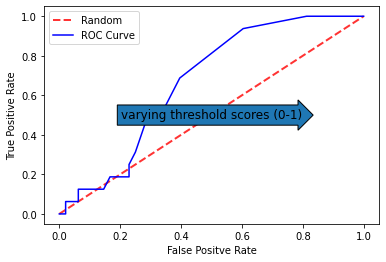

In [26]:
thresholds = np.linspace(0,1,100)
tpr=[]
fpr=[]
pos=len(true_positives)
fal=len(true_negatives)
for th in thresholds:
    tp=0
    fp=0
    for i in range(64):
        if pred[i]<th:
            break
        if i in true_positives:
            tp+=1
        else:
            fp+=1
    tpr.append(tp/pos)
    fpr.append(fp/fal)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)
plt.plot(fpr,tpr, label="ROC Curve",color="blue")
plt.text(0.5, 0.5, "varying threshold scores (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [72]:
np.savetxt('U_values_6.txt',U)
np.savetxt('V_values_6.txt',V)
np.savetxt('P_6.txt',prob(U,V))